### _EX02_CFPy_FloPy_

## CFPy - A Python package for pre- and postprocessing of the Conduit Flow Process for MODFLOW-2005 - Demonstration Example 02
THis example application demonstrate the coupling of CFPy with pyKasso to generate and process a number of stochastically generated conduit network structures.

The following pre-requisits should be fullfilled in order to successfully run the notebook
- CFPy and notebook should be placed in the same folder
- CFPv2.exe should be accessible through the path environment (or alternatively placed in the notebook folder)
- model computation with `cfpv2`

## 0.1 Import packages
In the first step, a number of necessary packages is importet. In case of failures you should install/update the packages through PIP

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as tck
import os
import glob
import shutil
import sys

import CFPy as cfpy
import flopy as flopy
import flopy.utils.binaryfile as bf
import pykasso as pk
path =""

## 0.2 Show versions

In [2]:
%load_ext watermark

In [3]:
%watermark

Last updated: 2023-03-13T14:48:08.704029+01:00

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.4.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 154 Stepping 4, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [4]:
%watermark --iversions

matplotlib: 3.5.2
flopy     : 3.3.6
numpy     : 1.22.4
re        : 2.2.1
pykasso   : 0.1.0
sys       : 3.9.13 | packaged by conda-forge | (main, May 27 2022, 16:50:36) [MSC v.1929 64 bit (AMD64)]
pandas    : 1.4.2
CFPy      : 0.1



## 0.3 Define functions

### 0.3.1 Functions for CFPy

The input information for MODFLOW CFP is provided by the function in order to use them efficiently in subsequent computational loops. For example to generate a large range of model variants.

In [5]:
def create_network():
    """
    Create the network with pyKasso and process/export it with cfpy
    
    Keyword Arguments: yaml_file -- absolute path to settings file of pyKasso, str
    
    Return: validator object, valid network array
    """
    # read in settings file
    catchment = pk.SKS(yaml_settings_file=yaml_file)
    
    # compute karst networks from the given information
    catchment.compute_karst_network()

    # generate elevation data
    # NOTE: elevation data has to have the same shape as the node network array!
    shp = np.array(catchment.karst_simulations[-1].maps['karst'][-1]).shape
   
    # Set elevation of all nodes
    elevs = np.ones(shp) * elev_nodes
    
    # validate the network from pyKasso
    validator = cfpy.preprocessing.pyKassoValidator(network=catchment, elevations=elevs)
    valid_network = validator.validate_network()
    
    # export the network
    # the exported information can directly be included in the .nbr-file as input for CFPy
    # notes on how to use the generated data with CFPy is given at the end of the notebook
    # per default, the network is exported to "CFPy_exported_network_for_NBR.txt" in the active directory
    validator.export_network()
    
    return validator, valid_network
    
def plot_network(network, number):
    """
    Option to plot a valid network array. Save plot as png
    
    Keyword Arguments
      network -- network object
      number -- identifier of the current iteration, float or int
    
    Return: -
      
    NOTE: here, the coordinate origin is in the lower left corner,
        corresponding to the MODFLOW-typical representation
    """
    # create a figure and axes
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, aspect="equal")

    # get the pipe and node coordinates from network object
    pipes_coords = network.pipes_coords
    node_x = network.node_x
    node_y = network.node_y
    
    # plot pipes
    for num, pipe in enumerate(pipes_coords):
        if num == 0:
            label = "Pipe"
        else:
            label = "_nolegend_"
        ax.plot(pipe[0],
                pipe[1],
                c="grey",
                linewidth=5,
                zorder=-1,
                alpha=0.6,
                label = label)

    # plot nodes
    for num, vals in enumerate(zip(node_x, node_y)):
        if num == 0:
            label = "Node"
        else:
            label = "_nolegend_"
        
        ###
        #####
        # This is hard-coded and can be optimized
        # For now, this is an easy solution to use
        #     different markers for the outlet and
        #     inlet nodes
        #####
        ###
        
        if vals[0] == 25.5 and vals[1] == 7.5:
            ax.scatter(vals[0],
                       vals[1],
                       zorder=100,
                       color="red",
                       s=130,
                       marker="^",
                       edgecolors="k",
                       label = "Inlet")
        
        elif vals[0] == 0.5 and vals[1] == 7.5:
            ax.scatter(vals[0],
                       vals[1],
                       zorder=100,
                       color="red",
                       s=90,
                       marker="D",
                       edgecolors="k",
                       label = "Outlet")
        
        else:
            ax.scatter(vals[0],
                       vals[1],
                       zorder=100,
                       color="red",
                       s=40,
                       edgecolors="k",
                       label = label)
    
    # set limits
    ax.set_xlim([0, n_cols])
    ax.set_ylim([0, n_rows])

    # invert axis for modflow representation
    ax.invert_yaxis()

    # adjust ticks if necessary
    ax.xaxis.set_minor_locator(tck.FixedLocator([i - 0.5 for i in range(1, n_cols + 1)]))
    ax.yaxis.set_minor_locator(tck.FixedLocator([i - 0.5 for i in range(1, n_rows + 1)]))
    
    ax.xaxis.set_major_locator(tck.FixedLocator([i for i in range(1, n_cols + 1)]))
    ax.yaxis.set_major_locator(tck.FixedLocator([i for i in range(1, n_rows + 1)]))
    
    ax.tick_params(axis='both', which='minor', labelsize=10)
    ax.set_xticklabels([i for i in range(1, n_cols + 1)], minor=True)
    ax.set_yticklabels([i for i in range(1, n_rows + 1)], minor=True)
    ax.set_xticklabels([None for i in range(n_cols)])
    ax.set_yticklabels([None for i in range(n_rows)])
    
    # add grid
    ax.grid(True, which="minor", ls=":", lw=0.5)
    ax.grid(True, which="major", ls="-", lw=1)

    # set descriptions
    ax.set_xlabel("Columns", size = 12)
    ax.set_ylabel("Rows", size=12)

    # add legend
    plt.legend(prop={'size': 12})
    
    # make beautiful if necessary
    plt.tight_layout()
    
    # save figure
    plt.savefig(f'network_{number}.jpg', dpi=300)
    
    return ax

def create_nbr(validator):
    """
    Create nbr file
    
    Keyword Arguments:
      validator -- validator object
    
    Return: -
    """
    # generate nbr file
    validator.generate_nbr(
        path = path,
        nrows = n_rows,
        ncols = n_cols,
        nlays = n_lays,
        nplanes = 1,
        layer_elevations = lay_elevs_array
    )
    
def read_nbr():
    """
    Read in nbr data
    
    Keyword Arguments: -
    
    Return: nbr data, conduits elevation
    """
    # create nbr object
    nbr = cfpy.nbr()

    # read model layer/node and conduit layer/node elevations

    # bot_elev has shape (n_layers, n_rows, n_cols)
    # cond_elev has shape (n_conduit_layers, n_rows, n_cols)
    # function looks for an .nbr-file, if none or more than one file is found, an error is raised
    # make sure to only have one .nbr-file in the working directory
    bot_elev, cond_elev = nbr.nbr_read()

    # create nbr data
    nbr_data = nbr.nbr(bot_elev, cond_elev)
    
    #return nbr_data, cond_elev
    return nbr_data, [bot_elev, cond_elev]

def create_pipe_data(p_num):
    """
    Create nested list of pipe data. Assuming same characteristics for all pipes
    
    Keyword Arguments:
      p_num -- pipe numbers, i.e. nbr_data[5]
    
    Return: pipe data
    """
    # diameter
    p_diameter = np.ones(len(p_num)) * diameter
    p_diameter = p_diameter.tolist()

    # tortuosity
    p_tortuosity = np.ones(len(p_num)) * tortuosity
    p_tortuosity = p_tortuosity.tolist()

    # roughness height
    p_rheight = np.ones(len(p_num)) * rheight
    p_rheight = p_rheight.tolist()

    # lower critical reynolds number
    p_lcritrey = np.ones(len(p_num)) * lcritrey
    p_lcritrey = p_lcritrey.tolist()

    # higher critical reynolds number
    p_hcritrey = np.ones(len(p_num)) * hcritrey
    p_hcritrey = p_hcritrey.tolist()

    # summarize all data in a 2D-array
    pipe_data = [p_num, p_diameter, p_tortuosity, p_rheight, p_lcritrey, p_hcritrey]
    
    return pipe_data

def create_node_data(n_num, nodes_locations):
    """
    Create nested list of node head data.
    
    Keyword arguments:
      n_num -- node numbers, i.e. nbr_data[0]
      nodes_locations -- node locations, i.e. nbr_data[2]
    
    Return: node head data
    """
    # parametrization for all n nodes
    # if head > 0: fixed head
    # if head == -1: calculated head
    n_head = np.ones((len(n_num))) * -1
    n_head = n_head.tolist()

    # search if the spring exists in the nodes
    if idxs_spring in nodes_locations:
        # get the position of spring node inside nbr_data
        pos = nodes_locations.index(idxs_spring)
        # assign the head to spring node
        n_head[pos] = chb_spring
    else:
        raise Exception("Cannot find indices of spring in the indices of nodes!")

    node_data = [n_num, n_head]
    
    return node_data

def create_kex_data(n_num):
    """
    Create nested list of conduit wall conductivity. 
    Assuming same characteristics for all conduits.
    
    Keyword Arguments:
      n_num -- node numbers, i.e. nbr_data[0]
      kex -- conduit wall conductivity, m^2/s (if sa_exchange = 0)
    
    Return: conduit wall conductivity data
    """
    kex_data = [n_num,
                np.ones(len(n_num)) * k_exchange]
    
    return kex_data

def create_cads_data(n_num):
    """
    Create list of conduit associated storage (CADS). 
    Assuming same characteristics for all conduits.
    
    Keyword Arguments:
      n_num -- node numbers, i.e. nbr_data[0]
      cad -- conduit associated storage, m
    
    Return: CADS data
    """
    cads_data = np.ones((len(n_num))) * cad
    cads_data = cads_data.tolist()
    
    return cads_data

def init_cfp_module(nbr_data, cond_elev, pipe_data, node_data, kex_data, cads_data):
    """
    Initialise CFP Module
    
    Keyword Arguments:
      nbr_data -- nbr data
      cond_elev -- conduit elevation
      pipe_data -- pipe data
      node_data -- node head data
      kex_data -- conduit wall conductivity data
      cads_data -- CADS data
    
    Return: cfp object
    """
    cfp = cfpy.cfp(mode = 1,
                   nnodes = len(nbr_data[0]), 
                   npipes = len(nbr_data[5]), 
                   nlay = n_lays, 
                   nbr_data = nbr_data, 
                   geoheight = cond_elev, 
                   sa_exchange = 0, 
                   epsilon = cfptol,
                   niter = 2000, 
                   relax = cfprelax, 
                   p_nr = 0, 
                   cond_data = pipe_data, 
                   n_head = node_data, 
                   k_exchange = kex_data, 
                   ncl = 0, 
                   cl = 0, 
                   ltemp = 10,
                   condl_data = 0,
                   cads = cads_data)

    # create list of strings
    cfp = cfp.cfp()
    
    return cfp

def init_coc_module(n_num, p_num):
    """
    Initialise COC Module (Conduit Output Control)
    
    Keyword Arguments:
      n_num -- node numbers, i.e. nbr_data[0]
      p_num -- pipe numbers, i.e. nbr_data[5]
    
    Return: coc object
    """
    coc = cfpy.coc(nnodes = len(nbr_data[0]),
                   node_numbers = nbr_data[0],
                   n_nts = 1,
                   npipes = len(nbr_data[5]), 
                   pipe_numbers = nbr_data[5],
                   t_nts = 1)

    coc = coc.coc()
    
    return coc

def init_crch_module(n_num):
    """
    Initialise CRCH Module (Conduit Recharge)
    
    Keyword Arguments
    n_num -- node numbers, i.e. nbr_data[0]
    
    Return: crch object
    """
    # p_crch is list of length (n_nodes) specifying the direct recharge fraction for each node
    # initially set p_crch to 0 for all nodes (no direct recharge)
    p_crch = np.zeros((len(n_num))).tolist()

    crch = cfpy.crch(iflag_crch = 1, 
                     nper = n_pers, 
                     node_numbers = n_num, 
                     p_crch = p_crch)

    # create list of strings
    crch = crch.crch()
    
    return crch

def cfp_write_input(coc, crch, cfp):
    """
    Write CFP input
    
    Keyword Arguments
    modelname -- model name
    coc -- coc object
    crch -- crch object
    cfp -- cfp object
    
    Return: -
    """
    input_files = cfpy.write_input(modelname = modelname,
                                   data_strings = [coc, crch, cfp],
                                   file_extensions = ['coc', 'crch', 'cfp'])

    # write CFP input files
    input_files.write_input()
    
    return input_files

def cfp_update_nam():
    """
    Update nam file
    
    Keyword Arguments
    modelname -- model name
    
    Return: -
    """
    nam = cfpy.update_nam(modelname = modelname,
                          mode = 1,
                          cfp_unit_num = 52,
                          crch_unit_num = 53,
                          coc_unit_num = 54)

    # update existing .nam file
    nam.update_nam()
    
    return nam

### 0.3.2 Helpers
This are small routines to help making the workflow efficient

In [6]:
def position_to_index(x, y):
    """
    Get the modflow (!) based index for a given geo position
    
    Keyword Arguments:
      x -- x position, m
      y -- y position, m
    
    Return: column index, row index
    """    
    col_idx = np.floor(x / delr) + 1
    row_idx = n_rows - np.floor(y / delc)
    
    return col_idx, row_idx
        
def store_results(number):
    """
    Create a directory and put the current results into the directory.
    Also make a copy of the network plot and put it into the plot directory
    
    Keyword Arguments:
      number -- identifier of the current iteration, float or int
    
    Return: -
    """
    # Copy network plot 
    # define directory where to copy the plot to
    figure_dir = os.path.join(path, 'FIGS', 'Network_Plots')
    
    # define destination file name
    destination = os.path.join(figure_dir, f"network_{number}.jpg")
    
    # check if directory already exists. If not, create it.
    # if yes, check if a plot with the same run number exists
    if os.path.exists(figure_dir):
        if os.path.isfile(destination):
            raise Exception(f"File {destination} exists already! Unable to write results")
    else:
        os.makedirs(figure_dir)
        
    # copy file
    shutil.copy(f"network_{number}.jpg", destination)
    
    # Move results
    
    # define directory where to store the results
    target_dir = os.path.join(path, f"run_{number}")
    
    # make sure the directory does not exist
    if os.path.exists(target_dir):
        raise Exception(f"Directory {target_dir} exists already! Unable to write results")
        
    # create directory
    os.makedirs(target_dir)
    
    # get alle files that will be moved
    files_to_move = glob.glob("NODE*") + glob.glob("TUBE*") \
                    + [f"{modelname}.list", f"{modelname}.hds", f"{modelname}.cbc"] \
                    + [f"network_{number}.jpg"] \
                    + glob.glob("*.nbr") + glob.glob("*.coc") + glob.glob("*.cfp") + glob.glob("*.crch")
    
    # move files to directory
    for f in files_to_move:
        source = os.path.join(path, f)
        destination = os.path.join(target_dir, f)
        shutil.move(source, destination)

def clean_results():
    """
    Remove all run-dictionaries and the plot directory
    
    Keyword Arguments: -
    
    Return: -
    """    
    
    #path = os.getcwd()
    path_fig = os.path.join(path, 'FIGS')
    
    rm_dirs = glob.glob(os.path.join(path, "run_*"))
    if os.path.exists("network_plots"):
        rm_dirs.append("network_plots")
    for rmd in rm_dirs:
        shutil.rmtree(rmd)
    if os.path.exists(path_fig):
        shutil.rmtree(path_fig)

## 1 Create basic MODFLOW model (FloPy)

### 1.1 Path and Model
Defines the directory for model runs and creates the model object

In [7]:
# change active directory to model directory

# change active directory to model directory

if not os.path.exists(path):
    nb_dir = os.getcwd()
    path = os.path.join(nb_dir, "CFPy_EX02_RUN")
    if not os.path.exists(path):
        os.makedirs(path)

# path to yaml file (PyKasso settings)
yaml_file = os.path.join(nb_dir, "settings2.yaml")

# set model name
modelname = "CFPy_EX02"

os.chdir(path)

# using the CFPv2 here, which does support CADS // comment out if CFPv2.exe is available through the path environment
# CFPv2_exe = "/home/grabow/cfpv2/CFPv2.exe"

#Generate the model object
mf = flopy.modflow.Modflow(modelname, exe_name="CFPv2.exe")

### 1.2 Generate the MODFLOW continuum
The subsequent boxes define the continuum model (MODFLOW-2005)

#### 1.2.1 General domain and discretization

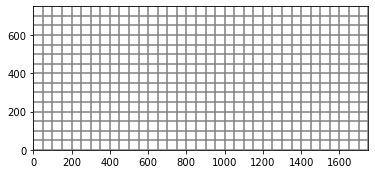

In [8]:
# DIS - DISCRETIZATION

# NOTE: n_rows, n_cols, n_lays needs to be the same as specified in the .nbr-file!
# number of rows in the domain; number of columns in the domain; number of layers in the domain
n_rows = 15
n_cols = 35
n_lays = 1

# width of each cell along rows & along columns
delr = 50.0
delc = 50.0

# Compute total length along x / # Compute total length along y
Lx = n_cols*delr
Ly = n_rows*delc

# layer elevations [top, bottom]
lay_elevs = [1000.,0.]

# time discretization
# time units: 1=seconds, 2=minutes, 3=hours, 4=days / # define number of stress periods
time_unit = 1
n_pers = 1

# length (number of steps) of stress periods
# this variable assumes a uniform time discretization, i.e. all stress periods
# have the same number of time steps except the first stationary time step
perlen = 1

# number of time steps in each stress period (integer array)
# e.g., [1, 50, 50, 70, 33, ...]
n_stps = [perlen]

# list with "False" everywhere except 0th element (which is "True")
#     to specify steady state ("True") or transient ("False")
#     stress periods
steady = [1]

# Create dis object
dis = flopy.modflow.ModflowDis(mf, n_lays, n_rows, n_cols, n_pers, delr, delc, 
                                   top=lay_elevs[0], botm=lay_elevs[1],
                                   perlen=perlen, nstp=n_stps, steady=steady,
                                   itmuni=time_unit, lenuni=2)


# BAS - BASIC INFORMATION

# if ibound < 0: constant head, if = 0: inactive, if > 0: active.
# create arrays to indicate active cells (ibound) and starting heads (H_init)
# integer array of dim (z,y,x), makes all cells active 
ibound = np.ones((n_lays, n_rows, n_cols), dtype=np.int32)

# replace leftmost column with -1 to indicate defined head 
ibound[:,:,0] = -1

# matrix starting head, m
H_init = 100.0

# defined head of leftmost column, m
chb_left = 50.0

# defined head at spring node, m
chb_spring = 50.0

# initialize starting head array
H_init_array = np.ones((n_lays, n_rows, n_cols), dtype=np.float32)

# assign starting head values to all cells
H_init_array[:,:,:] = H_init

# assign constant head value to leftmost column
H_init_array[:,:,0] = chb_left

bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=H_init_array)


# LPF - LAYER PROPERTY FLOW

# horizontal hydraulic conductivity of the porous matrix, m/s; # vertical hydraulic conductivity
hk = 1E-5
vka = hk

#unit number to save outputs to / #value assigned to dry cells
ipakcb = 50
hdry = 999.

#0=confined, >0 = unconfined/convertible / #method of calculating interblock tranmissivity, 0=harmonic mean (default)
laytyp = 1
layavg = 0

#horizontal anisotropy (ratio of Ky (along cols) to Kx (along rows) / #indicates vka = Kz / #wetting, 0=inactive, 1=active
chani = 1
layvka = 0
laywet = 0

lpf = flopy.modflow.ModflowLpf(mf, laytyp=laytyp, chani=chani, layvka=layvka, laywet=laywet, 
                ipakcb=ipakcb, hdry=hdry, hk=hk, hani=chani, vka=vka, wetdry=laywet)

mf.modelgrid.plot()

#### 1.2.2 Recharge boundary

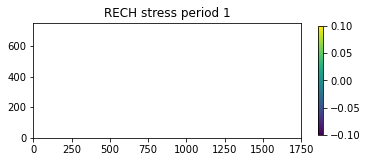

In [9]:
# RCH - RECHARGE BOUNDARY

# recharge to WHOLE AREA, m/s
recharge_wholearea = 1E-8

# dictionary of recharge fluxes for each stress period
rech = {0:recharge_wholearea}

# flag, 1=rech only applied to top layer / # if non-zero, cell budget data will be saved
nrchop = 1
ipakcb = 50

rch = flopy.modflow.mfrch.ModflowRch(mf, nrchop=nrchop, ipakcb=ipakcb, rech=rech)

mf.rch.rech.plot(kper="all", masked_values=[0.0], colorbar=True);
#TODO Plot map with recharge distribution

#### 1.2.3 Numerical solver and output control

In [10]:
#PCG - SOLVER

#max number of outer iterations / #number of inner iterations / # modflow general tolerance /# modflow relaxation parameter
mxiter = 2000
iter1 = 2000
mftol = 1e-3
mfrelax = 0.99

#flag for matrix conditioning method, 1=modified incomplete cholesky
npcond = 1

#flag for active cell surrounded by dry cells. 0=converts to dry, not0=converts only if hcof=0
ihcofadd = 9999

#relaxation parameter with npcond=1 /#estimate of upper bound /#printout interval /#print flag, 5=? /#damping factor
relax = mfrelax
nbpol = 2
iprpcg = 5
mutpcg = 0
damppcg = 0.99

pcg = flopy.modflow.ModflowPcg(mf, mxiter=mxiter, iter1=iter1, npcond=npcond, hclose=mftol, rclose=mftol, 
                                   relax=relax, nbpol=nbpol, iprpcg=iprpcg, mutpcg=mutpcg, damp=damppcg,
                                   ihcofadd=ihcofadd)

# OC - OUTPUT CONTROL

# create dictionary
per_dict = {(0,0):['print head', 'save head', 'save budget']}

# create output control file using dictionary
oc = flopy.modflow.ModflowOc(mf, stress_period_data=per_dict)

### 1.3 Basic information for the conduit model (CFP)
#### 1.3.1 Conduit Flow Process related information

In [11]:
# CFP numerical solution - general tolerance
cfptol = 1e-9

# CFP numerical solution - relaxation parameter
cfprelax = 0.99

# CFP position of spring, only change with settings.yaml!
x_spring = 0
y_spring = 375

# elevation of all nodes, m
elev_nodes = 20.

# pipe diameter, m; pipe tortuosity; roughness height, m
diameter = 0.5
tortuosity = 1.
rheight = 0.05

# lower and higher critical reynolds number
lcritrey = 2000
hcritrey = 6000

# conduit wall conductivity, m^2/s
k_exchange = 0.001

# conduit associated storage (CADS), m
cad = 0.00

### 1.4 Derived variables
The following parameters are derived from the given parameters

In [12]:
# Get the modflow indices for spring
col_idx_spring, row_idx_spring = position_to_index(x_spring, y_spring)
idxs_spring = [int(col_idx_spring), int(row_idx_spring), 1]

# expand elevations to array
lay_elevs_array = [np.ones((n_rows, n_cols)) * lay_elevs[0],
                   np.ones((n_rows, n_cols)) * lay_elevs[1]]



## 2 Computation - run variants
Subsequently, a number of model variants is computed by running a loop. Results are written in specific folders and subseqently evaluated

Running model variant  0
CAUTION: You are using the development version of this package.

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

Always visually check the validated network for structuralcorrectness! 
i.e., whether branches are correctly isolated or ifthey got connected during processing.
Elapsed time (.nbr file read): 0.0 s
Elapsed time (write nbr data): 0.0 s
FloPy is using the following executable to run the model: .\CFPv2.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                   Version 1.9.25 06/04/2013 CFPv2 HTM/STM/UMT-LNK/CADS
THIS IS A RESEARCH VERSION OF CFP MODE 1 FOR TEST PURPOSES WITHOUT ANY WARRANTY REGARDING CORRECTNESS
CONTACT: THOMAS.REIMANN@TU-DRESDEN.DE AND BSHOEMAK@USGS.GOV

 Using NAME file: CFPy_EX02.nam 
 Run start date and time (yyyy/mm/dd hh:m

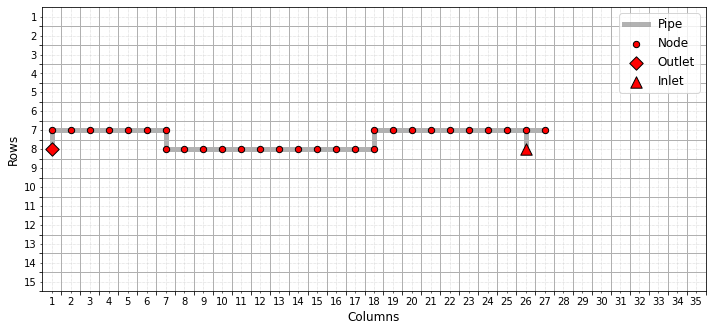

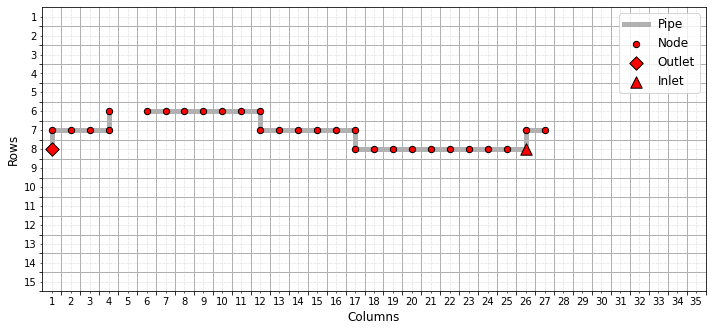

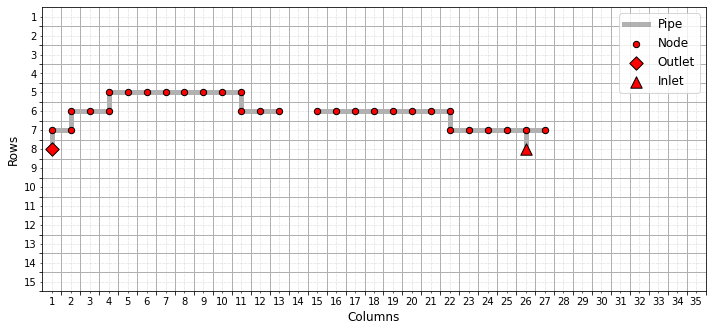

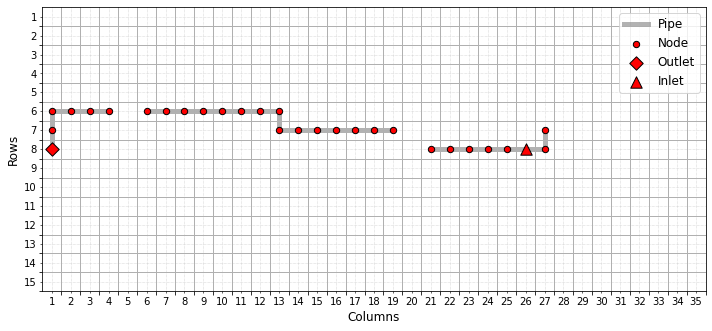

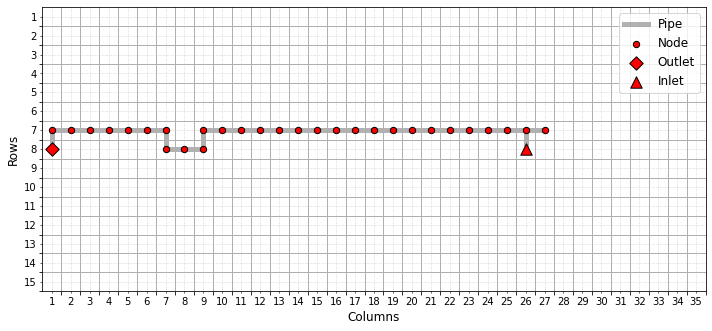

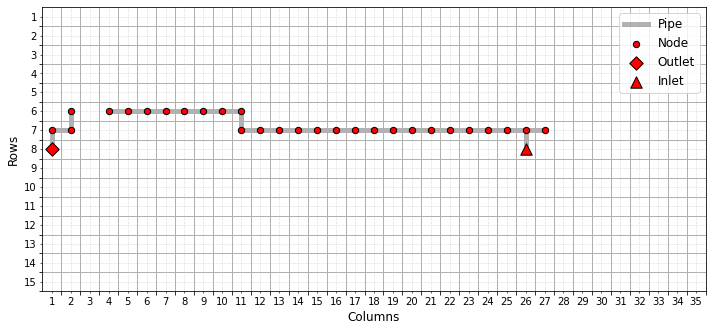

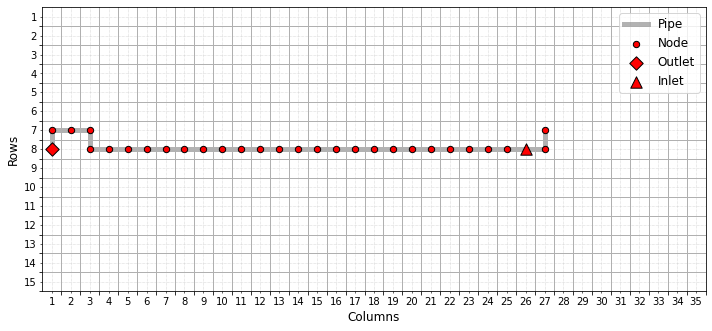

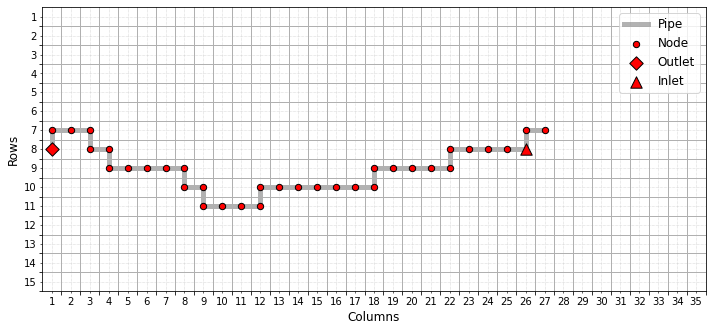

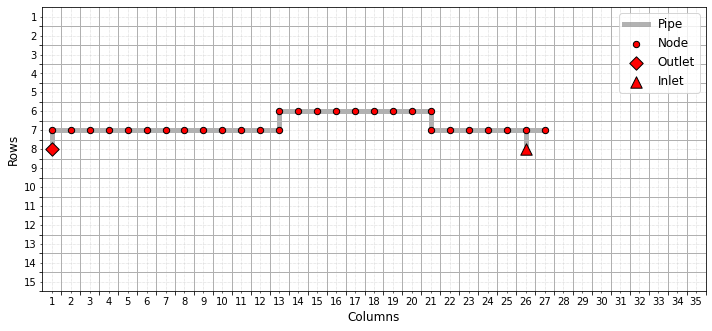

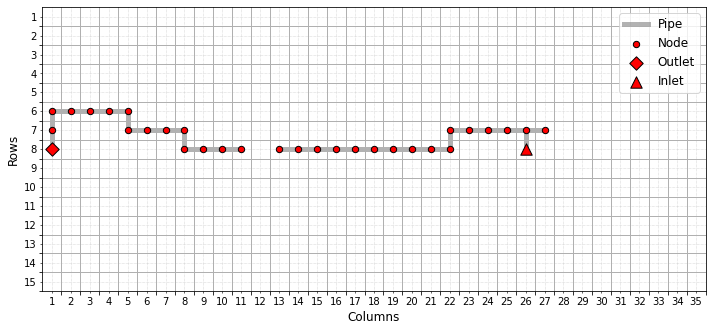

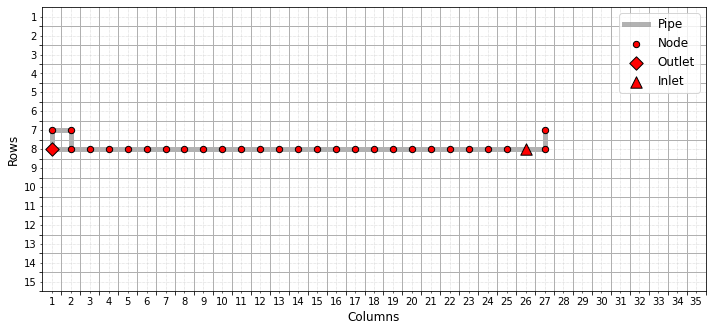

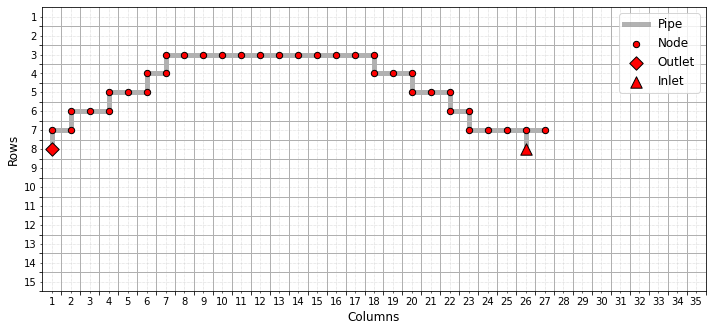

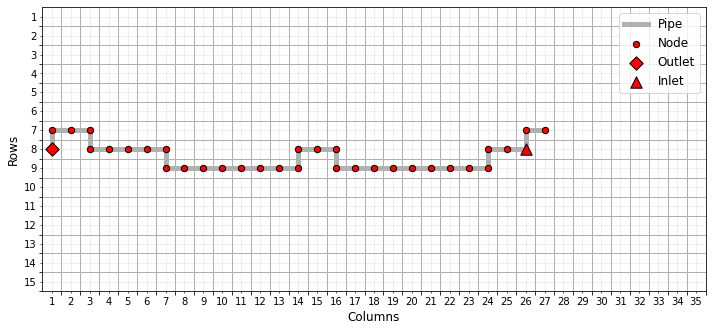

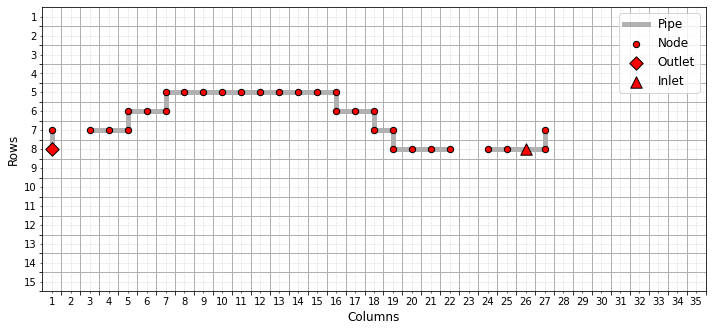

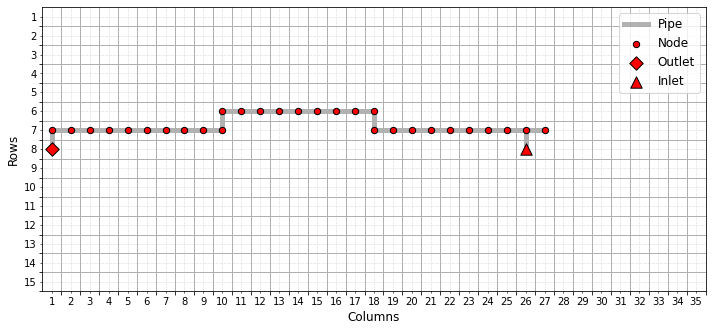

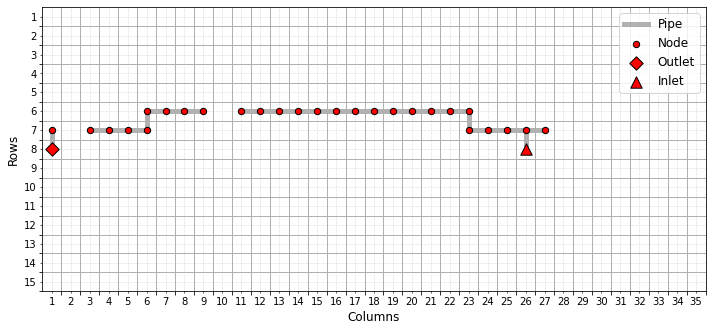

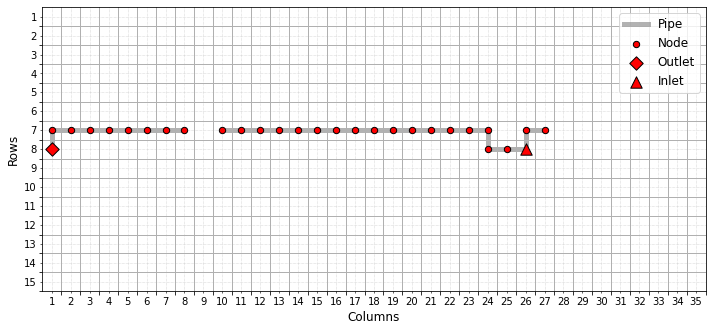

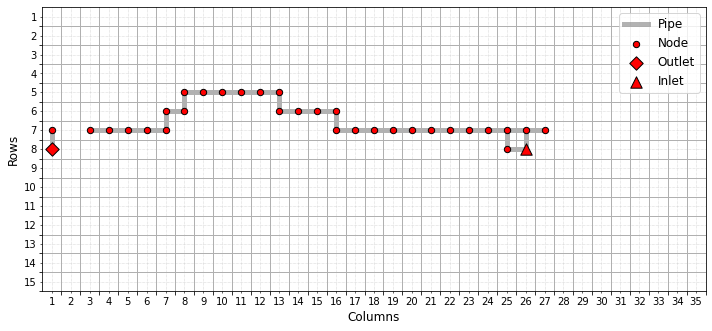

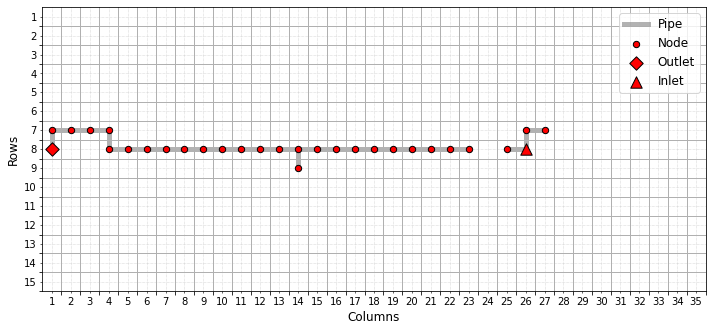

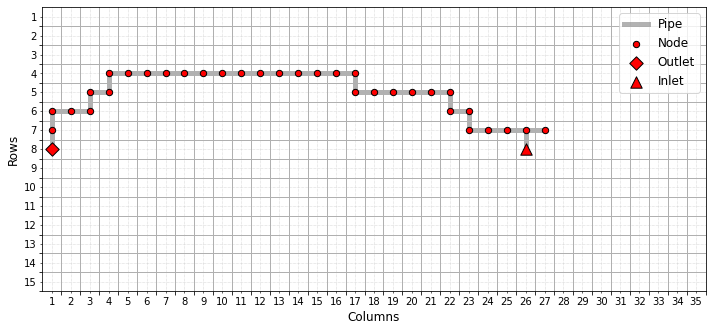

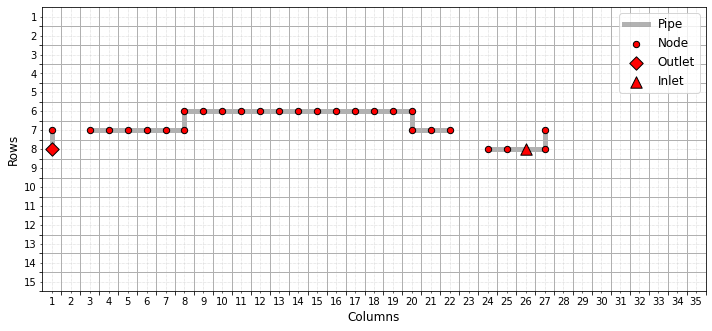

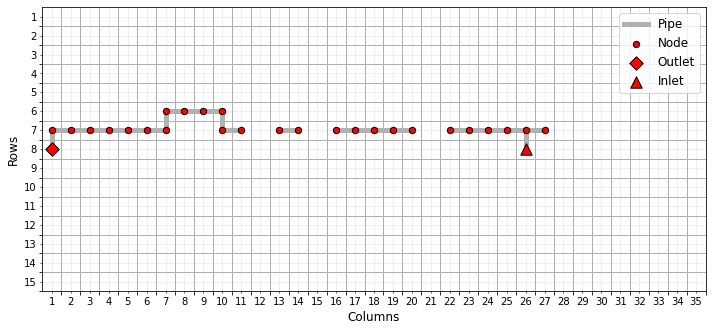

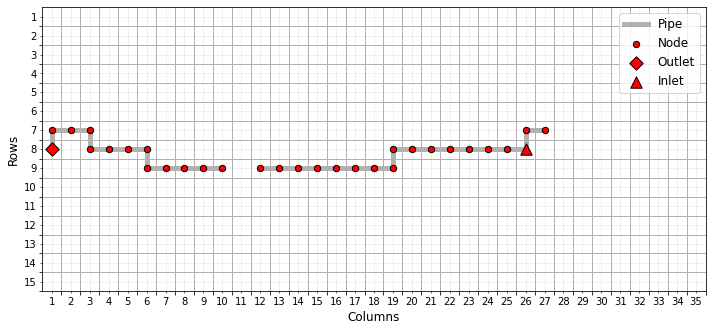

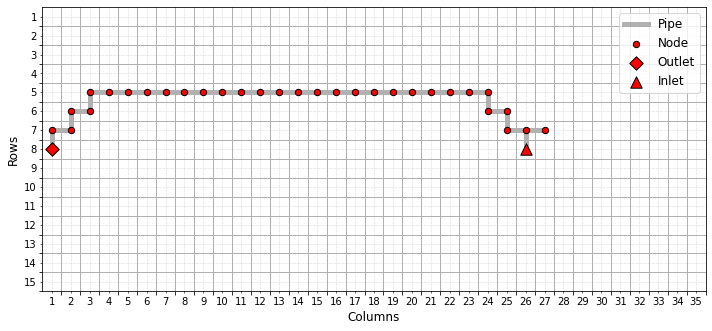

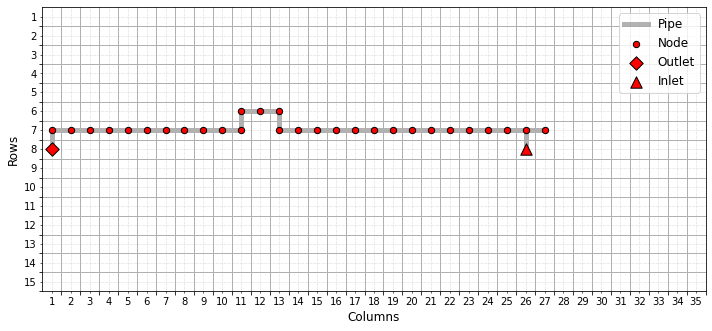

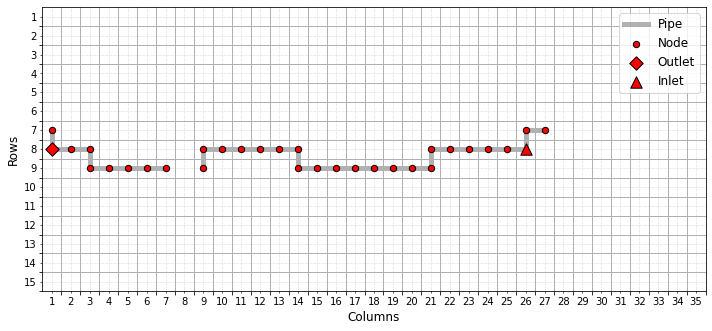

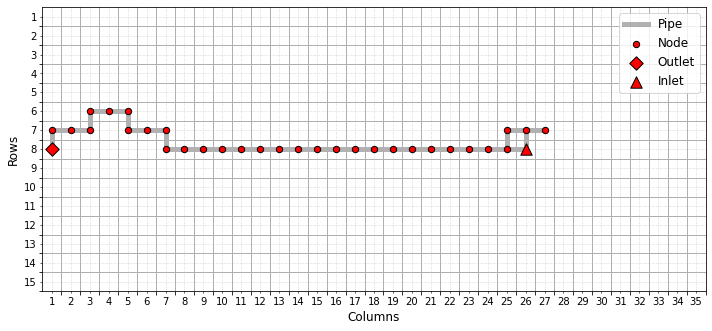

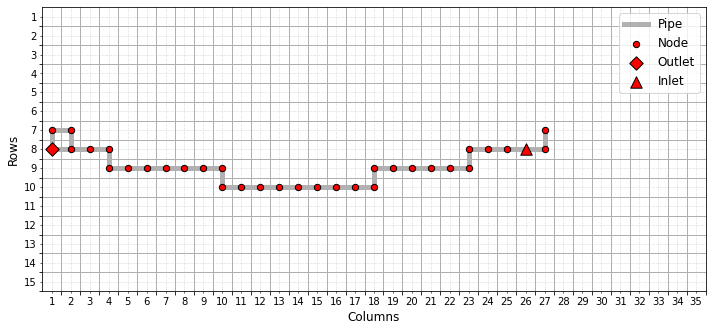

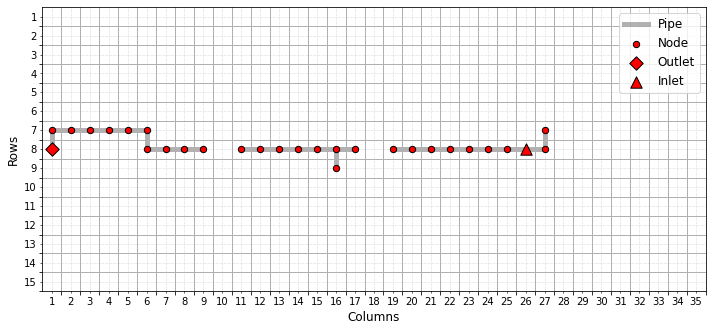

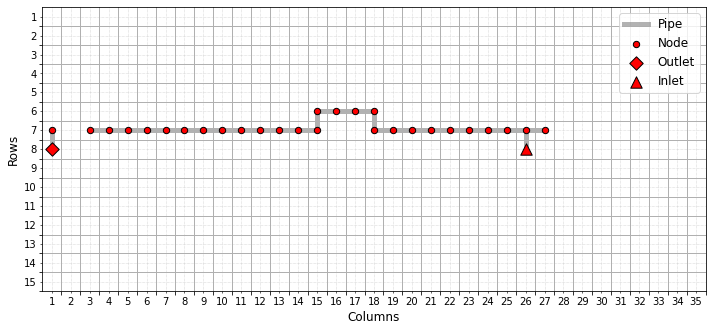

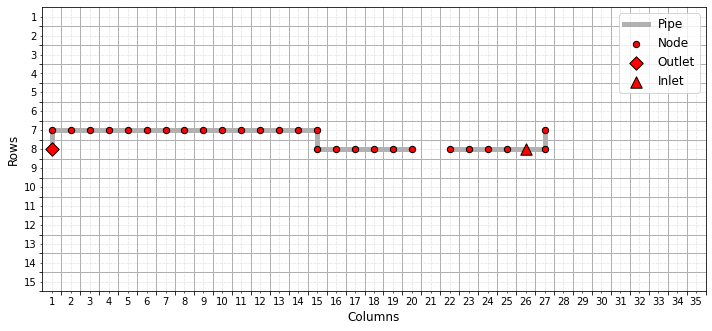

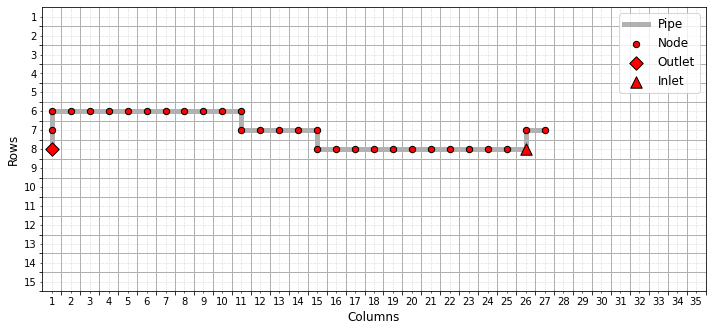

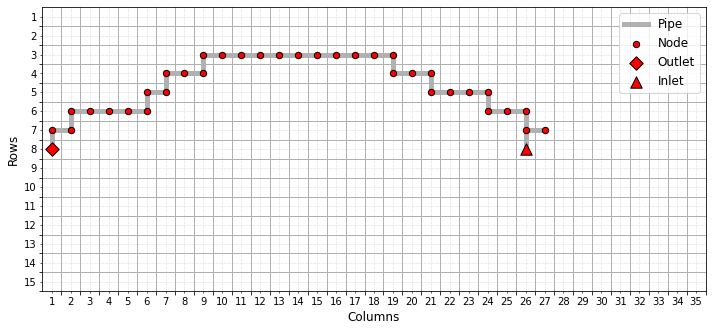

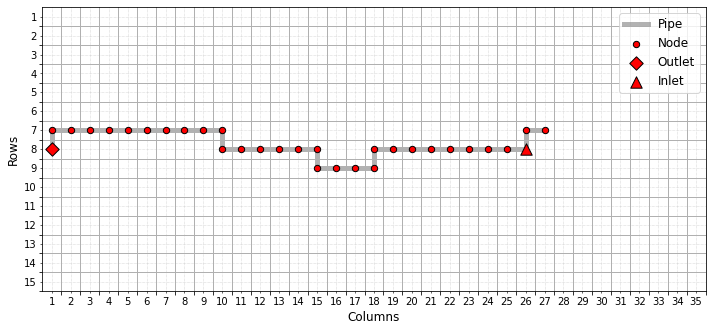

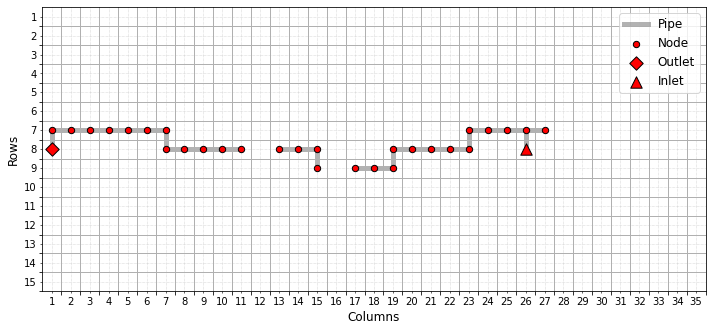

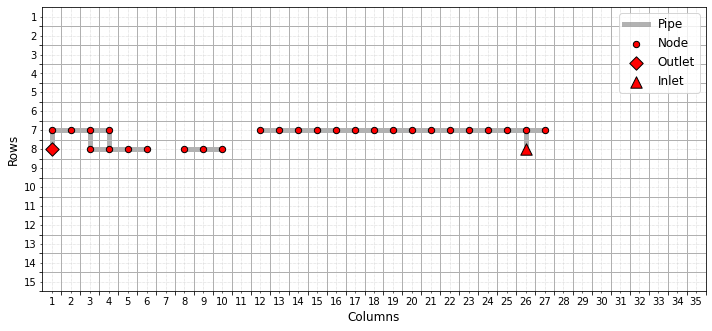

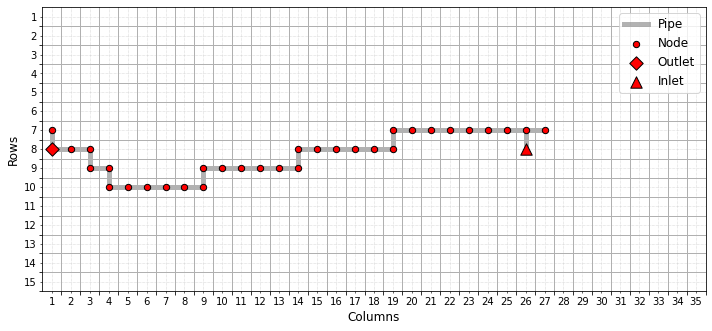

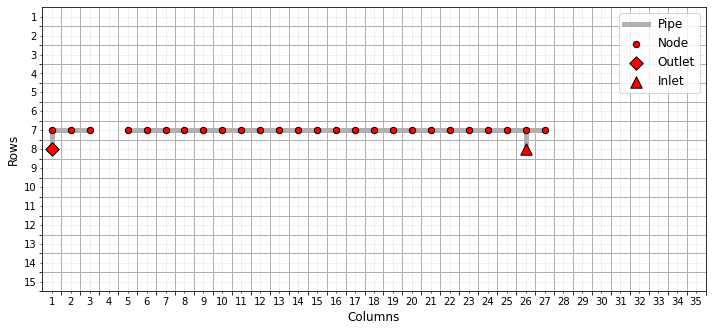

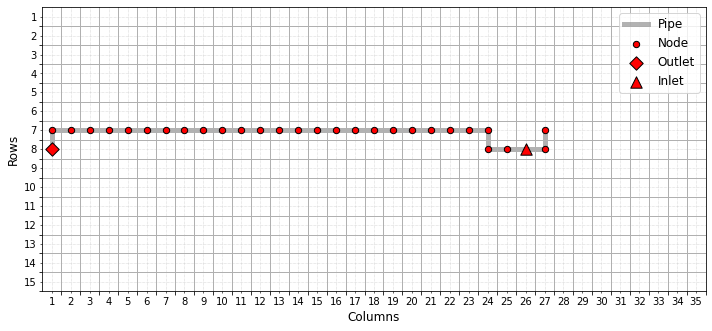

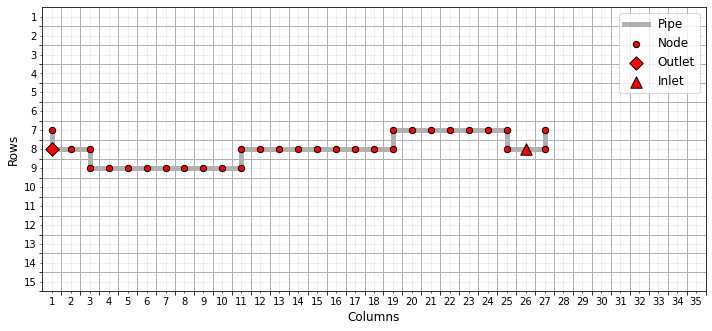

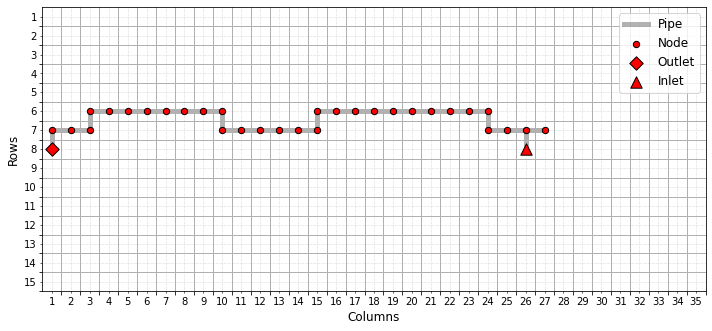

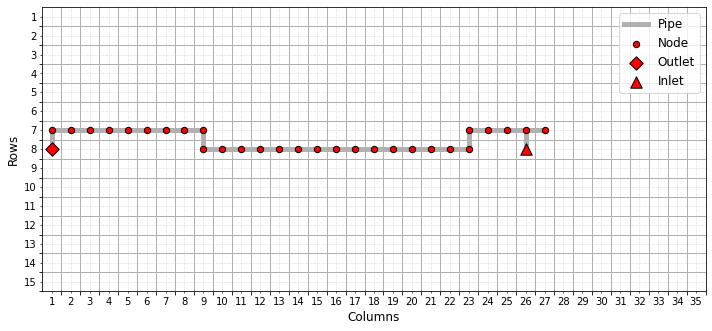

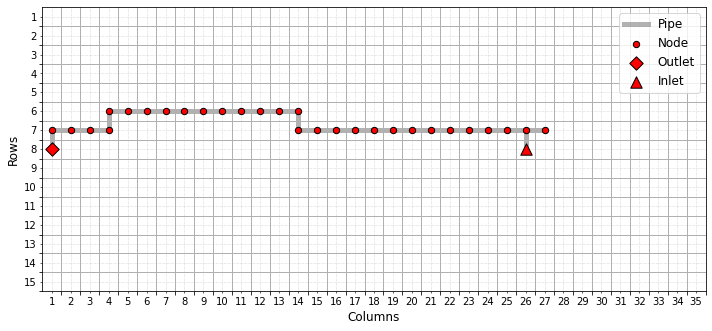

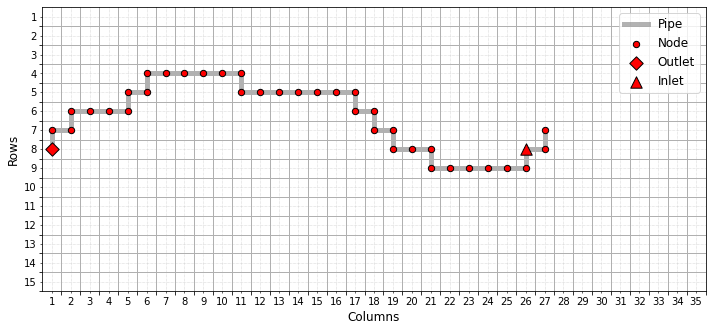

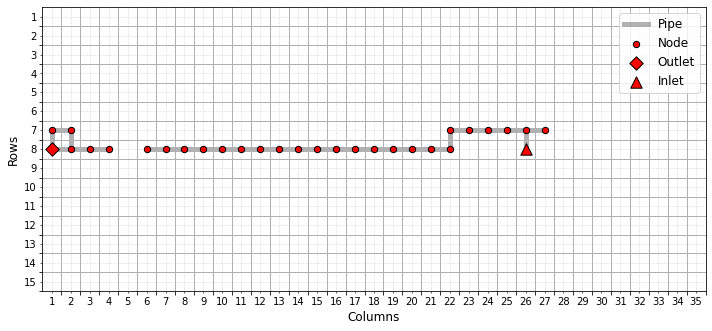

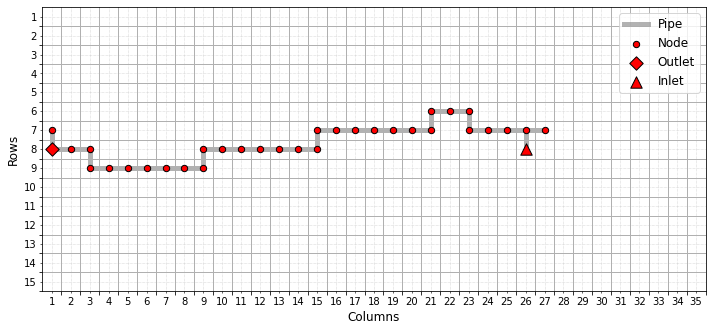

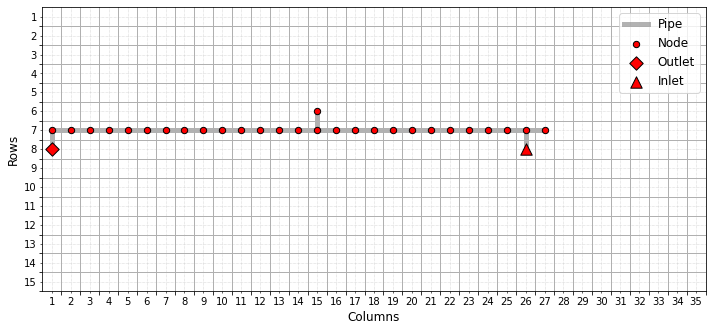

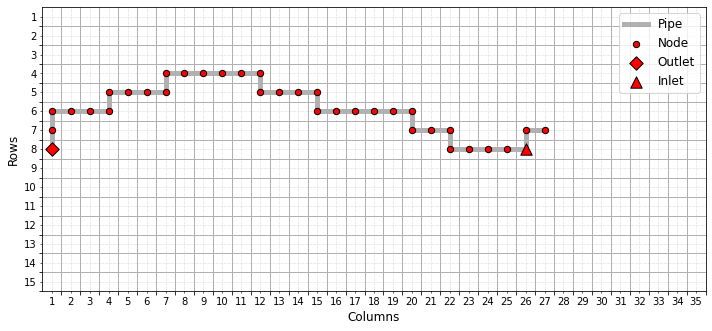

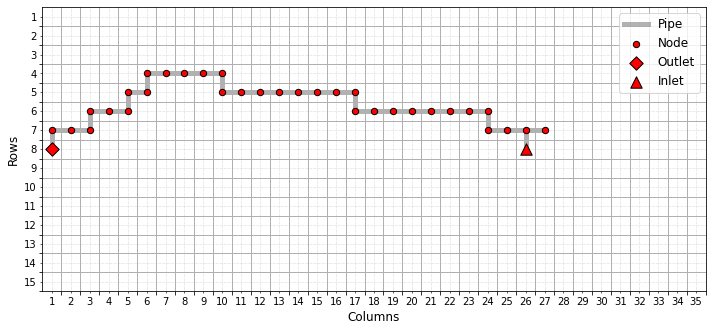

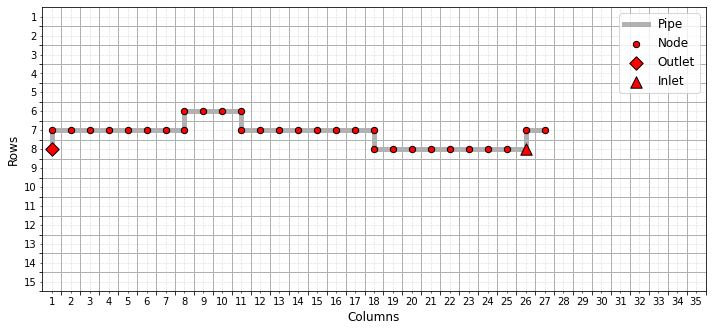

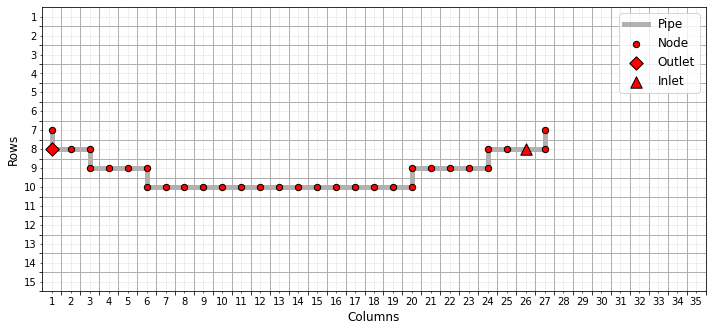

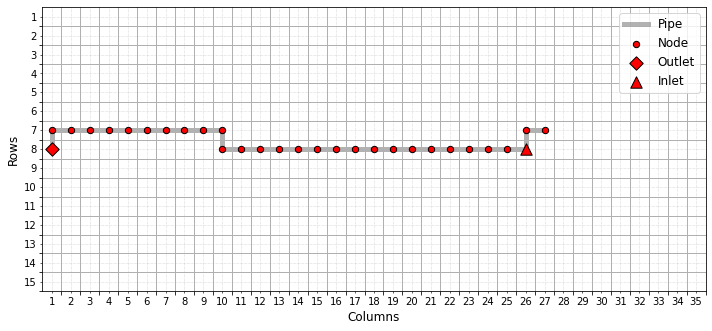

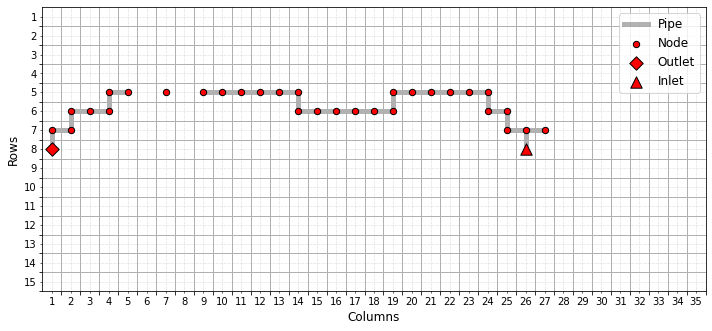

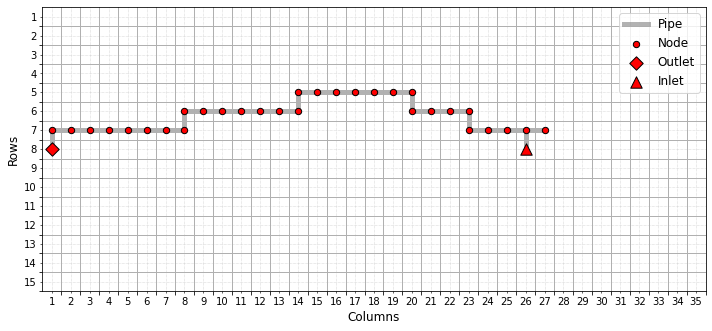

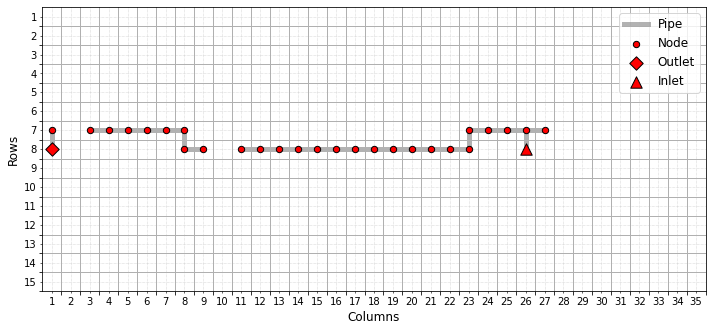

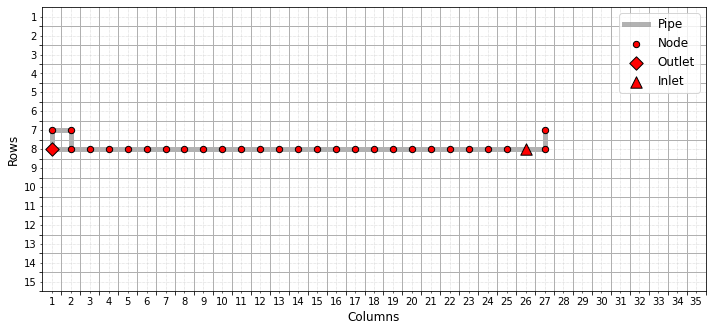

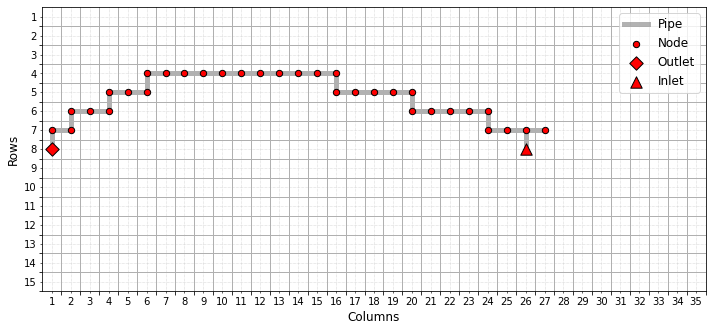

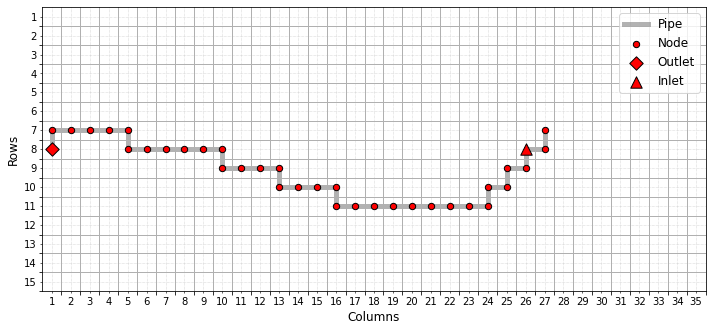

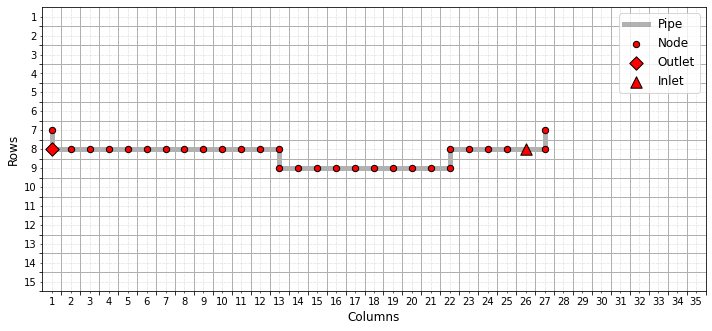

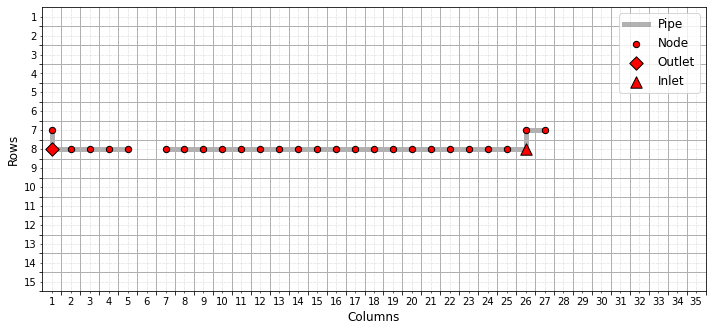

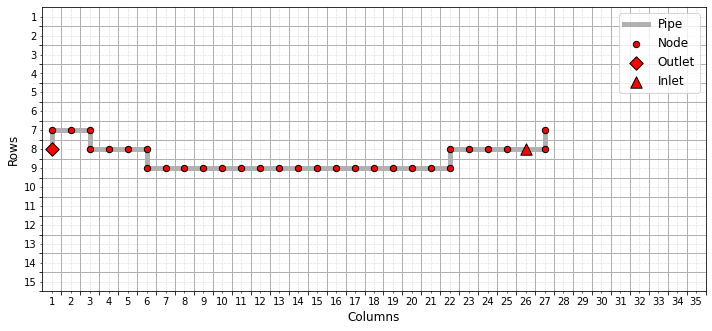

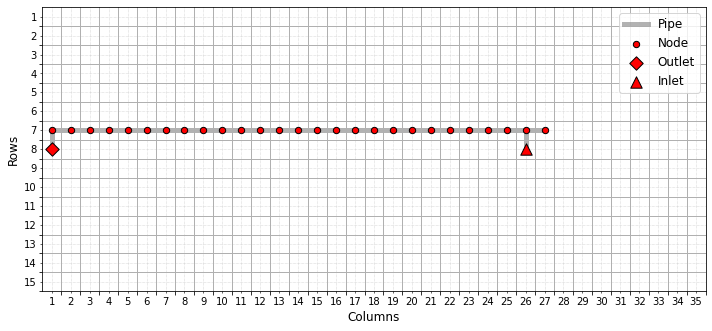

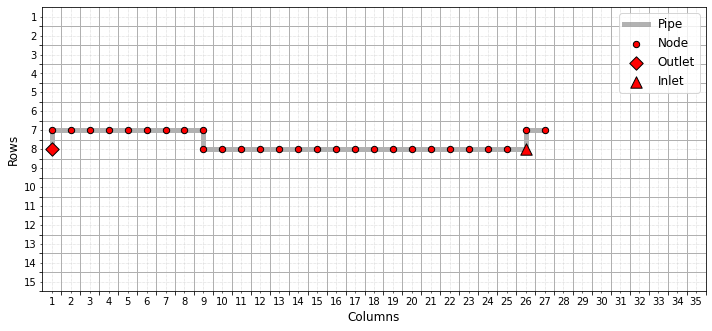

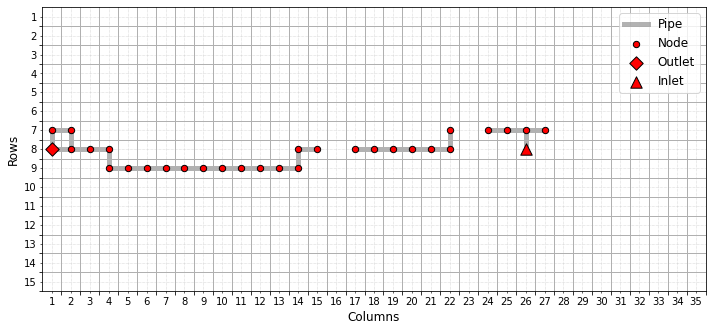

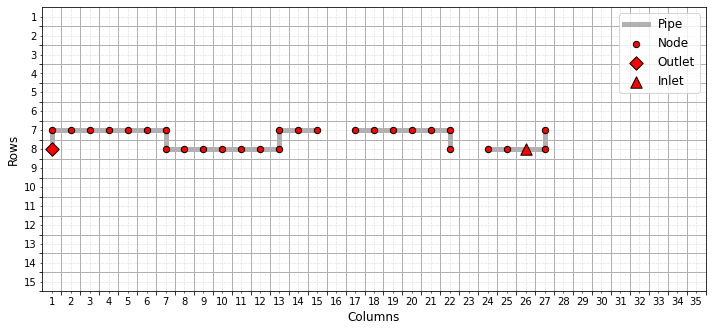

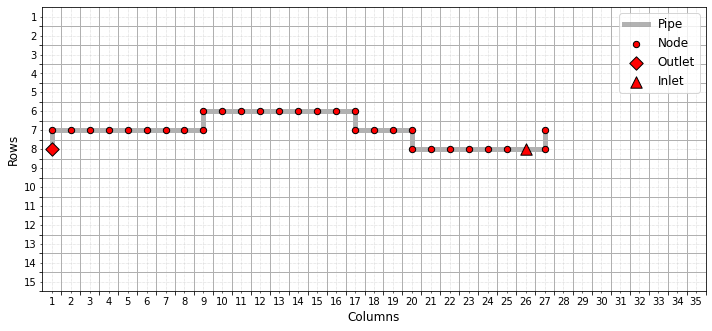

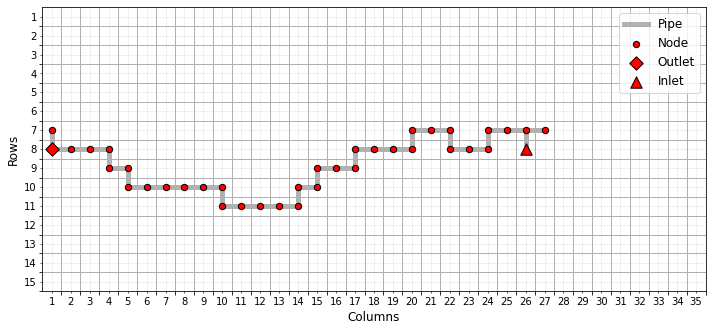

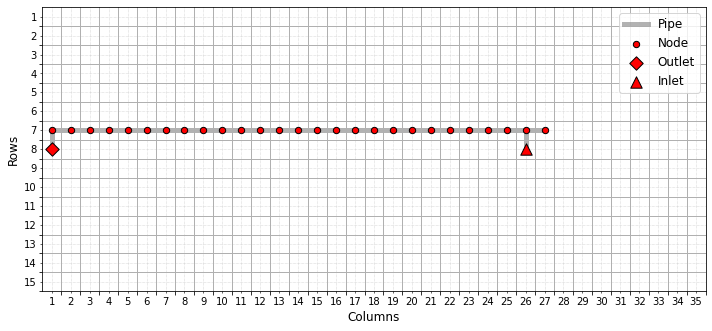

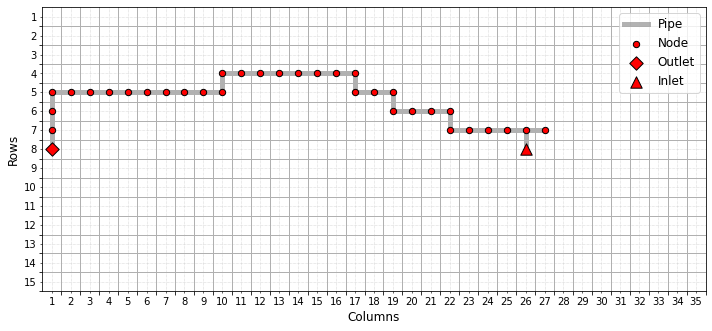

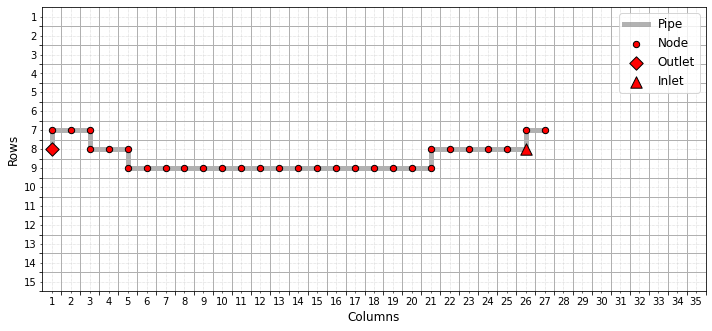

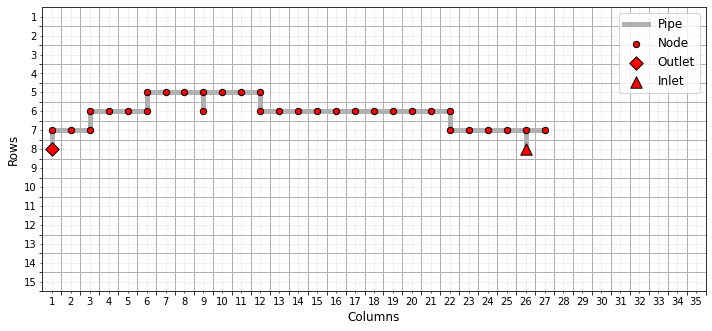

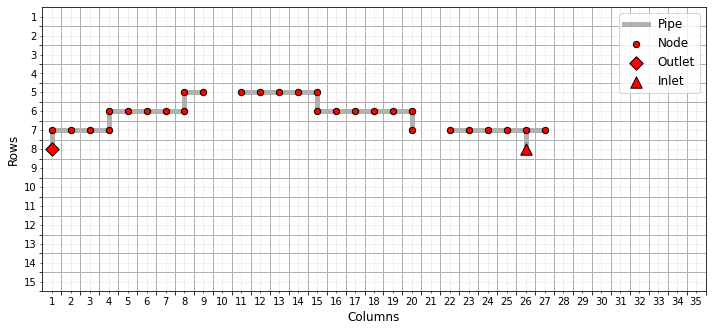

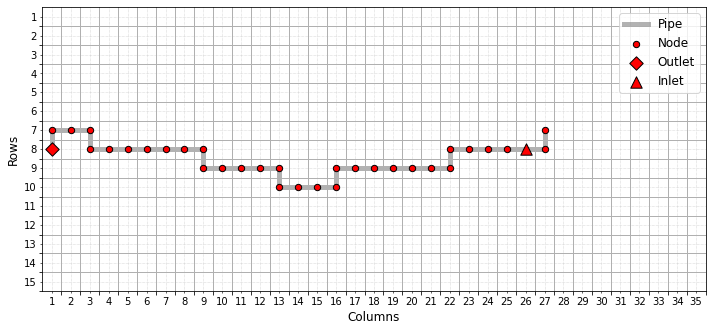

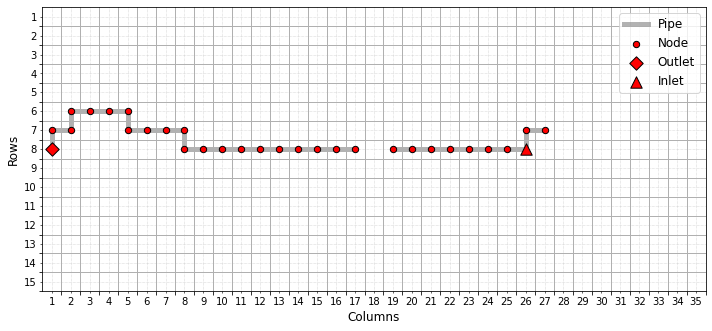

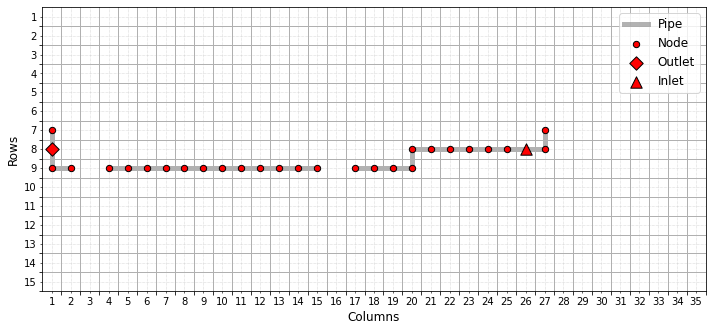

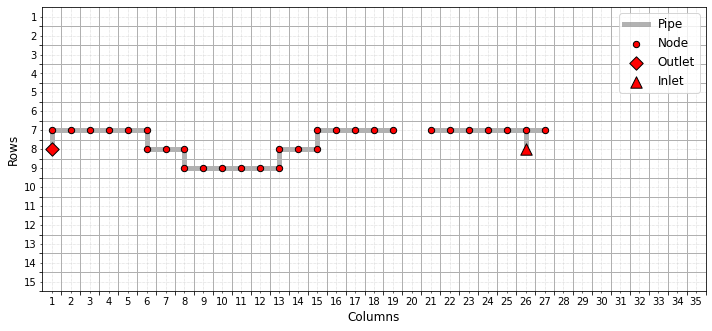

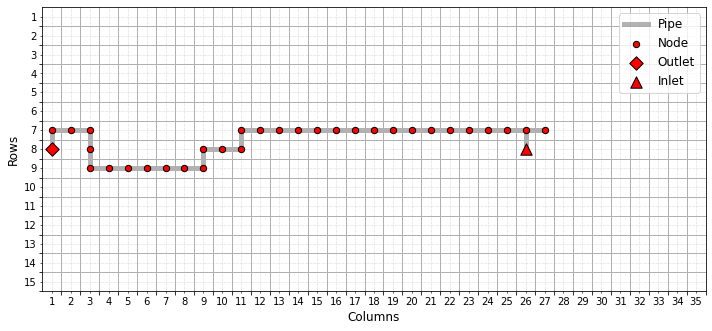

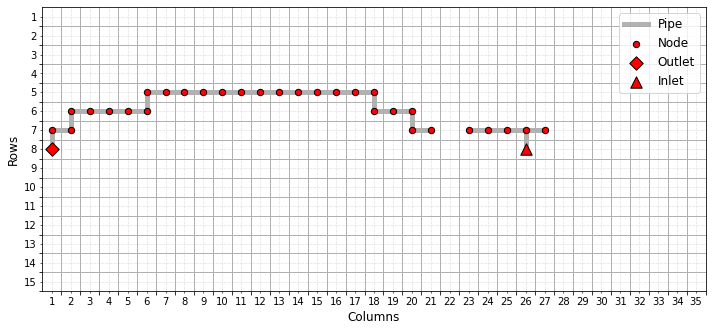

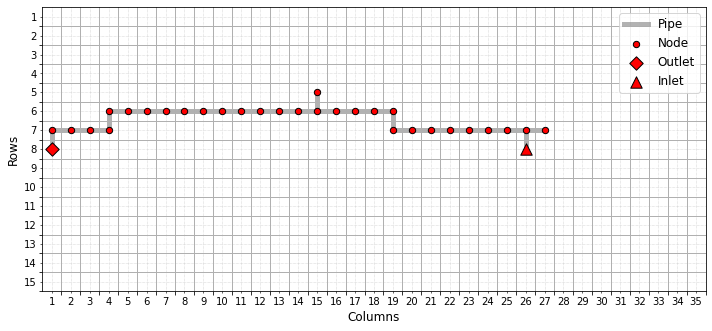

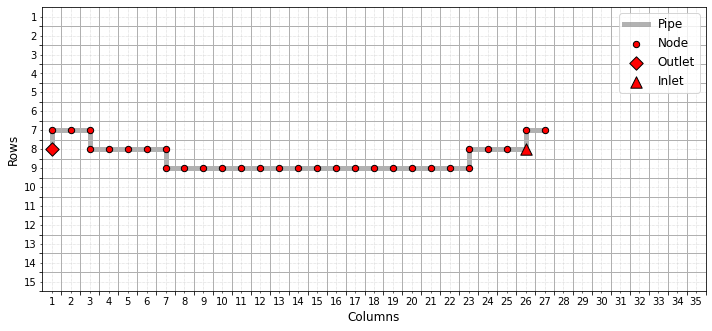

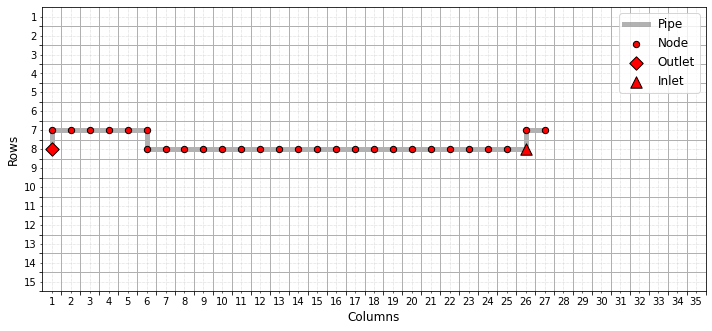

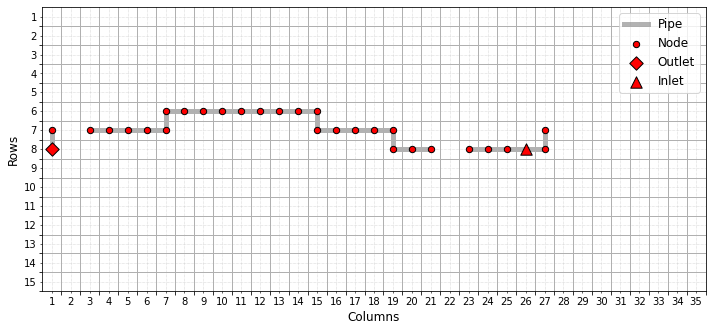

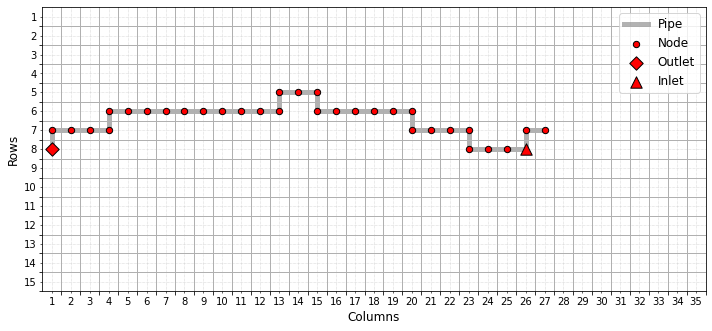

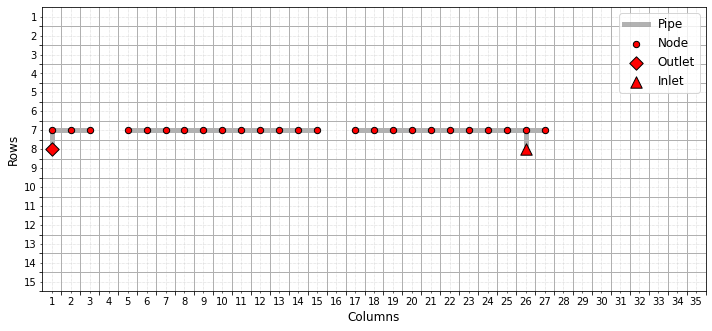

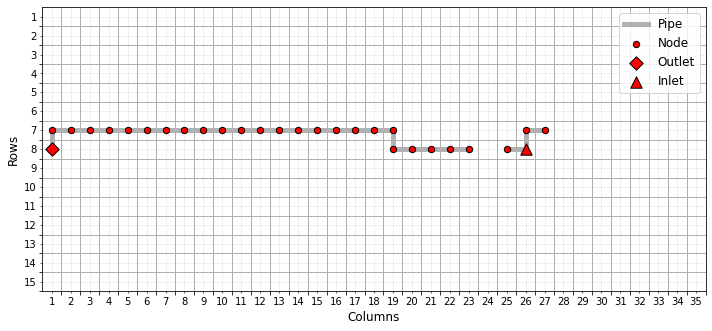

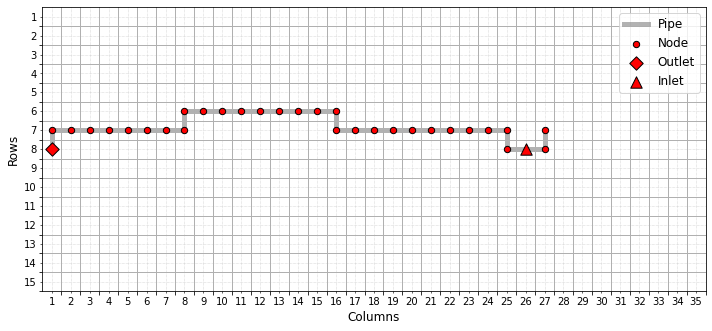

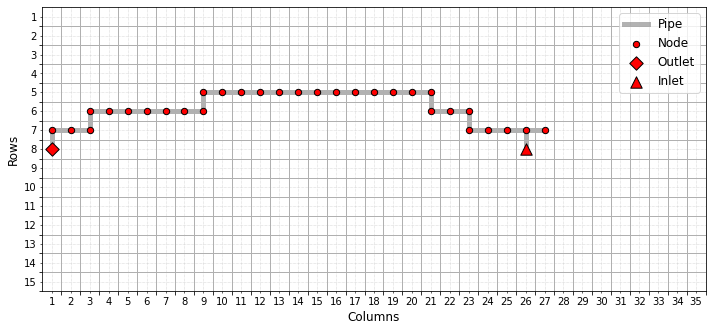

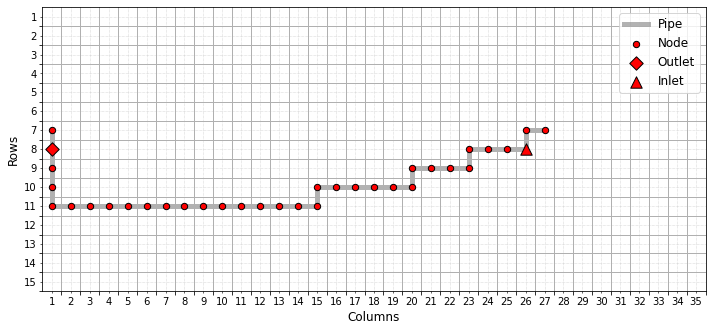

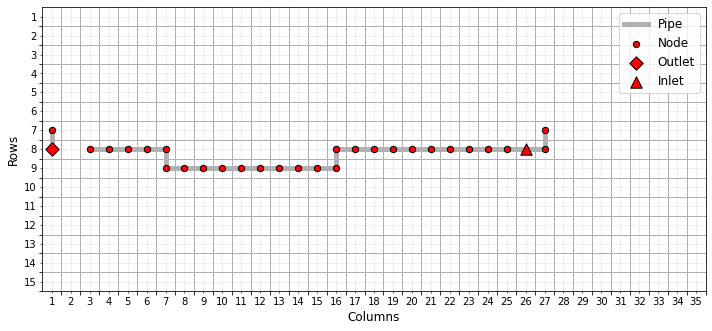

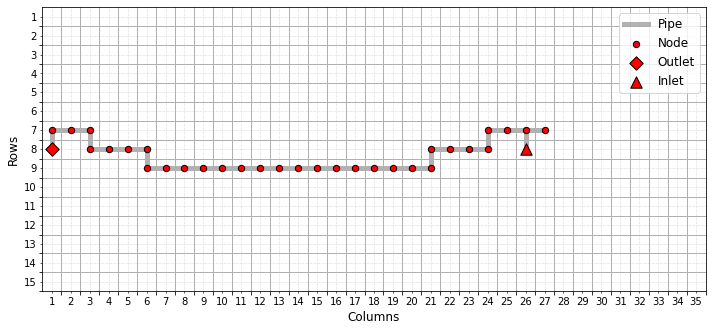

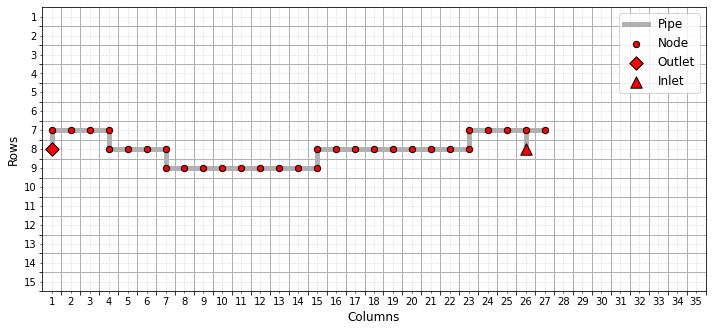

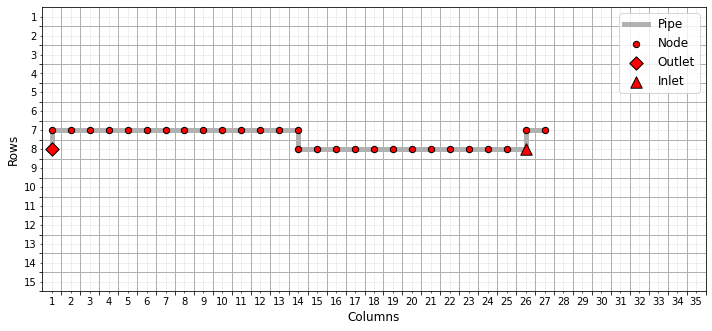

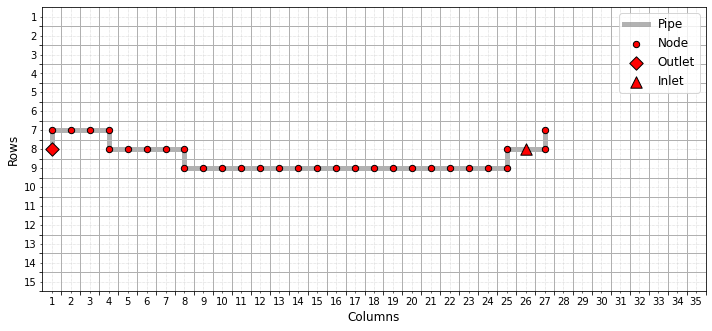

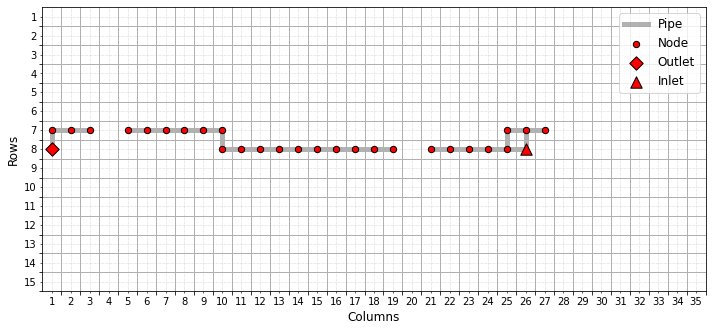

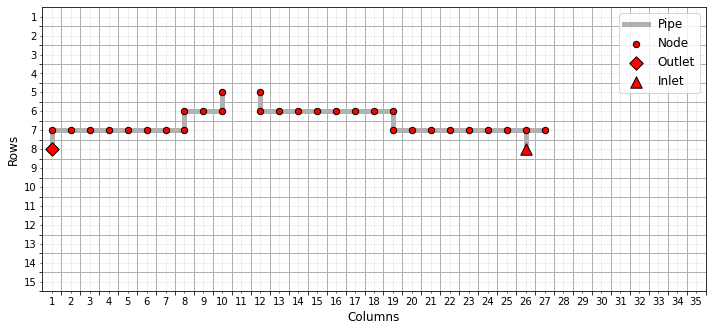

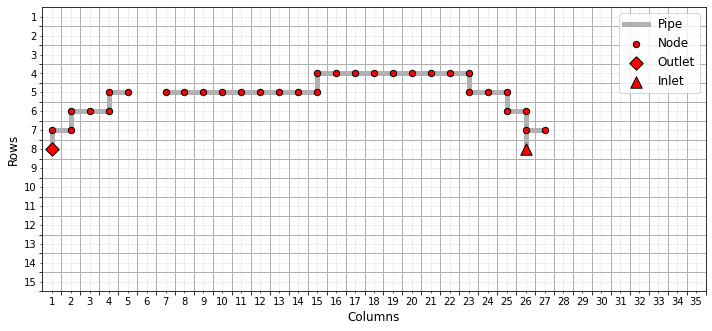

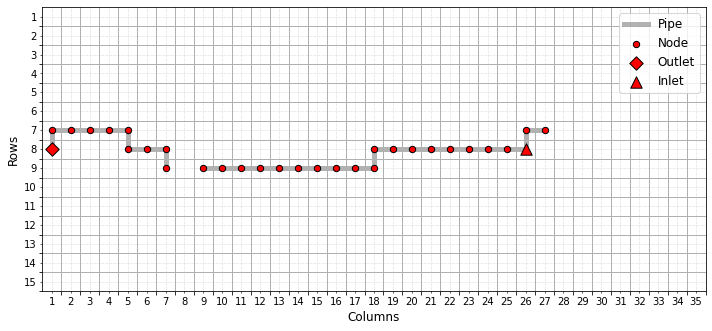

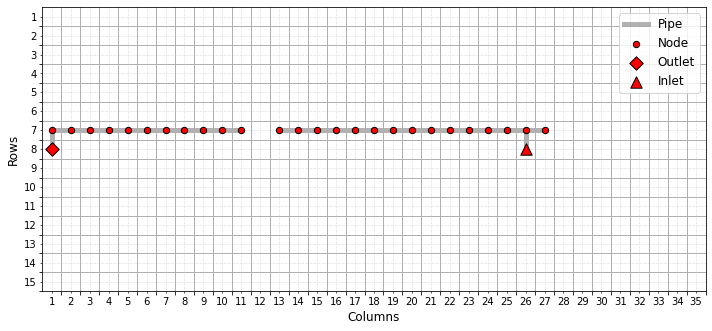

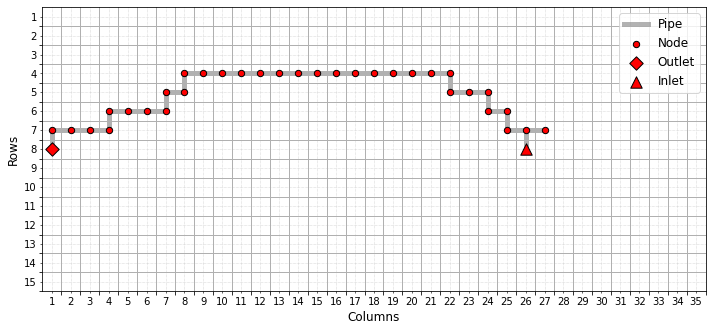

In [13]:
#First, remove previous results
clean_results()

#Initialize success counter
n_success = 0

# initialize list for unsuccessful runs
not_success = []

# Define the number of model variants
n_variants = 100 # 100

# store 9 randomly selected networks for plotting later
np.random.seed(2345678)
rnd = np.array([0, 4, 7, 8, 19, 23, 24, 26, 27]) # 11, 12
rnd_ = np.reshape(rnd, (3, 3))
networks_plot = []

for i in range(n_variants):
    print("Running model variant ", i)
    # Generate the continuum
    mf.write_input()
    
    #GENERATE THE CFP Model
    validator, valid_network = create_network()
    create_nbr(validator)
    #nbr_data, cond_elev = read_nbr()
    nbr_data, elevs = read_nbr()
    pipe_data = create_pipe_data(nbr_data[5])
    node_data = create_node_data(nbr_data[0], nbr_data[2])
    kex_data = create_kex_data(nbr_data[0])
    cads_data = create_cads_data(nbr_data[0])
    cfp = init_cfp_module(nbr_data, elevs[1], pipe_data, node_data, kex_data, cads_data)
    #cfp = init_cfp_module(nbr_data, cond_elev, pipe_data, node_data, kex_data, cads_data)
    coc = init_coc_module(nbr_data[0], nbr_data[5])
    crch = init_crch_module(nbr_data[0])
    input_files = cfp_write_input(coc, crch, cfp)

    #UPDATE THE NAME FILE
    nam = cfp_update_nam()
    
    #RUN THE MODEL
    success, buff = mf.run_model(silent=False)
    
    if success:      
        n_success = n_success + 1
        network = cfpy.plots.Network(elevs=elevs, nbr_data=nbr_data)
        networks_plot.append(network)
        plot_network(network, i)
        store_results(i)
    else:
        not_success.append(i)
        
print('Computational loop finished for ', n_variants, ' variants. ', n_success, 'variants solved successfully.')
print('Variants with unsuccessful runs: {}'.format(not_success))

## 3 Post-Processing
Process some of the computed data

### 3.1 Read hydraulic heads


In [14]:
# get all dictionaries with results
run_dirs = glob.glob(os.path.join(path, "run_*"))

# sort in place
run_dirs.sort()

head_list = []
budget_list = []
run_nums_total_head = []

for rd in run_dirs:
    print(f"Directory {rd}")
    run_nums_total_head.append(int(os.path.basename(os.path.normpath(rd))[4:]))
    # lst file name
    lst_file = os.path.join(rd, f"{modelname}.list")
    # read lst file
    lst = flopy.utils.MfListBudget(lst_file)
    # get budget
    budget = lst.get_data(totim=1)
    
    # hds file name
    hds_file = os.path.join(rd, f"{modelname}.hds")
    # read hds file
    hds = bf.HeadFile(hds_file)
    # get head
    head = hds.get_data(totim=1)
    # add to head list
    head_list.append(head)

total_head = np.concatenate(head_list)    

Directory C:\Users\MRudolph\Documents\GitHub\CFPy\CFPy_Examples\CFPy_EX02_RUN\run_0
   could not retrieve totime 1 from the lst file
Could not find specified condition.
  kstpkper = None
  totim = 1
Directory C:\Users\MRudolph\Documents\GitHub\CFPy\CFPy_Examples\CFPy_EX02_RUN\run_1
   could not retrieve totime 1 from the lst file
Could not find specified condition.
  kstpkper = None
  totim = 1
Directory C:\Users\MRudolph\Documents\GitHub\CFPy\CFPy_Examples\CFPy_EX02_RUN\run_10
   could not retrieve totime 1 from the lst file
Could not find specified condition.
  kstpkper = None
  totim = 1
Directory C:\Users\MRudolph\Documents\GitHub\CFPy\CFPy_Examples\CFPy_EX02_RUN\run_11
   could not retrieve totime 1 from the lst file
Could not find specified condition.
  kstpkper = None
  totim = 1
Directory C:\Users\MRudolph\Documents\GitHub\CFPy\CFPy_Examples\CFPy_EX02_RUN\run_12
   could not retrieve totime 1 from the lst file
Could not find specified condition.
  kstpkper = None
  totim = 1
Di

### 3.2 Plot exemplary head

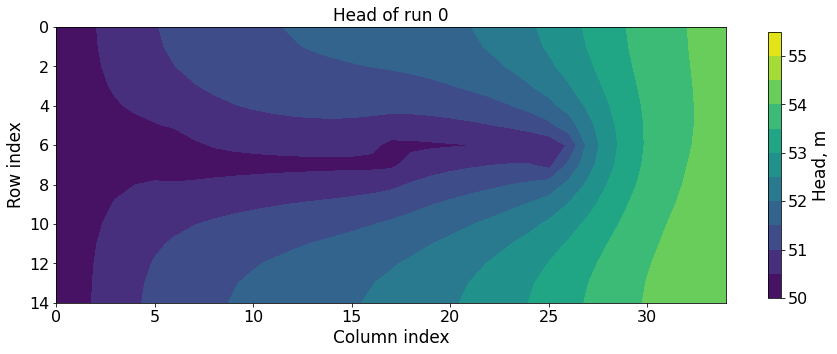

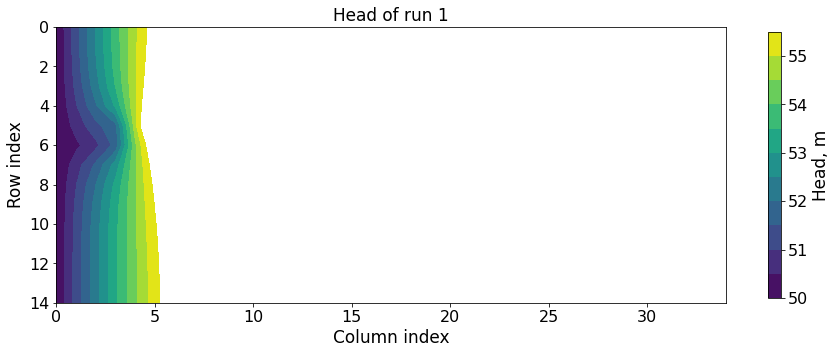

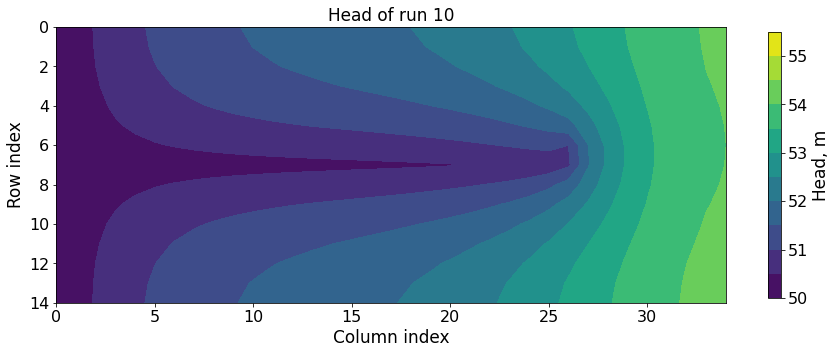

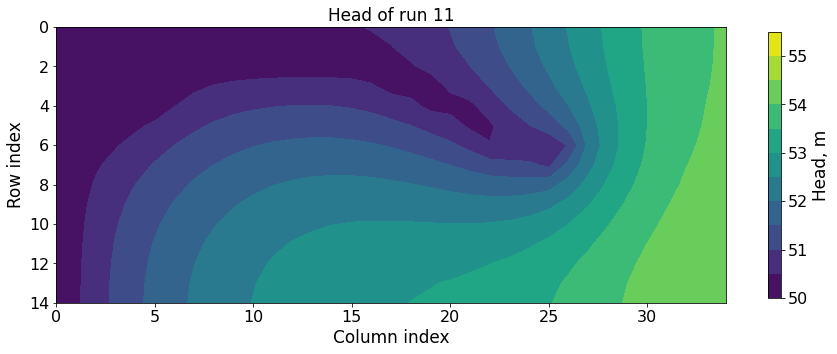

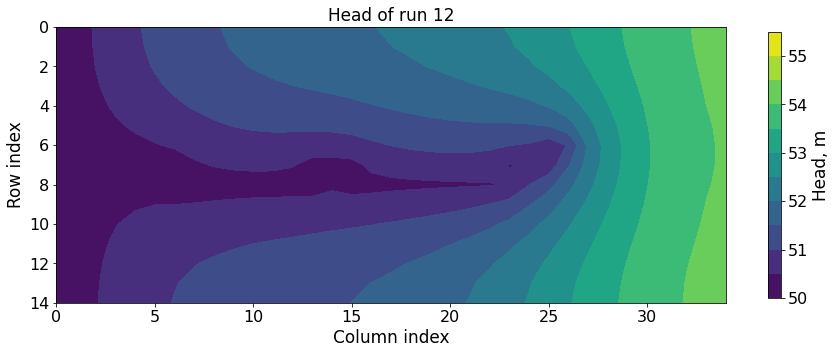

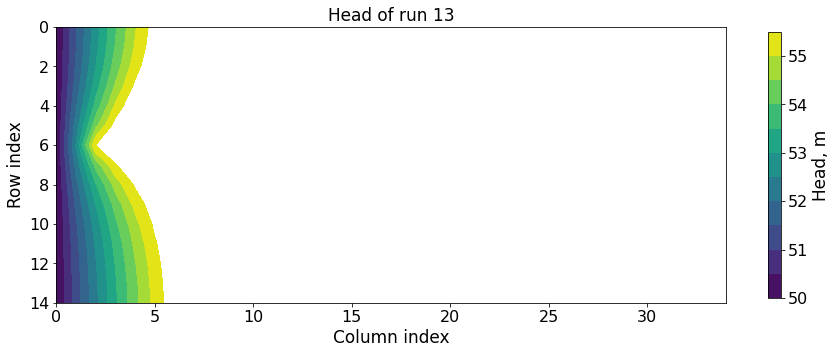

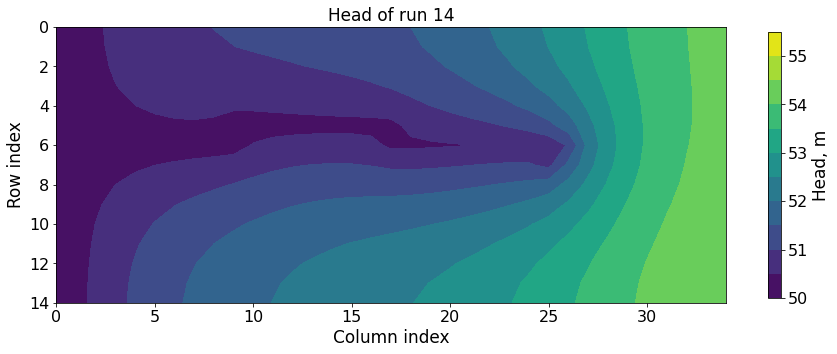

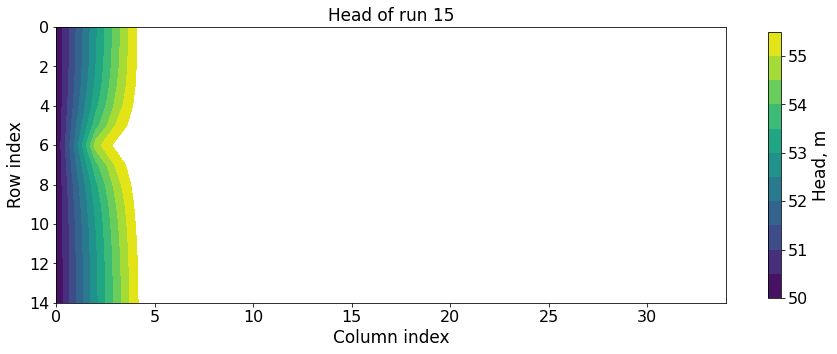

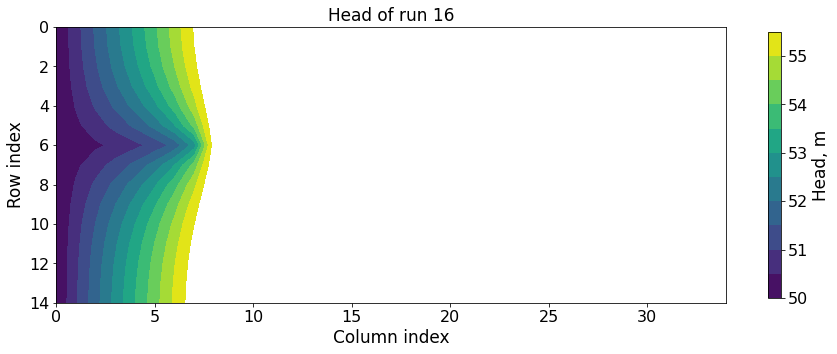

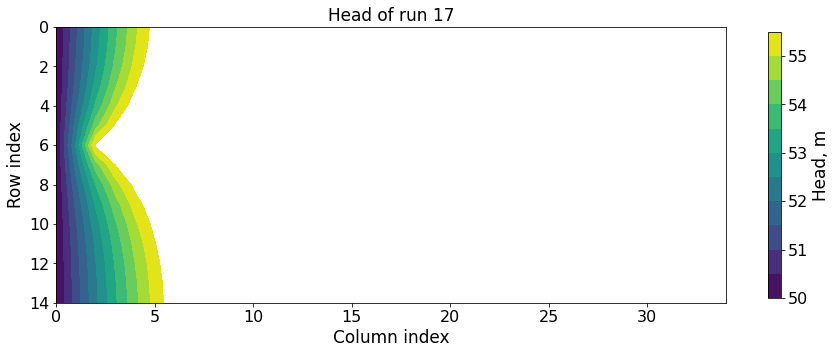

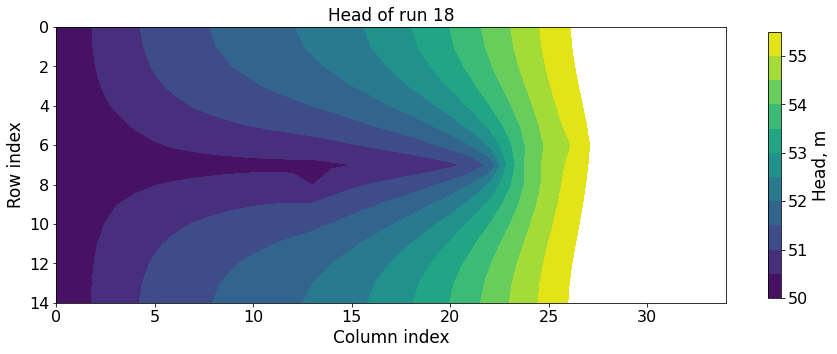

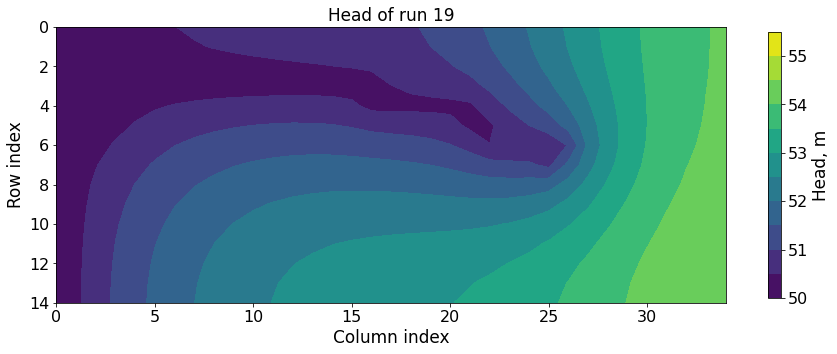

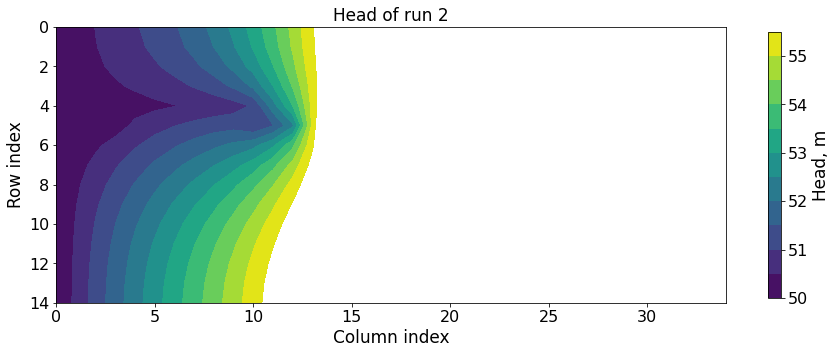

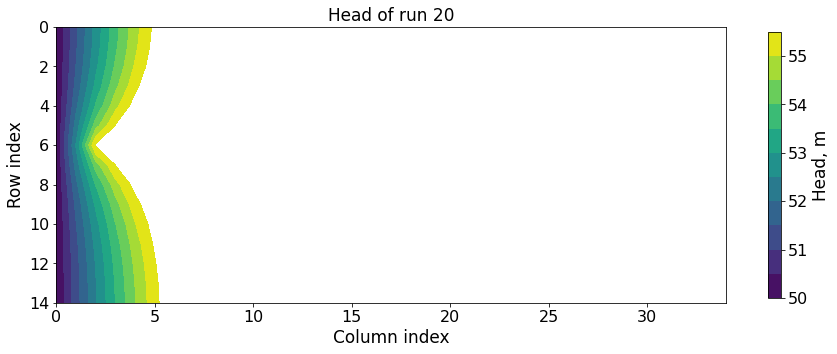

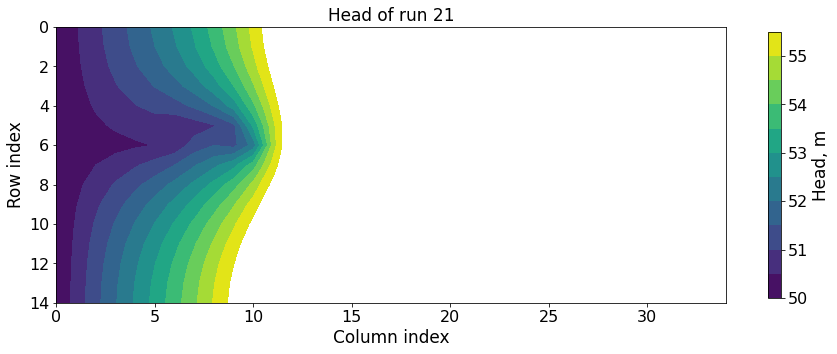

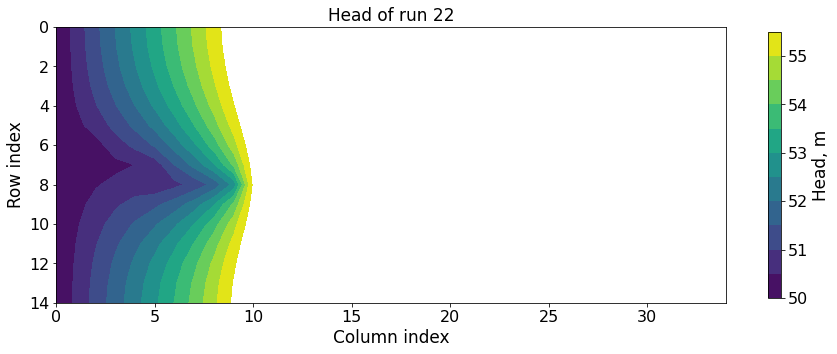

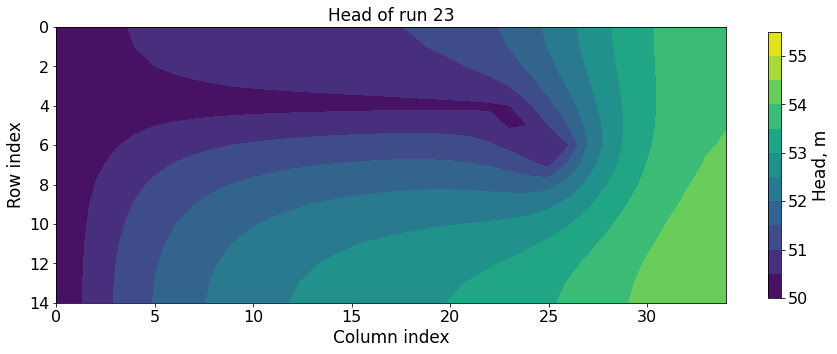

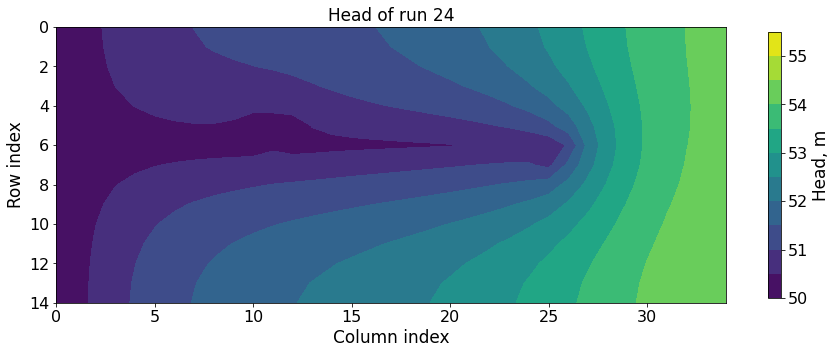

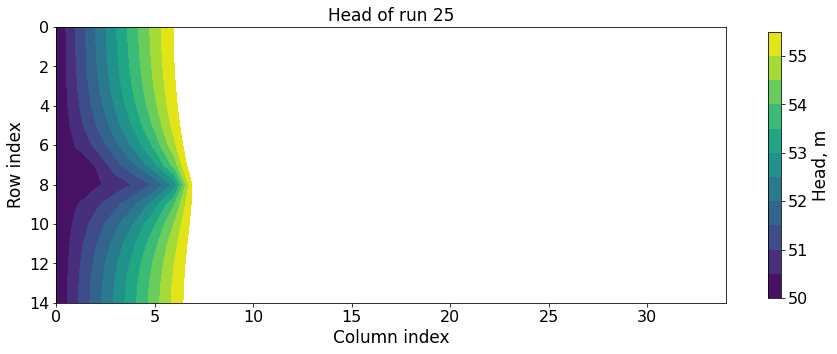

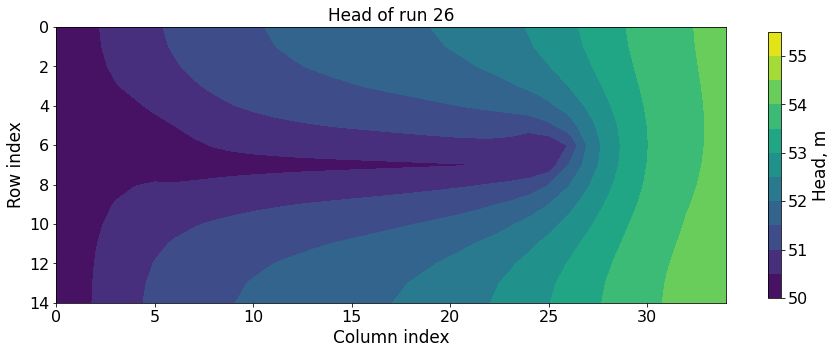

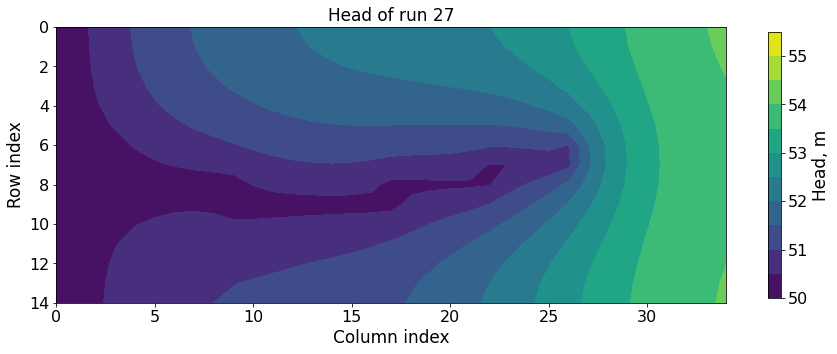

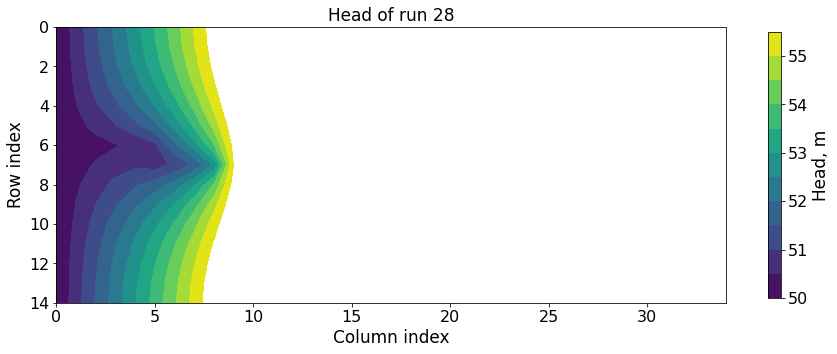

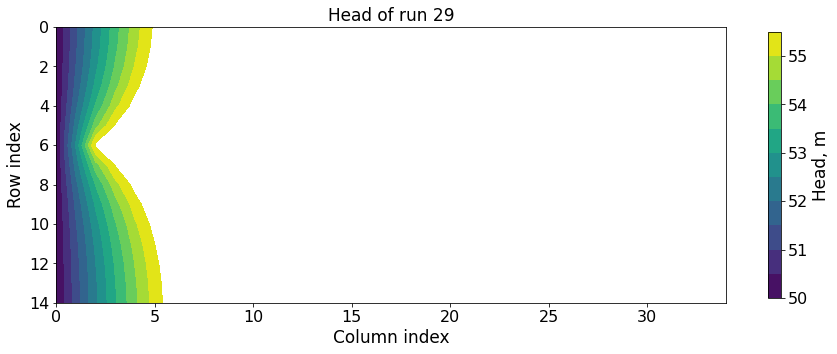

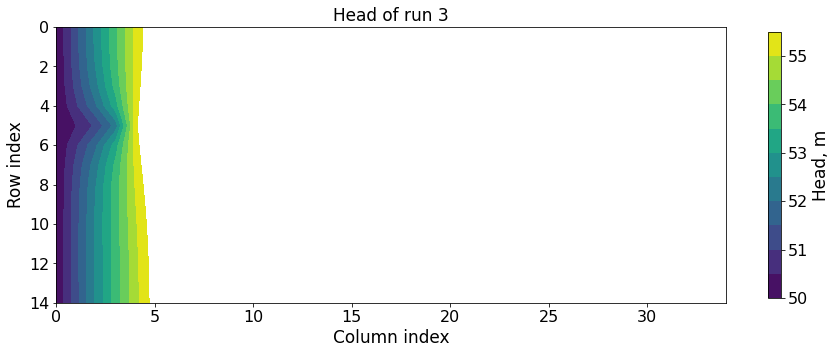

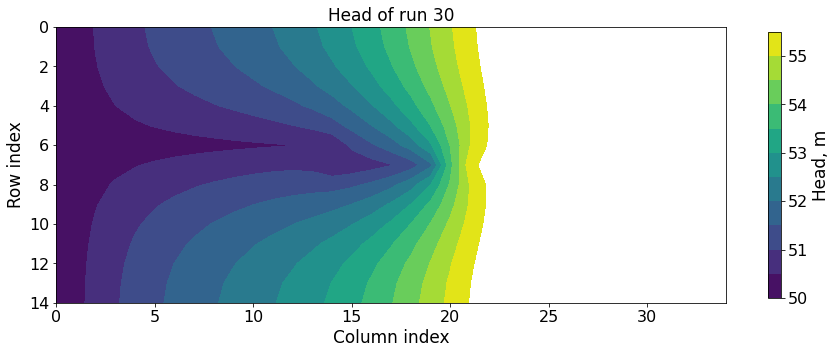

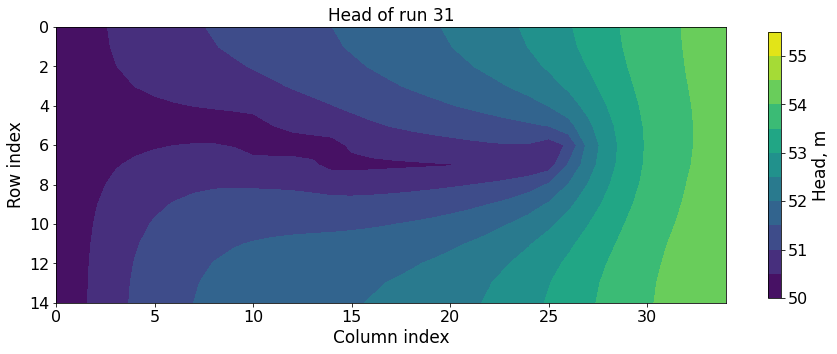

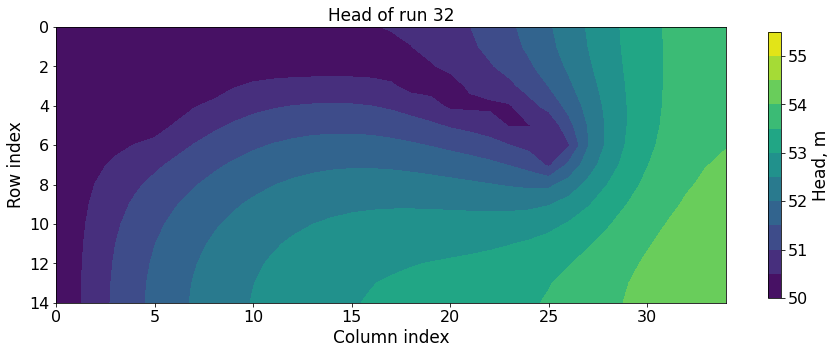

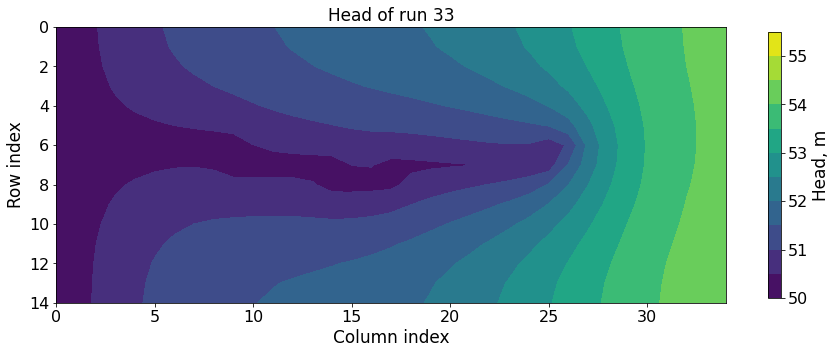

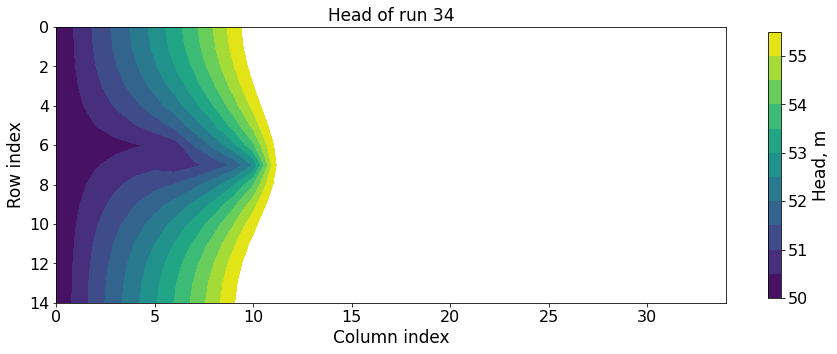

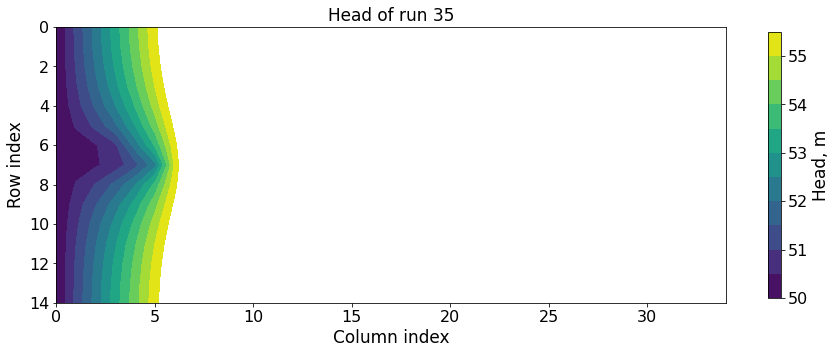

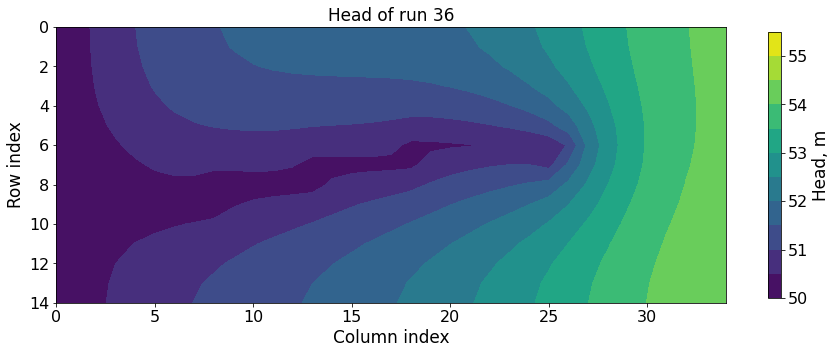

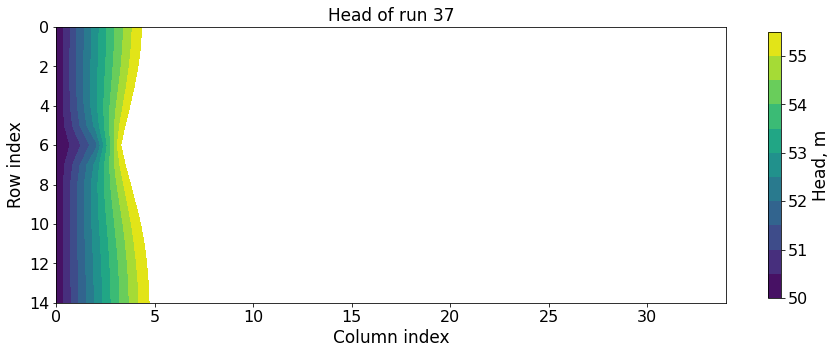

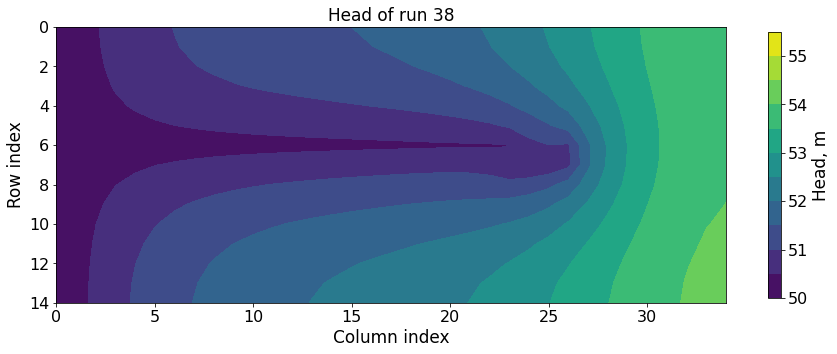

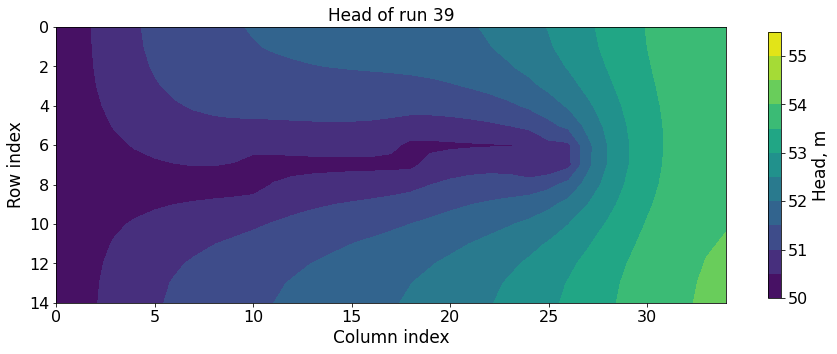

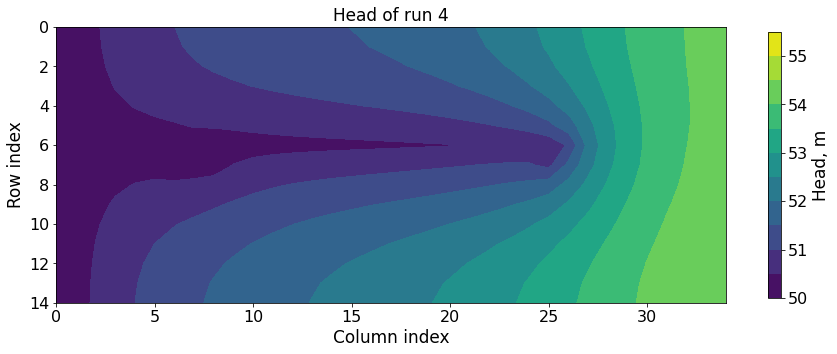

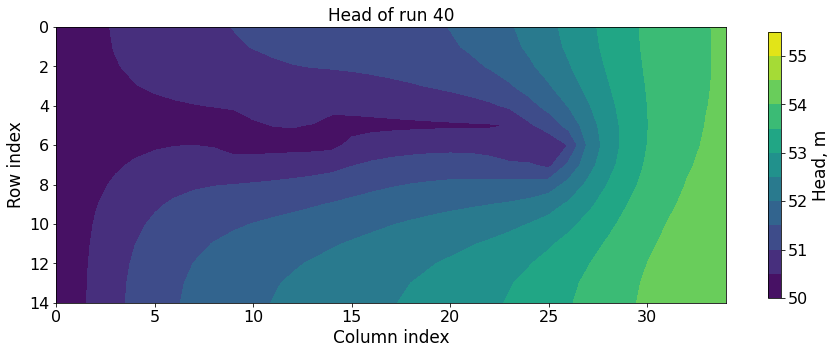

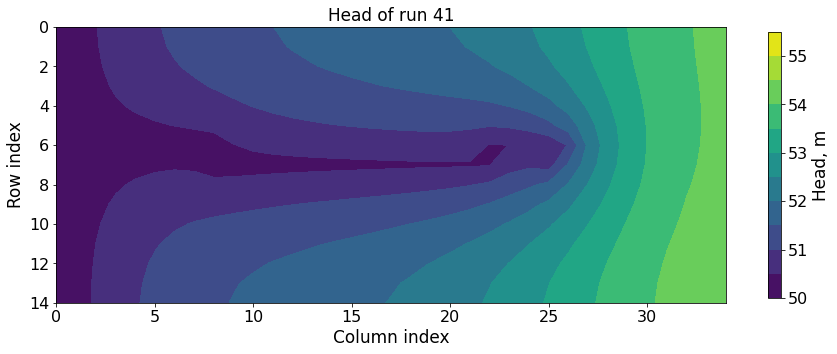

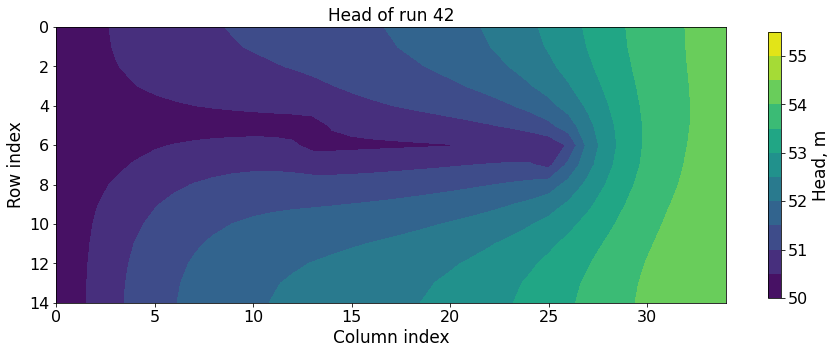

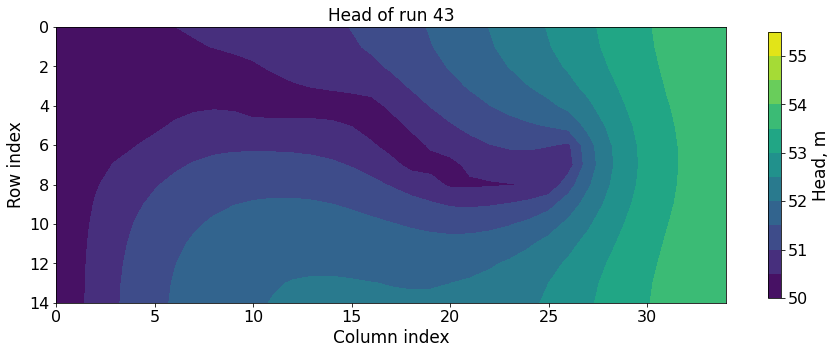

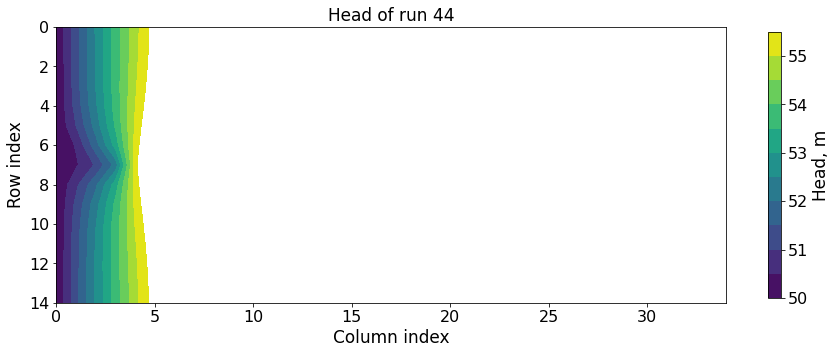

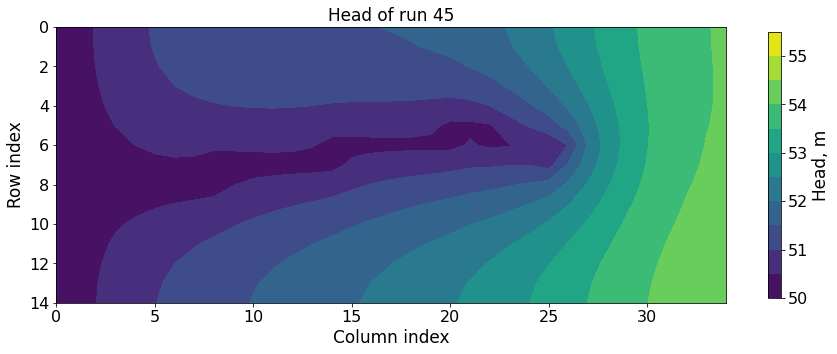

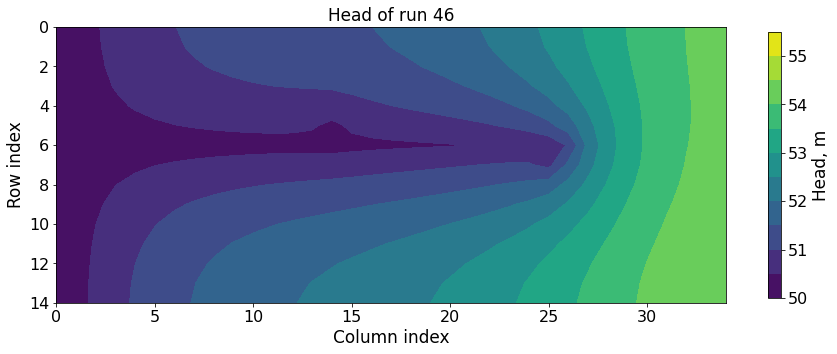

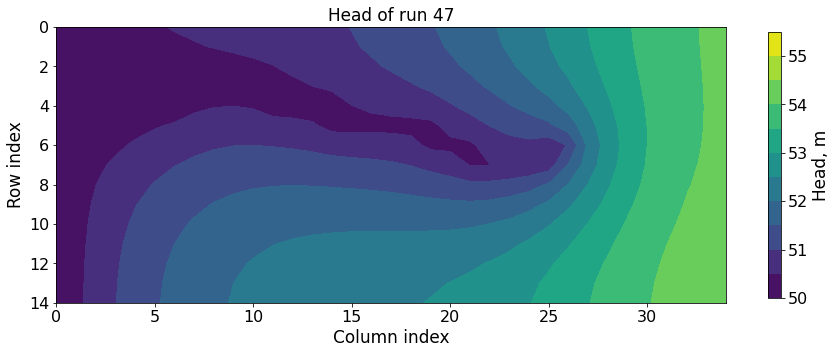

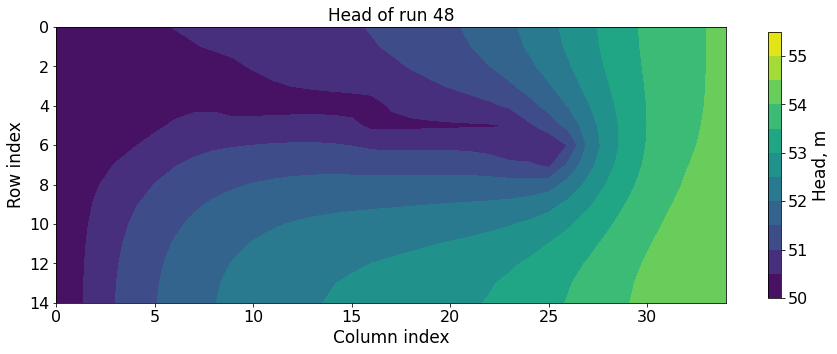

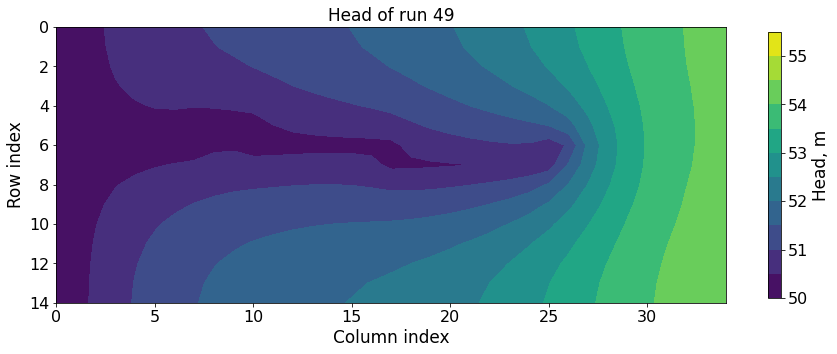

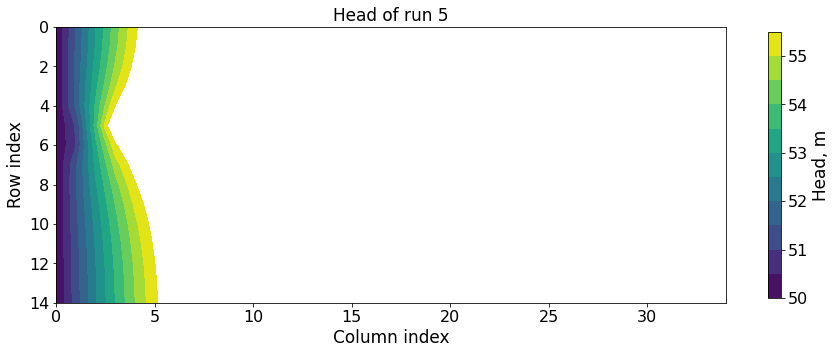

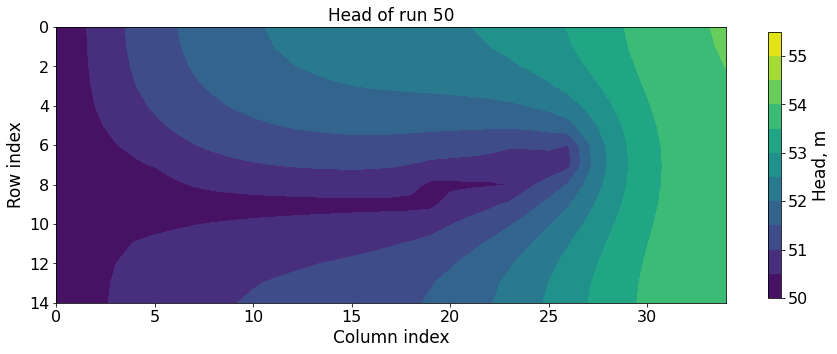

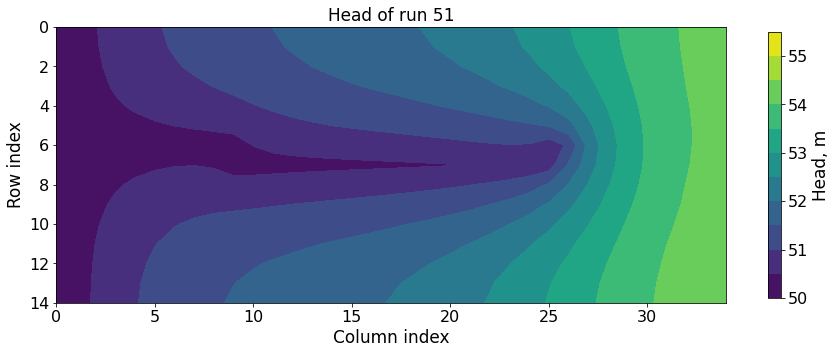

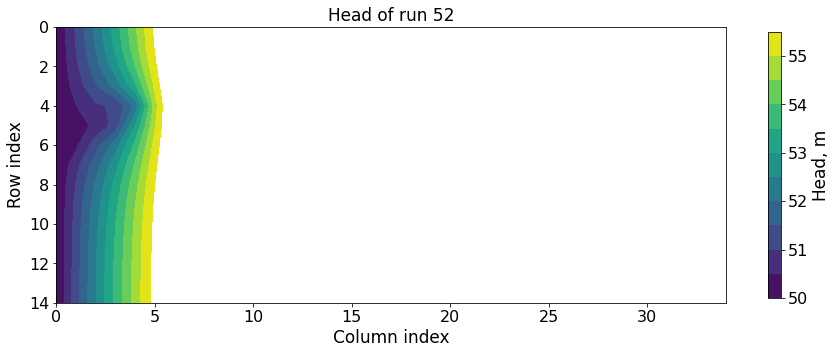

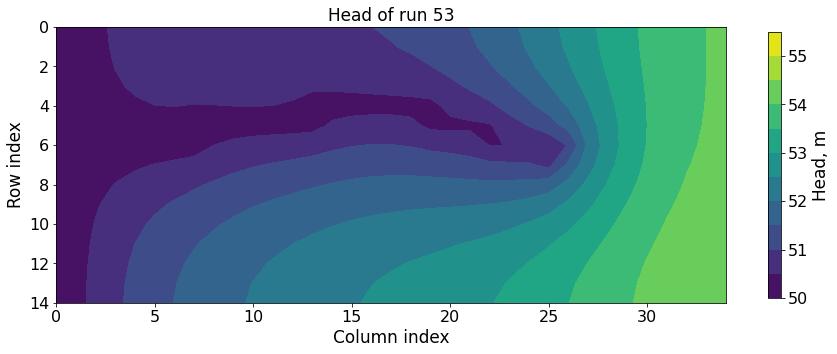

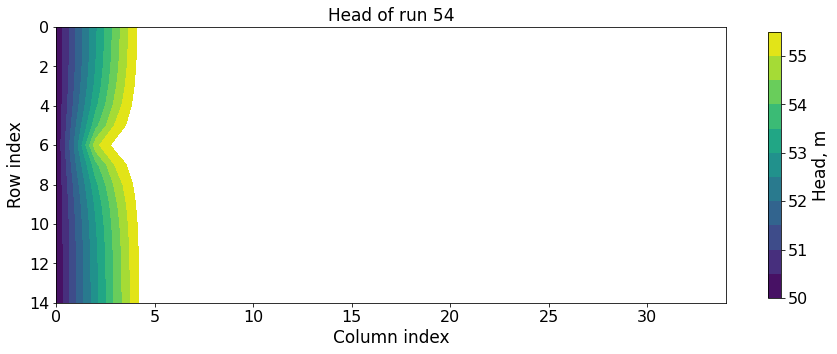

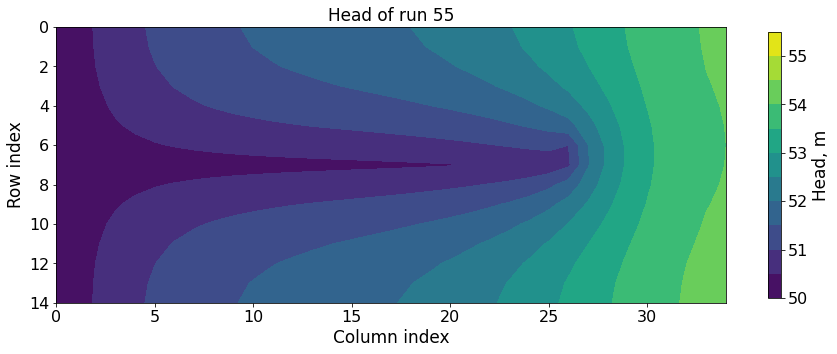

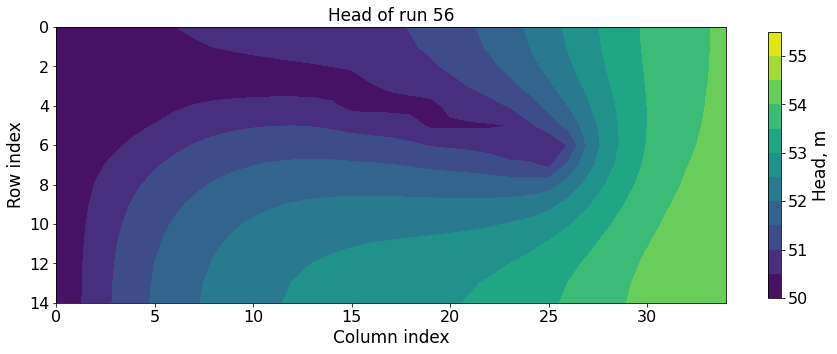

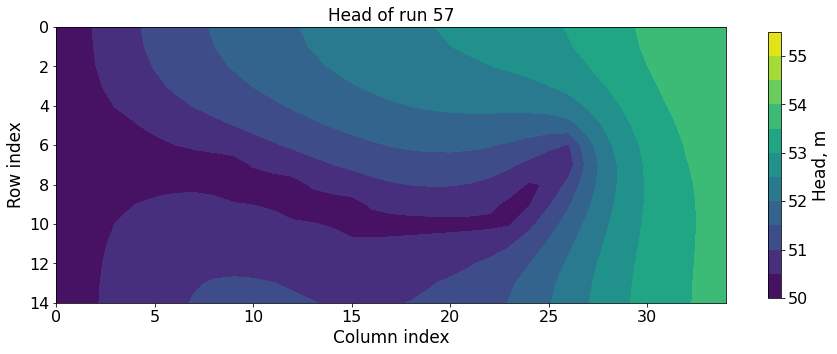

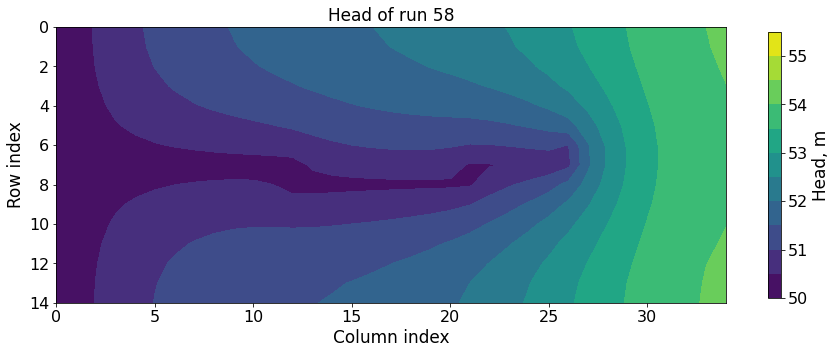

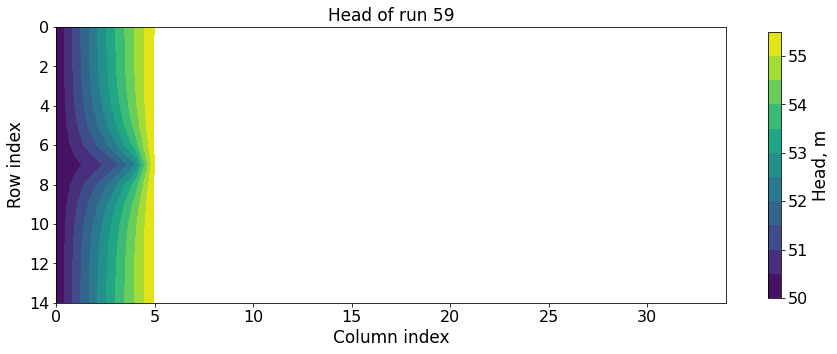

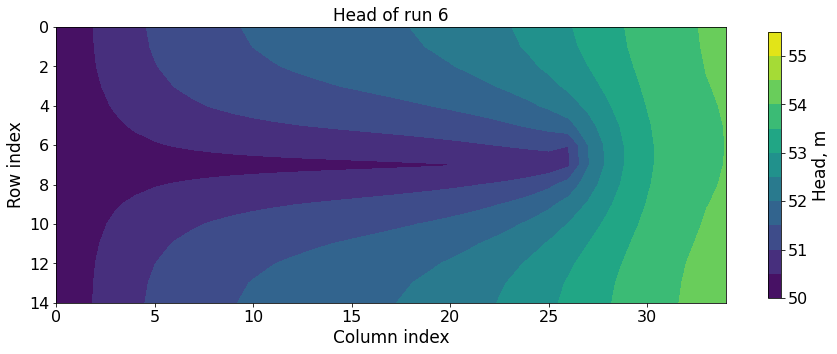

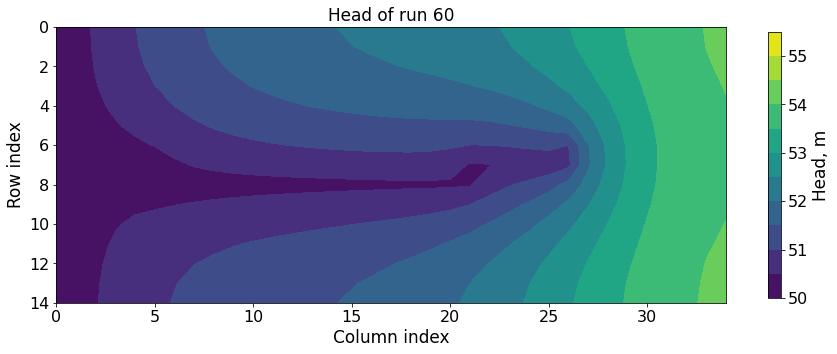

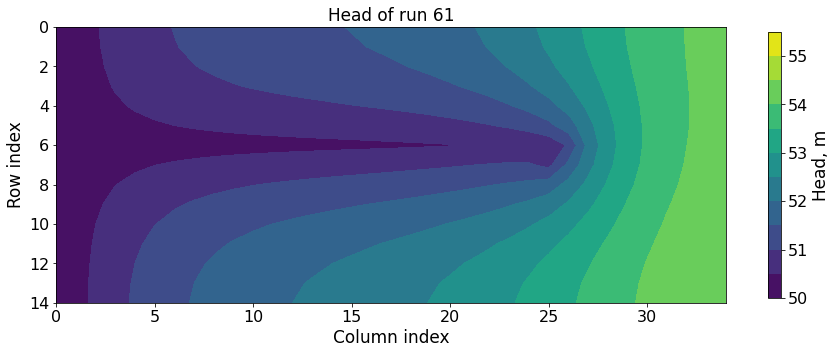

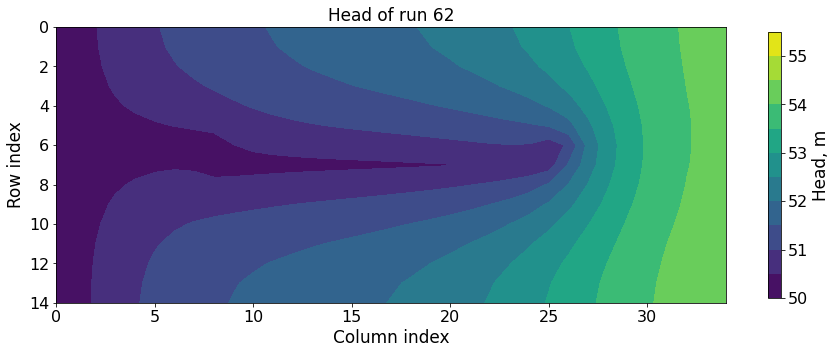

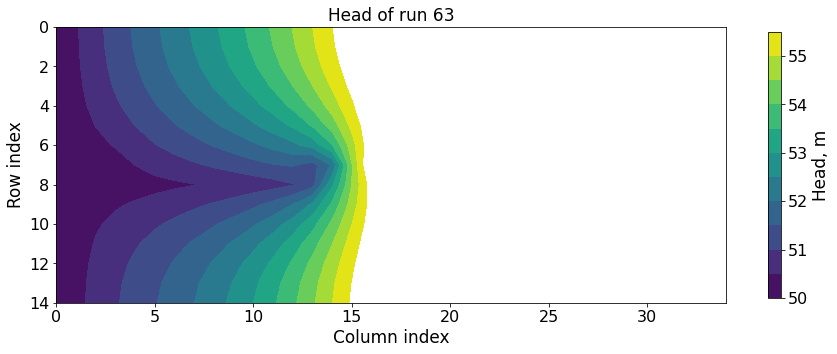

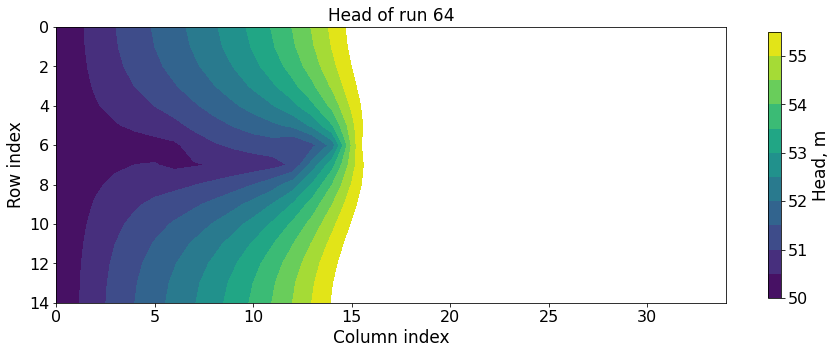

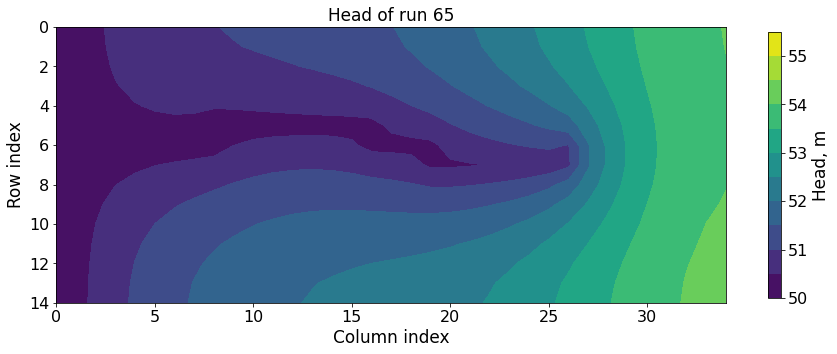

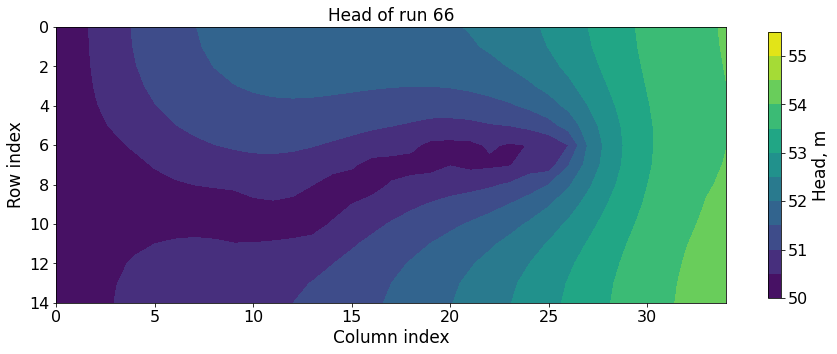

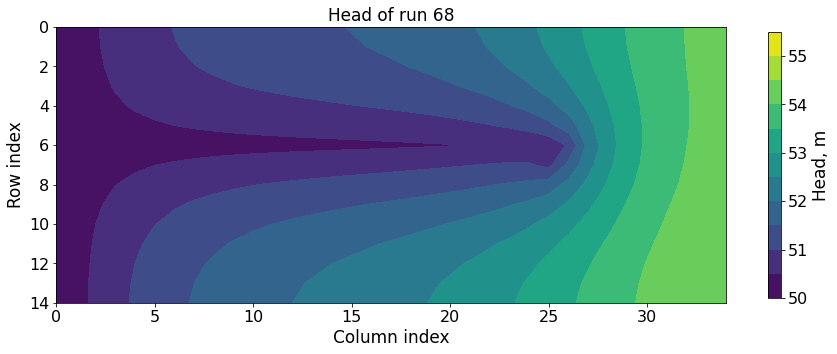

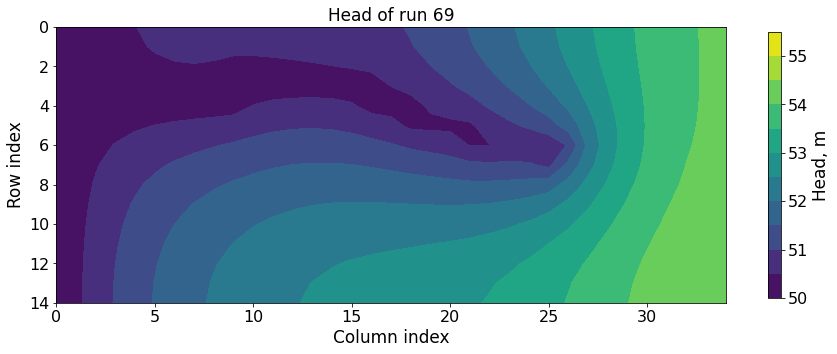

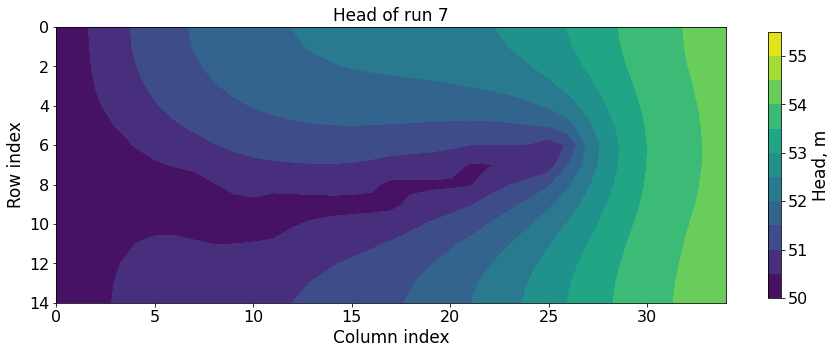

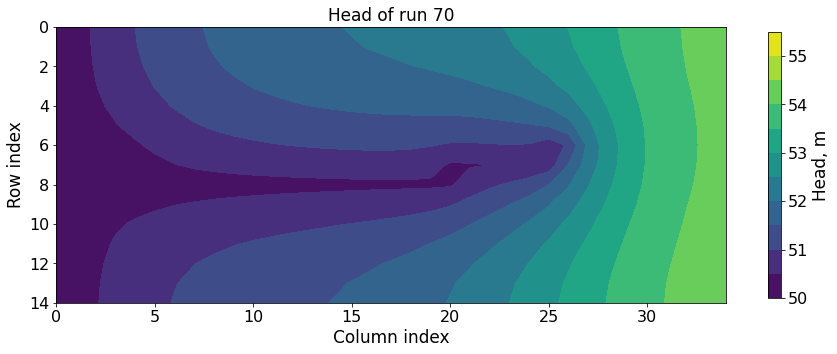

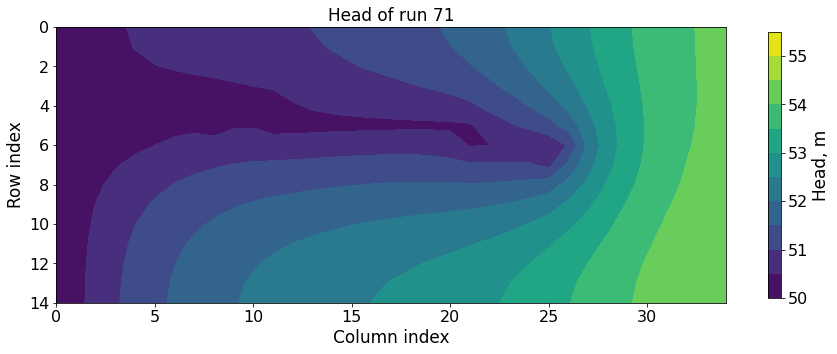

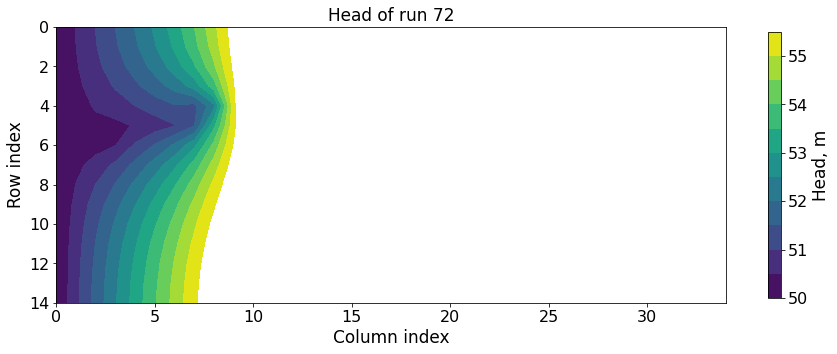

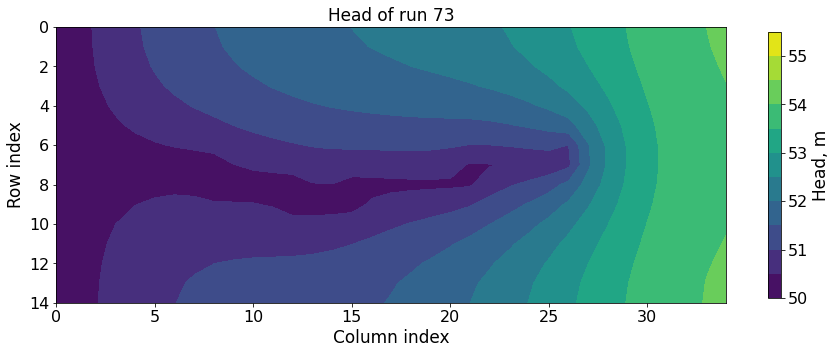

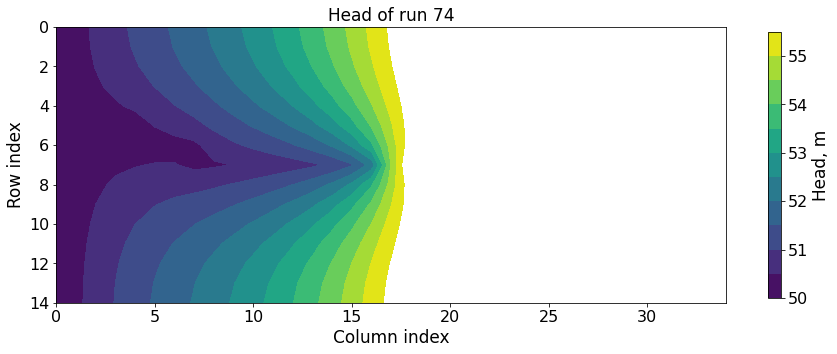

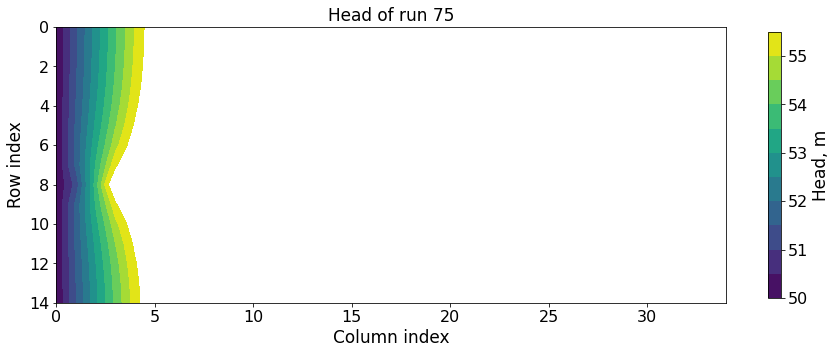

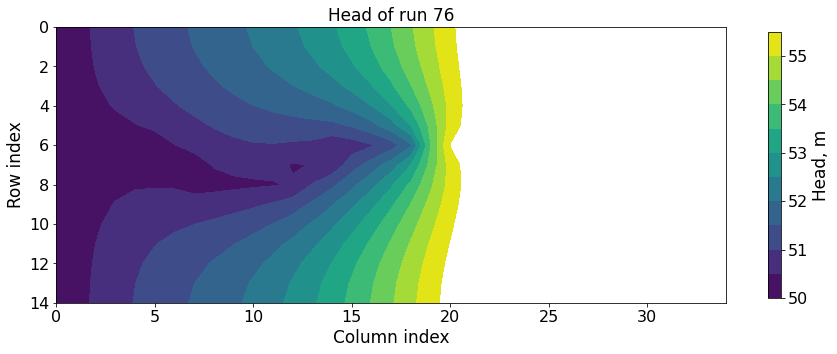

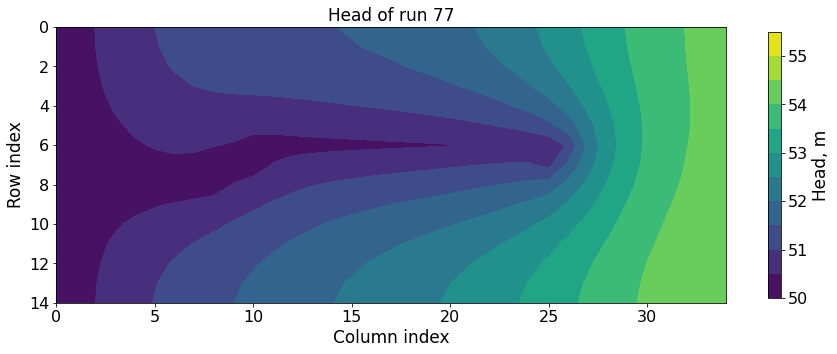

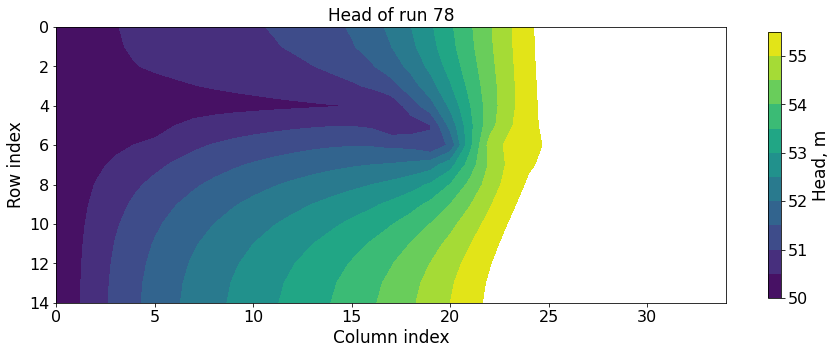

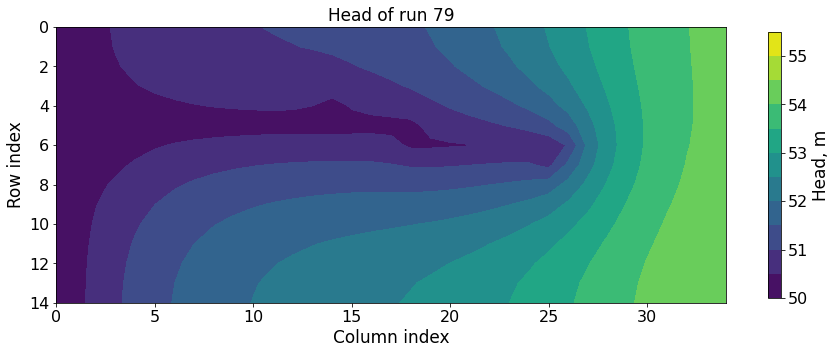

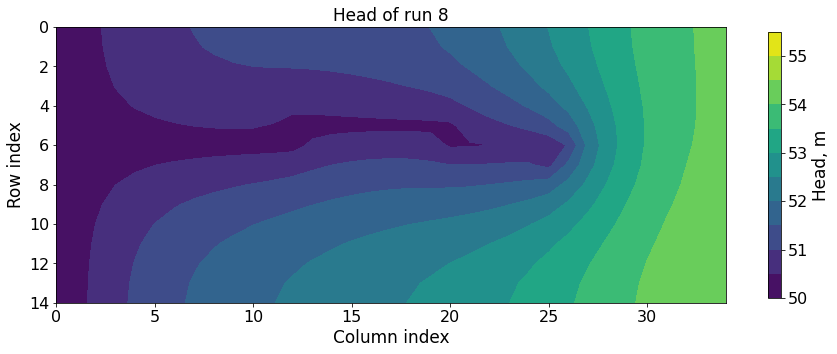

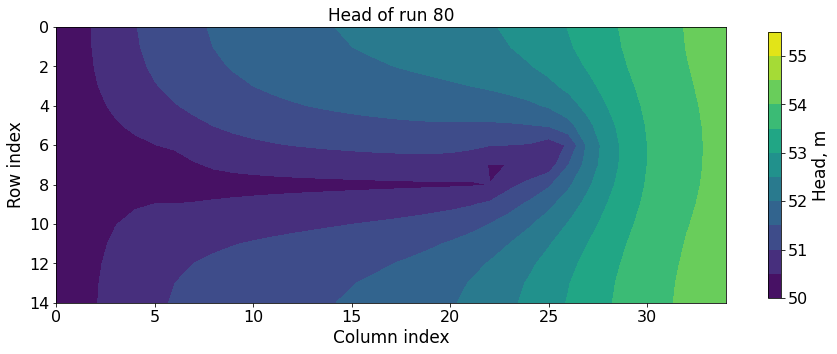

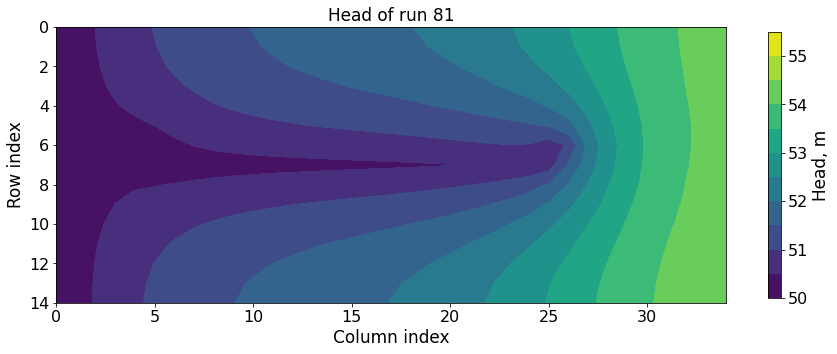

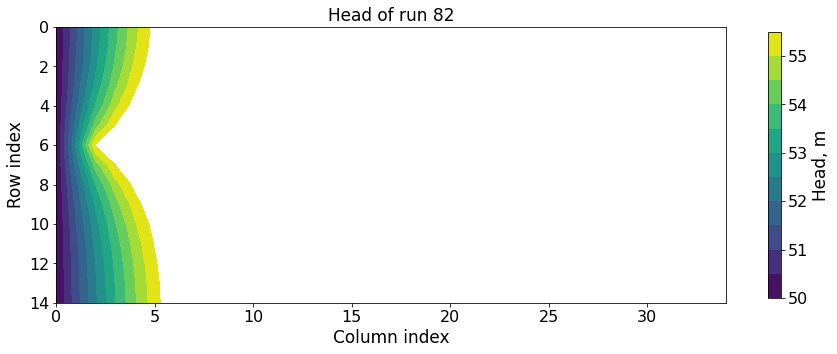

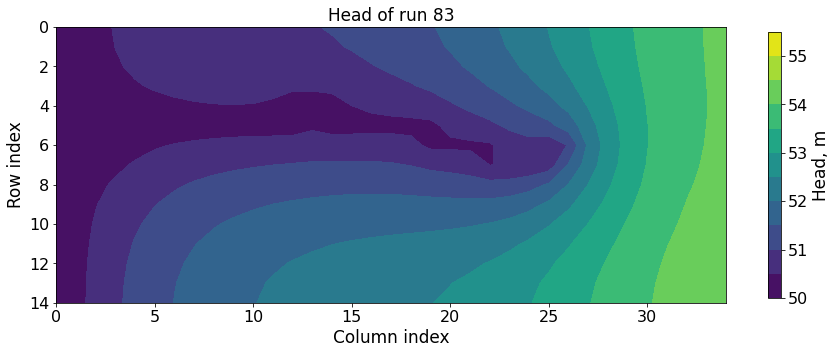

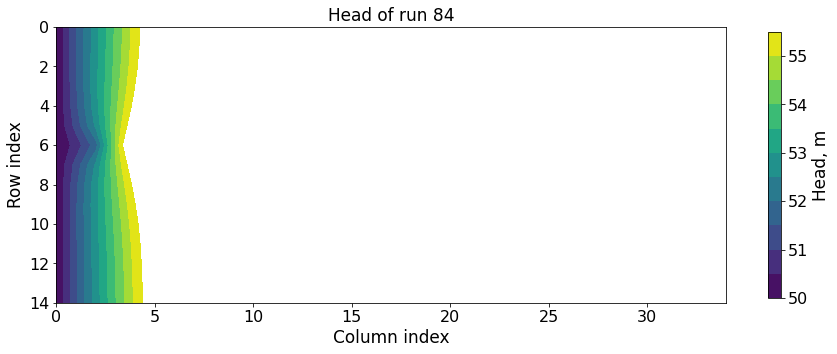

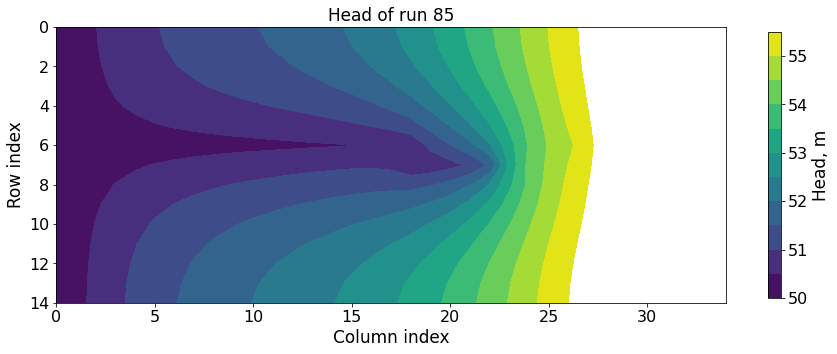

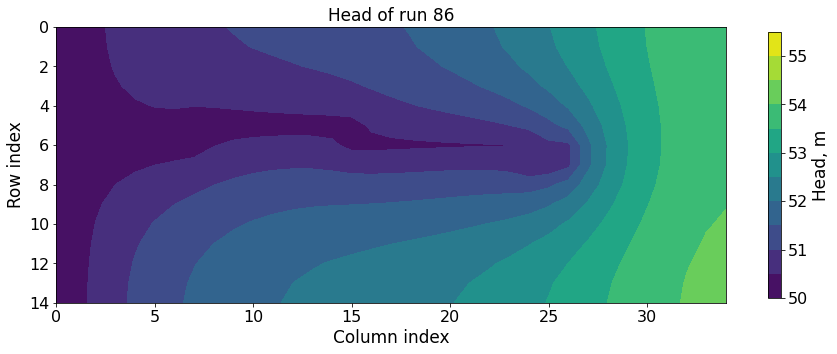

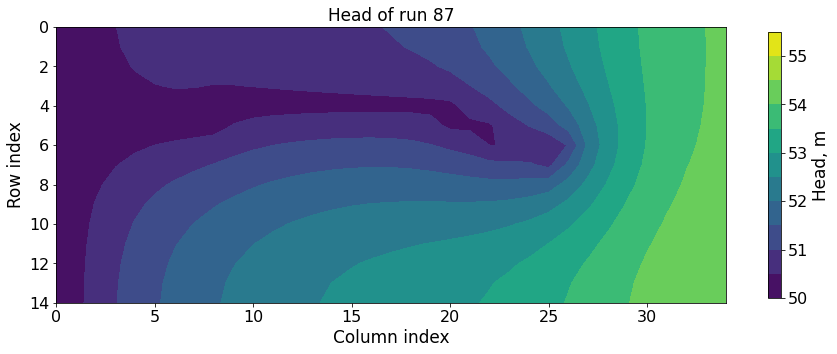

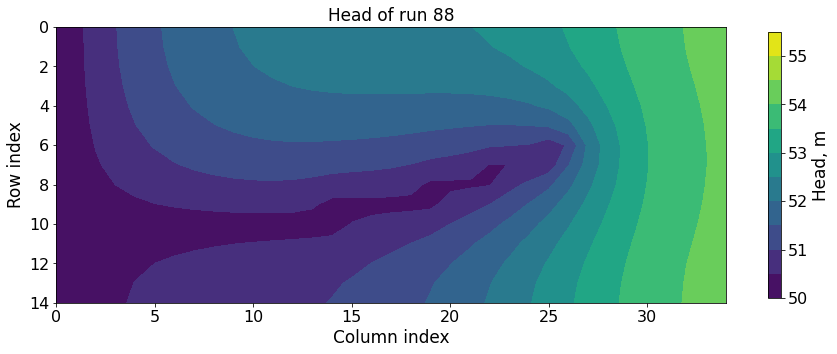

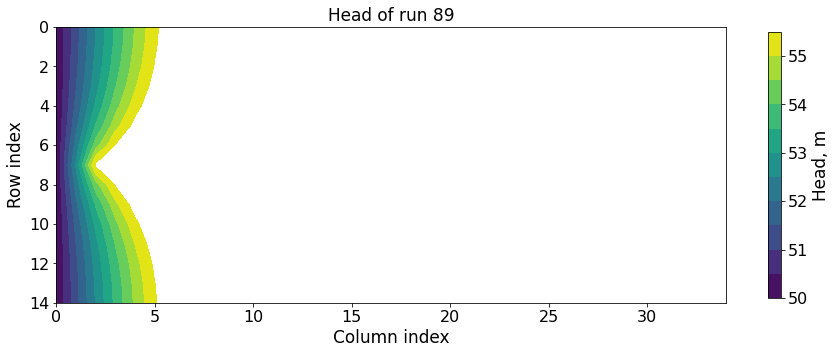

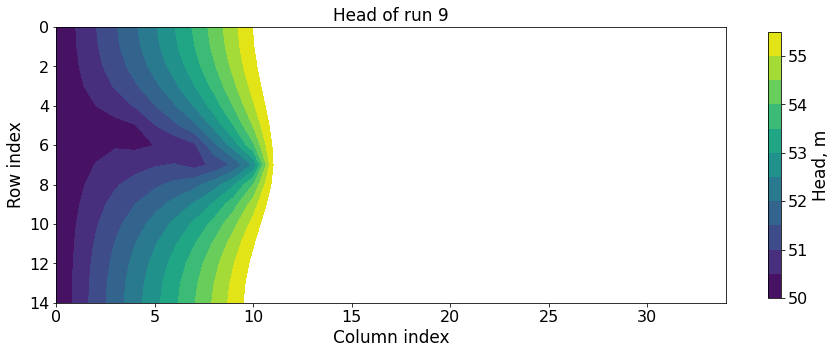

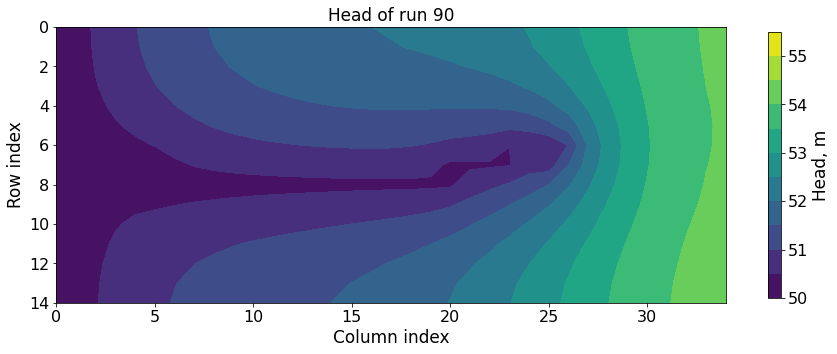

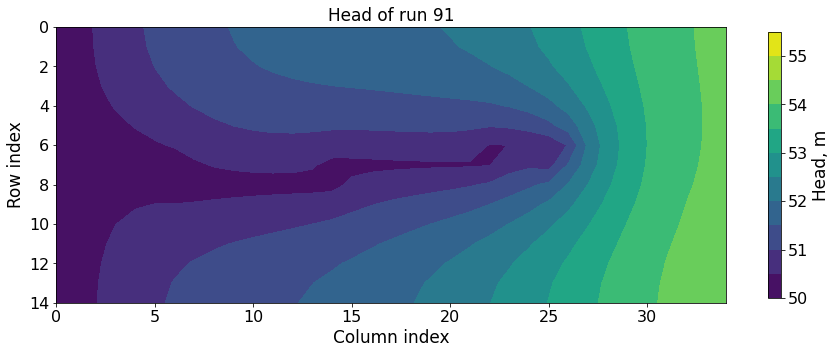

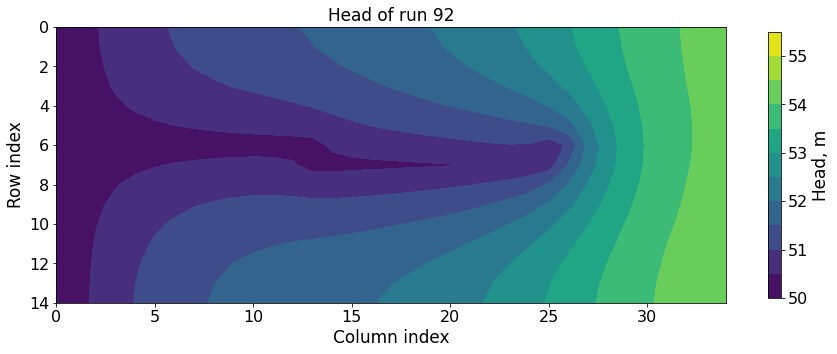

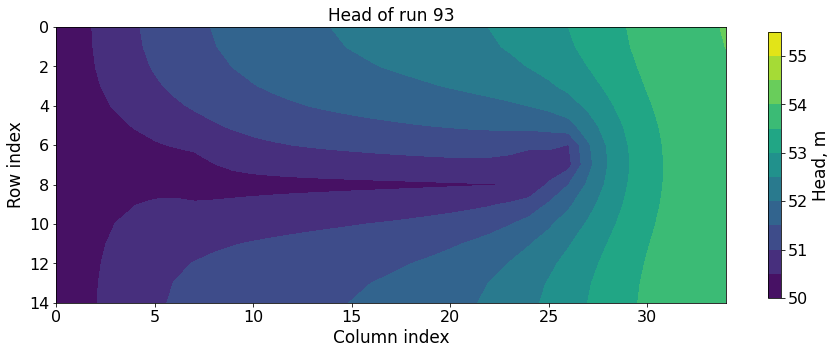

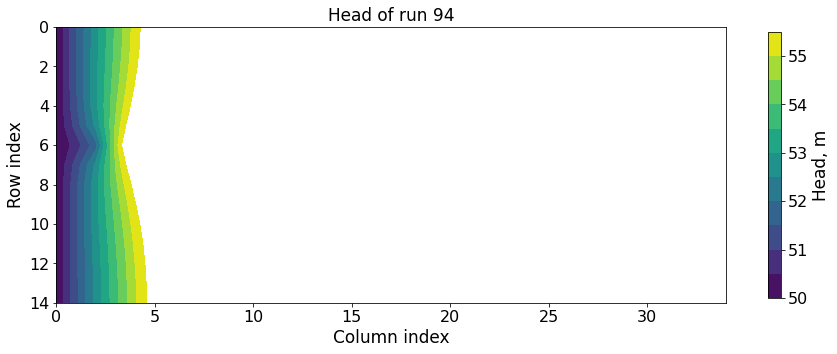

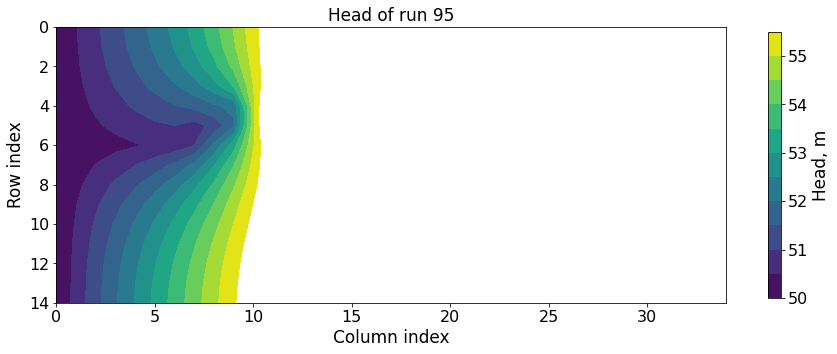

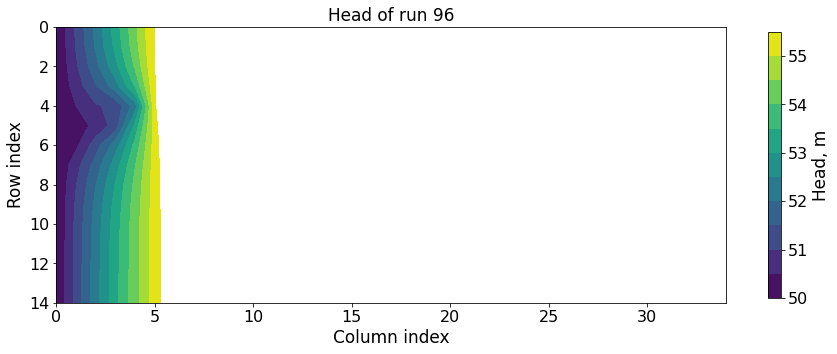

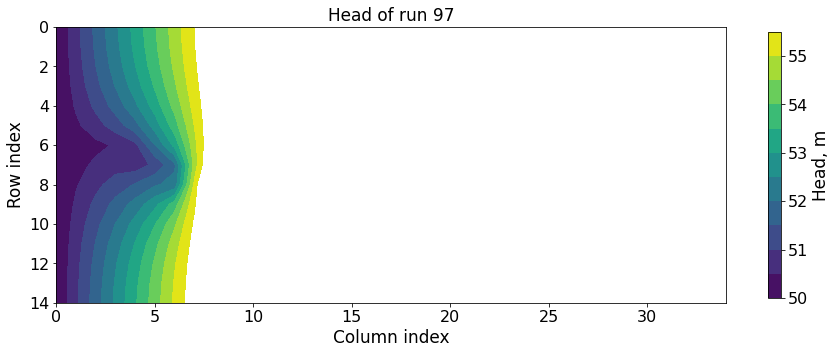

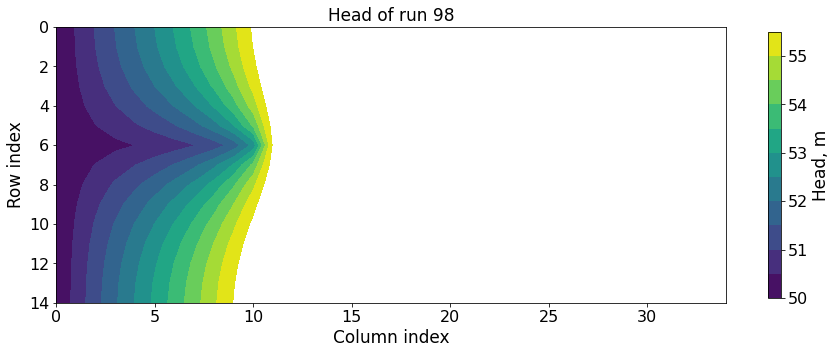

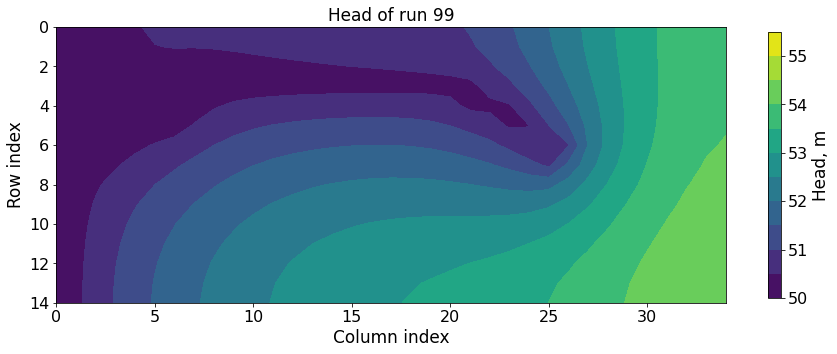

In [15]:
path = os.getcwd()
target_dir = os.path.join(path, 'FIGS', 'Matrix_Heads')

if os.path.exists(target_dir):
    shutil.rmtree(target_dir)
os.makedirs(target_dir)

for run_idx in range(total_head.shape[0]):
    run_number = run_dirs[run_idx].replace(os.path.join(path, "run_"), "")
    
    fig = plt.figure(figsize=(15, 7))
    ax = fig.add_subplot(1, 1, 1, aspect="equal")
    
    # NOTE: (regarding the head data appearing "mirrored" in the plot)
    #     the plt.contourf function makes a plot where the order of the
    #     elements along the vertical axis is reversed.
    #     to circumvent this, np.flipud(heads) is used to reverse the
    #     ordering beforehand, resulting in a correct representation.
    
    im = ax.contourf(total_head[run_idx,:,:], 
                     #levels=np.linspace(np.min(total_head[run_idx,:,:]), np.max(total_head[run_idx,:,:]), 10))
                     levels=np.arange(50, 56, 0.5), cmap="viridis")
    # invert y-axis for MODFLOW-typical representation
    ax.invert_yaxis()
    cb = fig.colorbar(im, shrink=0.7)

    cb.set_label("Head, m", size=17)
    ax.set_title(f"Head of run {run_number}", size=17) #{np.sum(success_runs)}
    ax.set_xlabel("Column index", size=17)
    ax.set_ylabel("Row index", size =17)

    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    cb.ax.tick_params(labelsize=16)

    filename = f'head_{run_number}.jpg'
    abs_filename = os.path.join(target_dir, filename)

    plt.savefig(abs_filename, dpi=300)

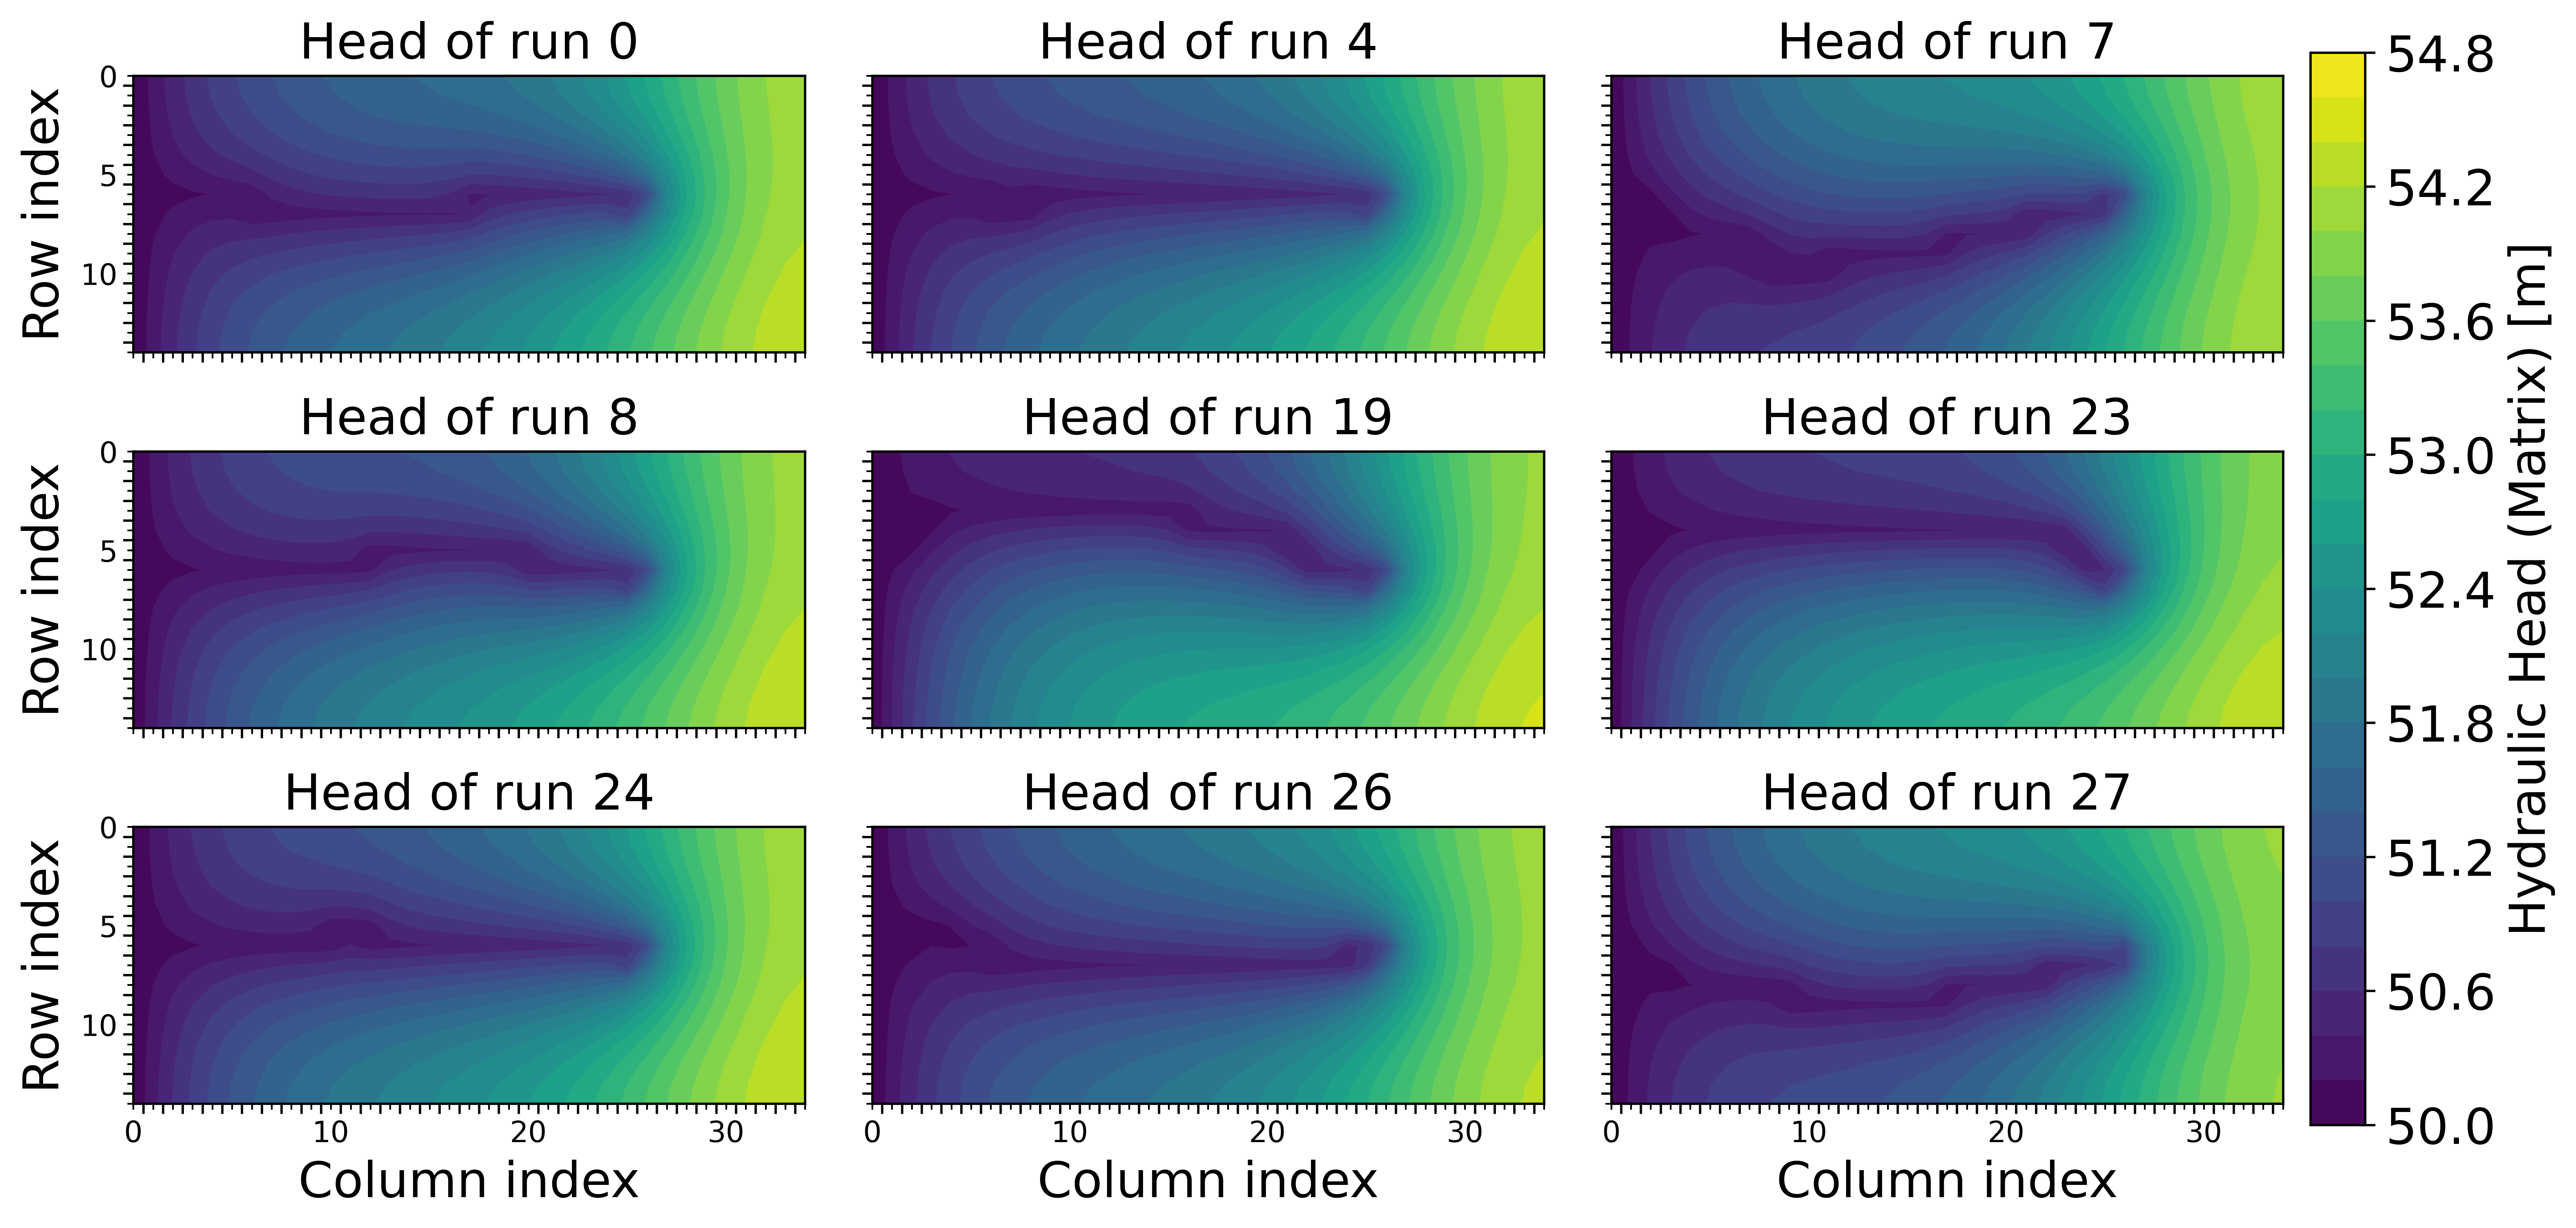

In [16]:
# plot a matrix of results for 9 randomly selected runs

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(13, 6), dpi=600, sharex=True, sharey=True)

for i in range(3):
    for j in range(3):
        
        # get correct index
        idx = run_nums_total_head.index(rnd_[i, j])
        
        im = ax[i, j].contourf(
            total_head[idx,:,:],
            levels=np.arange(50, 55, 0.2),
            cmap="viridis"
        )
        ax[i, j].invert_yaxis()
        ax[i, j].set_title(f"Head of run {rnd_[i, j]}", size=17)
        ax[i, j].set_aspect("equal")
        
        if i == 2:
            ax[i, j].set_xlabel("Column index", size=17)
        if j == 0:
            ax[i, j].set_ylabel("Row index", size =17)
            
        ax[i, j].xaxis.set_major_locator(tck.FixedLocator([i - 0.5 for i in range(n_cols)]))
        ax[i, j].yaxis.set_major_locator(tck.FixedLocator([i - 0.5 for i in range(n_rows)]))
        
        ax[i, j].xaxis.set_minor_locator(tck.FixedLocator([i for i in range(n_cols)]))
        ax[i, j].yaxis.set_minor_locator(tck.FixedLocator([i for i in range(n_rows)]))
        
        ax[i, j].tick_params(axis='both', which='minor', labelsize=10)
        ax[i, j].set_xticklabels([i for i in range(n_cols)], minor=True)
        ax[i, j].set_yticklabels([i for i in range(n_rows)], minor=True)
        ax[i, j].set_xticklabels([None for i in range(n_cols)])
        ax[i, j].set_yticklabels([None for i in range(n_rows)])
    
        ax[i, j].tick_params(axis='x', labelsize=16)
        ax[i, j].tick_params(axis='y', labelsize=16)
        
        for num, label in enumerate(ax[i, j].xaxis.get_ticklabels(which="minor")):
            label.set_visible(False)
            if num % 10 == 0:
                label.set_visible(True)
        for num, label in enumerate(ax[i, j].yaxis.get_ticklabels(which="minor")):
            label.set_visible(False)
            if num % 5 == 0:
                label.set_visible(True)
        
        # ax[i, j].set_aspect(1.5)
        
        plt.tight_layout()

plt.subplots_adjust(wspace=0.1, hspace=0.3, right=0.8)

cax = fig.add_axes([0.81, 0.095, 0.02, 0.85])
cbar = plt.colorbar(im, cax=cax)
cbar.set_label("Hydraulic Head (Matrix) [m]", fontsize=17)
cbar.ax.tick_params(labelsize=17)

plt.savefig("results_selection.png", dpi=600, bbox_inches="tight")

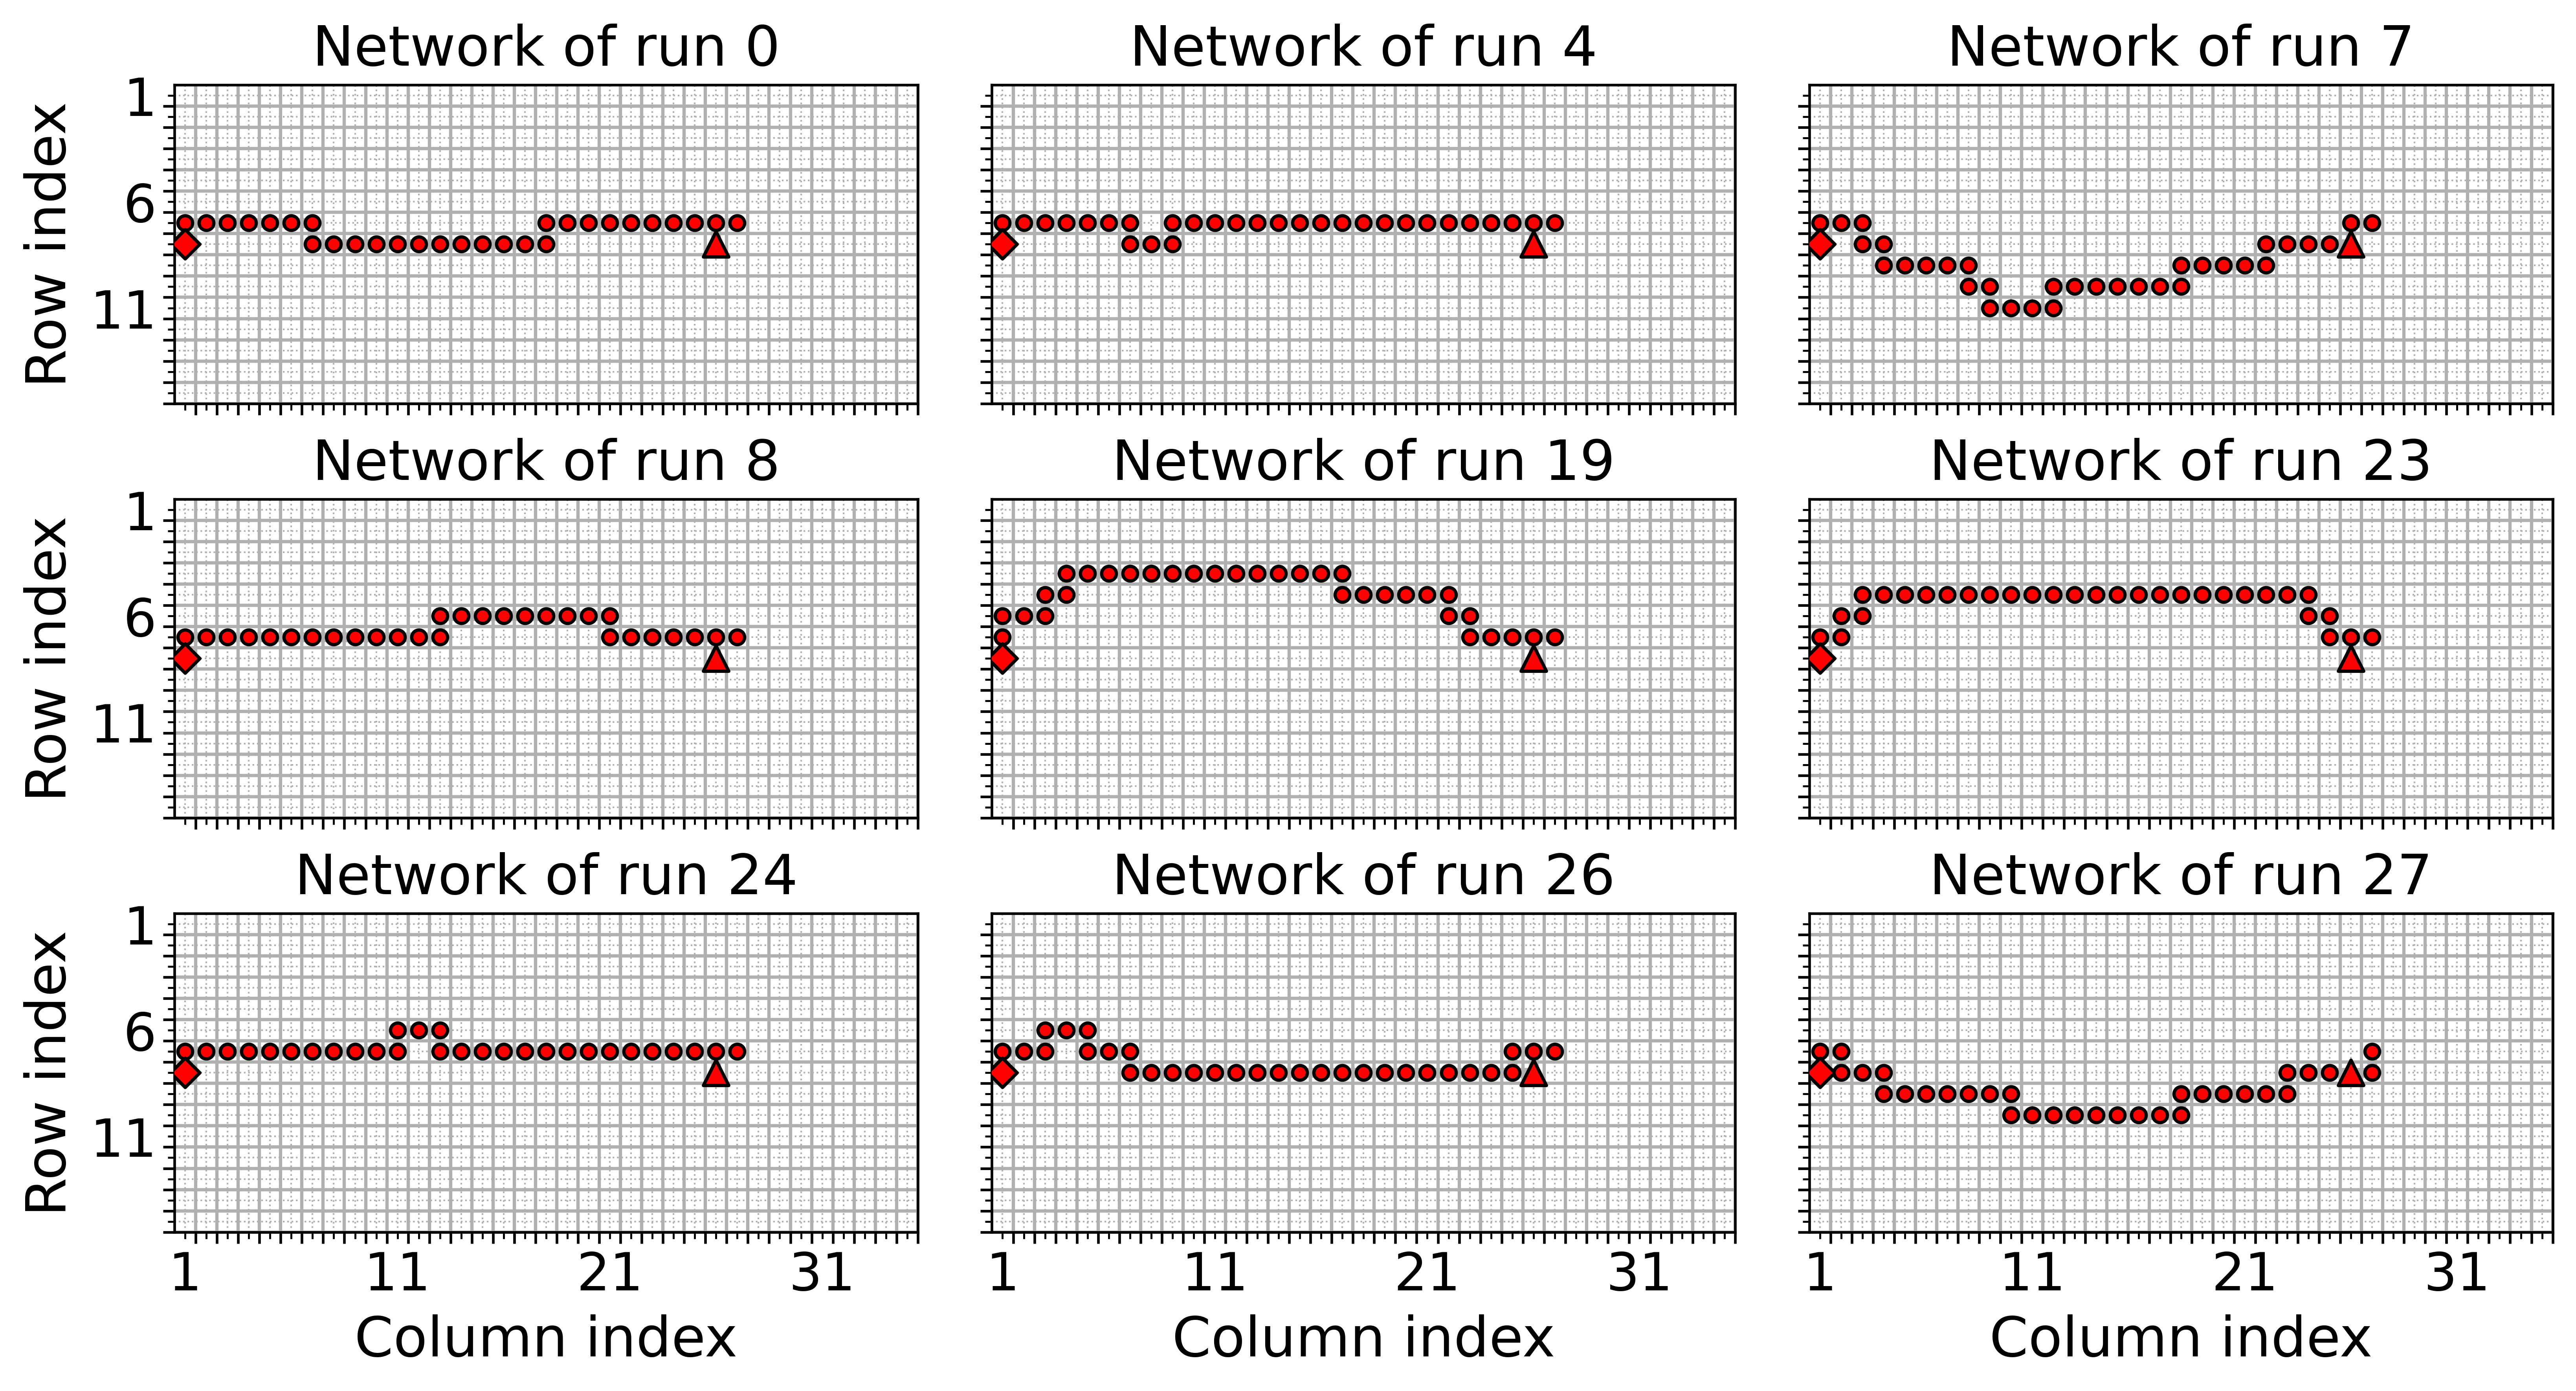

In [17]:
# create a figure and axes
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(13, 6), dpi=600, sharex=True, sharey=True)

# networks_plot = np.reshape(networks_plot, (3, 3))

for i in range(3):
    for j in range(3):
        # get the pipe and node coordinates from network object
        pipes_coords = networks_plot[rnd_[i, j]].pipes_coords
        node_x = networks_plot[rnd_[i, j]].node_x
        node_y = networks_plot[rnd_[i, j]].node_y
        
        # plot pipes
        for num, pipe in enumerate(pipes_coords):
            if num == 0:
                label = "Pipe"
            else:
                label = "_nolegend_"
            ax[i, j].plot(pipe[0],
                    pipe[1],
                    c="grey",
                    linewidth=3,
                    zorder=-1,
                    alpha=0.6,
                    label = label)
        
        # plot nodes
        for num, vals in enumerate(zip(node_x, node_y)):
            if num == 0:
                label = "Node"
            else:
                label = "_nolegend_"
                
            if vals[0] == 25.5 and vals[1] == 7.5:
                ax[i, j].scatter(vals[0],
                           vals[1],
                           zorder=100,
                           color="red",
                           s=60,
                           marker="^",
                           edgecolors="k",
                           label = "Inlet")
        
            elif vals[0] == 0.5 and vals[1] == 7.5:
                ax[i, j].scatter(vals[0],
                           vals[1],
                           zorder=100,
                           color="red",
                           s=40,
                           marker="D",
                           edgecolors="k",
                           label = "Outlet")
            else:
                ax[i, j].scatter(vals[0],
                                 vals[1],
                                 zorder=100,
                                 color="red",
                                 s=20,
                                 edgecolors="k",
                                 label = label)

        # set limits
        ax[i, j].set_xlim([0, n_cols])
        ax[i, j].set_ylim([0, n_rows])
        
        # invert axis for modflow representation
        ax[i, j].invert_yaxis()
        
        # adjust ticks if necessary
        ax[i, j].xaxis.set_minor_locator(tck.FixedLocator([i - 0.5 for i in range(1, n_cols + 1)]))
        ax[i, j].yaxis.set_minor_locator(tck.FixedLocator([i - 0.5 for i in range(1, n_rows + 1)]))
        
        ax[i, j].xaxis.set_major_locator(tck.FixedLocator([i for i in range(1, n_cols + 1)]))
        ax[i, j].yaxis.set_major_locator(tck.FixedLocator([i for i in range(1, n_rows + 1)]))
        
        ax[i, j].tick_params(axis='both', which='minor', labelsize=10)
        ax[i, j].set_xticklabels([i for i in range(1, n_cols + 1)], minor=True)
        ax[i, j].set_yticklabels([i for i in range(1, n_rows + 1)], minor=True)
        ax[i, j].set_xticklabels([None for i in range(n_cols)])
        ax[i, j].set_yticklabels([None for i in range(n_rows)])
        
        # add grid
        ax[i, j].grid(True, which="minor", ls=":", lw=0.5)
        ax[i, j].grid(True, which="major", ls="-", lw=1)
        
        for num, label in enumerate(ax[i, j].xaxis.get_ticklabels(which="minor")):
            label.set_visible(False)
            if num % 10 == 0:
                label.set_visible(True)
        for num, label in enumerate(ax[i, j].yaxis.get_ticklabels(which="minor")):
            label.set_visible(False)
            if num % 5 == 0:
                label.set_visible(True)
        
        ax[i, j].tick_params(axis='both', which='minor', labelsize=16)
        
        # set descriptions
        if i == 2:
            ax[i, j].set_xlabel("Column index", size=17)
        if j == 0:
            ax[i, j].set_ylabel("Row index", size=17)
            
        ax[i, j].set_title("Network of run {}".format(rnd_[i, j]), size=17)
        
        ax[i, j].set_aspect("equal")
            
        # make beautiful if necessary
        plt.tight_layout()
            
        # # save figure
        # plt.savefig(f'network_{number}.jpg', dpi=300)

plt.subplots_adjust(hspace=0.3, wspace=0.05, right=0.8)
plt.savefig("networks_selection.png", dpi=600, bbox_inches="tight")

### 3.3 Plot standard deviation of head

5.4904795


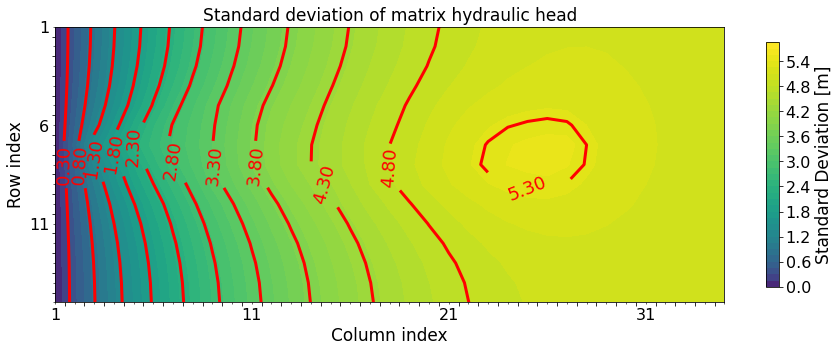

In [18]:
import matplotlib.colors as colors

# top view
path = os.getcwd()
target_dir = os.path.join(path, 'FIGS')

run_idx = 0

hds_std = []
for i in rnd:
    hds_std.append(total_head[i, :, :])

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
Z = np.std(total_head[:,:,:], axis=0)

print(Z.max())

im = ax.contourf(Z, np.linspace(0, 6, 40, endpoint=False), norm=colors.PowerNorm(gamma = 0.5))
CS = ax.contour(Z, levels=np.linspace(0.3, 5.3, 11, endpoint=True), colors="red", linewidths=3)
ax.clabel(CS, CS.levels, inline=True, fontsize=18, fmt="%1.2f", rightside_up=True, inline_spacing=50)
cb = plt.colorbar(im, shrink=0.3)

cb.set_label("Standard Deviation [m]", size=17)
run_number = rd.replace(os.path.join(path, "run_"), "")
plt.title(f"Standard deviation of matrix hydraulic head", size=17) #{np.sum(success_runs)}
ax.set_xlabel("Column index", size=17)
ax.set_ylabel("Row index", size =17)

# invert axis for modflow representation
ax.invert_yaxis()

ax.xaxis.set_major_locator(tck.FixedLocator([i - 0.5 for i in range(n_cols)]))
ax.yaxis.set_major_locator(tck.FixedLocator([i - 0.5 for i in range(n_rows)]))

ax.xaxis.set_minor_locator(tck.FixedLocator([i for i in range(n_cols)]))
ax.yaxis.set_minor_locator(tck.FixedLocator([i for i in range(n_rows)]))

ax.tick_params(axis='both', which='minor', labelsize=10)
ax.set_xticklabels([i for i in range(1, n_cols + 1)], minor=True)
ax.set_yticklabels([i for i in range(1, n_rows + 1)], minor=True)
ax.set_xticklabels([None for i in range(n_cols)])
ax.set_yticklabels([None for i in range(n_rows)])

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

for num, label in enumerate(ax.xaxis.get_ticklabels(which="minor")):
    label.set_visible(False)
    if num % 10 == 0:
        label.set_visible(True)
for num, label in enumerate(ax.yaxis.get_ticklabels(which="minor")):
    label.set_visible(False)
    if num % 5 == 0:
        label.set_visible(True)

# add grid
# ax.grid(True, which="minor", ls=":", lw=0.5)
# ax.grid(True, which="major", ls="-", lw=1)

ax.tick_params(axis='x', labelsize=16, which="minor")
ax.tick_params(axis='y', labelsize=16, which="minor")
cb.ax.tick_params(labelsize=16)

abs_filename = os.path.join(target_dir, 'SDV_Matrix_Heads.png')
plt.savefig(abs_filename, dpi=600)

C:\Users\MRudolph\AppData\Local\Temp\ipykernel_8848\4227949742.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([i * 5 + 1 for i in range(7)])


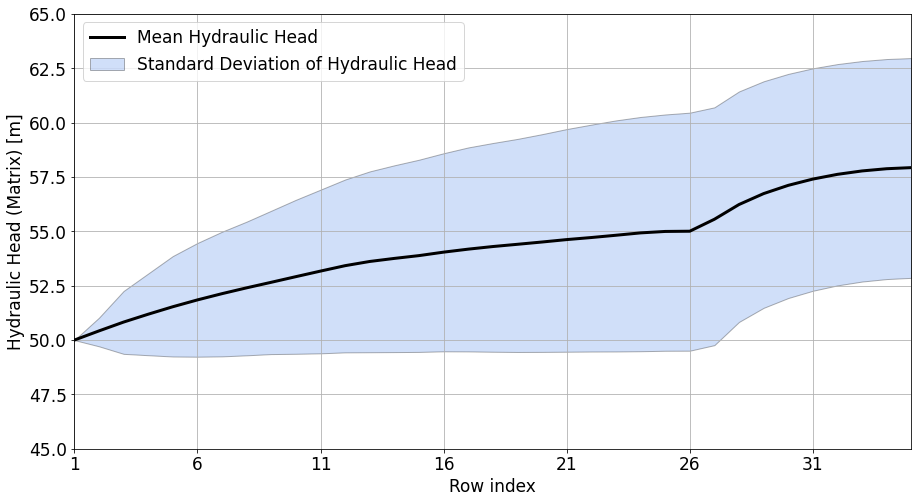

In [19]:
# cross section along a row
path = os.getcwd()
target_dir = os.path.join(path, 'FIGS')

run_idx = 0 

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(total_head[:, 7, :].mean(axis=0), label="Mean Hydraulic Head", c="black", lw=3.)
ax.fill_between(
    [i for i in range(35)],
    total_head[:, 6, :].mean(axis=0) + total_head[:, 6, :].std(axis=0),
    total_head[:, 6, :].mean(axis=0) - total_head[:, 6, :].std(axis=0),
    edgecolor="black",
    facecolor="cornflowerblue",
    alpha=0.3,
    label="Standard Deviation of Hydraulic Head"
)

ax.grid(which="major")
ax.set_ylim(45, 65)
ax.set_xlim(0, 34)
ax.set_xticklabels([i * 5 + 1 for i in range(7)])
ax.legend(loc="upper left", fontsize=17)
ax.tick_params(labelsize=17)
ax.set_xlabel("Row index", fontsize=17)
ax.set_ylabel("Hydraulic Head (Matrix) [m]", fontsize=17)

abs_filename = os.path.join(target_dir, 'SDV_Matrix_Heads_Along_Row.png')
plt.savefig(abs_filename, dpi=600)

### 3.4 Read in and process tube data
All data from the tubes is processed; subsequently a plot with the distribution of discharge for all variants is generated.

In [20]:
# get all dictionaries with results
run_dirs = glob.glob(os.path.join(path, "run_*"))

# sort in place
run_dirs.sort()

tube_list = []
for rd in run_dirs:
    print(f"Directory {rd}")
    
    os.chdir(rd)
    
    nbr_data, cond_elev = read_nbr()
    
    if idxs_spring in nbr_data[3]:
        # get the position of conduit associated with the spring node
        pos = nbr_data[3].index(idxs_spring)
        tube_number = nbr_data[5][pos]
    else:
        raise Exception("No conduit assigned to the spring")

    
    fr = cfpy.postprocessing.FileReader(
    path=os.path.join(rd, modelname + ".list")
    )
    node_data, tube_data = fr.read_output(tube_num=tube_number)
    # subdf = tube_data[0]
    tube_data.index = pd.Index([rd.replace(os.path.join(path, "run_"), "")])
    tube_list.append(tube_data)

os.chdir(path)

Directory C:\Users\MRudolph\Documents\GitHub\CFPy\CFPy_Examples\CFPy_EX02_RUN\run_0
Elapsed time (.nbr file read): 0.0 s
Elapsed time (write nbr data): 0.0 s
Directory C:\Users\MRudolph\Documents\GitHub\CFPy\CFPy_Examples\CFPy_EX02_RUN\run_1
Elapsed time (.nbr file read): 0.0 s
Elapsed time (write nbr data): 0.0 s
Directory C:\Users\MRudolph\Documents\GitHub\CFPy\CFPy_Examples\CFPy_EX02_RUN\run_10
Elapsed time (.nbr file read): 0.0 s
Elapsed time (write nbr data): 0.0 s
Directory C:\Users\MRudolph\Documents\GitHub\CFPy\CFPy_Examples\CFPy_EX02_RUN\run_11
Elapsed time (.nbr file read): 0.0 s
Elapsed time (write nbr data): 0.0 s
Directory C:\Users\MRudolph\Documents\GitHub\CFPy\CFPy_Examples\CFPy_EX02_RUN\run_12
Elapsed time (.nbr file read): 0.0 s
Elapsed time (write nbr data): 0.02 s
Directory C:\Users\MRudolph\Documents\GitHub\CFPy\CFPy_Examples\CFPy_EX02_RUN\run_13
Elapsed time (.nbr file read): 0.0 s
Elapsed time (write nbr data): 0.01 s
Directory C:\Users\MRudolph\Documents\GitHub\C

IndexError: list index out of range

In [ ]:
discharge = []
for df in tube_list:
    discharge.append(df.iloc[:, 4].values)
    
discharge = np.array(discharge).flatten()
    
hist = plt.hist(discharge, bins=20)